In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import mlflow
from sklearn.model_selection import train_test_split

HOST = "127.0.0.1"
PORT = "8080"
mlflow.set_tracking_uri(uri=f"http://{HOST}:{PORT}")


Home Credit est un fournisseur internationnal de crédit à la consommation. Ils octroient des prêts principalement aux personnes ayant peu ou pas d'historique de crédit

## Import données

In [3]:
data = pd.read_csv("./data/application_train.csv")

print(data.shape)

data.head()


(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Une ligne représente un prêt.

Il y a 122 colonnes qui nous donnent des informations sur ces prêts, dont la colonne TARGET qui est notre cible à prédire.

Elle vaut 1 quand une personne a eu un retard de paiement dans son prêt et 0 pour les autres cas.

## Fonctions

In [4]:
def plot_categorical(
    column_name: str, top_n=None, figsize: tuple = (10, 6), rotation: int = 45
):
    """
    Create a bar plot for categorical data showing counts and percentages.

    Parameters:
    -----------
    column_name : str
        Name of the column to plot from the data DataFrame
    figsize : tuple, optional (default=(10, 6))
        Figure size as (width, height)
    rotation : int, optional (default=45)
        Rotation angle for x-axis labels

    Returns:
    --------
    None
        Displays the plot
    """
    # Calculate missing values percentage
    missing_pct = (data[column_name].isna().sum() / len(data)) * 100

    # Calculate counts and percentages
    value_counts = data[column_name].value_counts()

    # Handle top_n parameter
    if top_n and len(value_counts) > top_n:
        others_count = value_counts[top_n:].sum()
        value_counts = value_counts[:top_n]
        value_counts["Others"] = others_count

    percentages = value_counts / len(data) * 100

    plt.figure(figsize=figsize)
    ax = value_counts.plot(kind="bar")

    # Add percentage labels inside bars
    for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
        # Only show percentages > 1% to avoid cluttering
        if percentage > 1:
            plt.text(
                i,
                count / 2,  # Center of the bar
                f"{percentage:.1f}%",
                ha="center",
                va="center",
                color="white",
                fontweight="bold",
            )

    plt.xlabel(column_name.replace("_", " ").title())
    plt.ylabel("Count")
    title = f"Distribution of {column_name.replace('_', ' ').title()}"
    if missing_pct > 0:
        title += f"\n(Missing Values: {missing_pct:.1f}%)"
    if top_n and len(data[column_name].unique()) > top_n:
        title += f"\n(Top {top_n} categories)"
    plt.title(title)
    plt.xticks(rotation=rotation)

    plt.tight_layout()
    plt.show()


In [66]:
value_counts = data["CODE_GENDER"].value_counts()
value_counts


CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [68]:
value_counts == value_counts.iloc[0].sum()


CODE_GENDER
F       True
M      False
XNA    False
Name: count, dtype: bool

In [ ]:
def encode_binary_columns(train_df: pd.DataFrame, val_df: pd.DataFrame):
    """
    Encodes object-type columns in the training and validation DataFrames using LabelEncoder,
    if the column has 2 or fewer unique values.

    Parameters:
        train_df (pd.DataFrame): Training dataset.
        val_df (pd.DataFrame): Validation dataset.
    """
    le_count = 0

    for col in train_df.columns:
        if train_df[col].dtype == "object":
            if train_df[col].nunique() <= 2:
                print(f"Encoding {train_df[col].name} column")
                le = LabelEncoder()
                # Fit on the training data
                train_df[col] = le.fit_transform(train_df[col])
                # Transform the validation data using the same encoder
                val_df[col] = le.transform(val_df[col])
                le_count += 1

    print(f"{le_count} columns were label encoded.")


## Analyse exploratoire des données

In [6]:
display(data.describe())


SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

### Types de variables

In [7]:
categorical = data.select_dtypes(include=["object"]).columns.tolist()

print("There are {} categorical variables\n".format(len(categorical)))

print("The categorical variables are :", categorical)


There are 16 categorical variables

The categorical variables are : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [8]:
data.select_dtypes("object").apply(pd.Series.nunique, axis=0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des colonnes catégorielles ont un nombre relativement petit de valeur unique.

### Valeurs manquantes

In [9]:
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates a table with the number and percentage of missing values for each column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The dataframe to analyze.

    Returns:
        pd.DataFrame: A DataFrame with columns "Missing Values" and "% of Total Values" for columns
                      that contain missing values, sorted by percentage of missing values in descending order.
    """
    missing_count = df.isnull().sum()
    missing_percentage = 100 * missing_count / len(df)

    # Combine counts and percentages into a single DataFrame
    missing_table = pd.concat([missing_count, missing_percentage], axis=1)
    missing_table.columns = ["Missing Values", "% of Total Values"]

    # Filter out columns with no missing values and sort by percentage descending
    missing_table = (
        missing_table[missing_table["% of Total Values"] > 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    total_columns = df.shape[1]
    missing_columns = missing_table.shape[0]
    print(f"Dataframe has {total_columns} columns.")
    if missing_columns:
        print(f"There are {missing_columns} columns with missing values.")
    else:
        print("Dataframe has no missing values.")

    return missing_table


In [10]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values


Dataframe has 122 columns.
There are 67 columns with missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

Il y a environ 33% des colonnes qui ont plus de 50% de valeurs vides et 40% des colonnes qui ont moins de 30% de valeurs vides.

Il faudrait tester dans les futurs modèles d'enlever les colonnes avec trop de valeurs vides et d'imputer les valeurs pour les colonnes en ayant peu.


### TARGET

In [11]:
display(data["TARGET"].value_counts())


TARGET
0    282686
1     24825
Name: count, dtype: int64

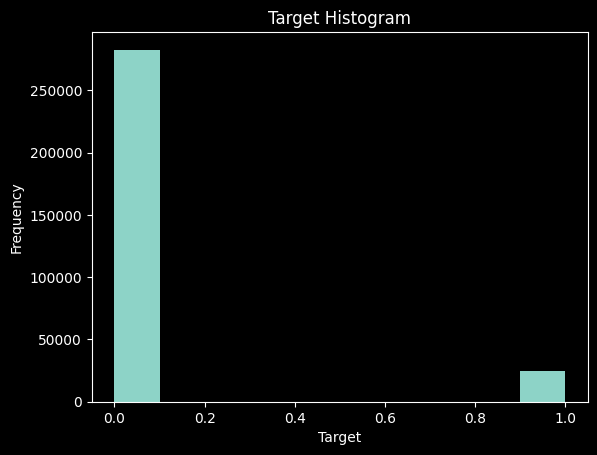

In [12]:
data["TARGET"].astype(int).plot.hist(title="Target Histogram")
plt.xlabel("Target");


Il y a beaucoup plus de personne qui n'ont pas eu de problèmes de paiements que de personnes qui en ont eu.

Il y a un fort déséquilibre sur la colonne cible.

### Variables continues

#### AGE

Cette colonne représente l'âge de le personne qui effectue un prêt. Il faut convertir les âges car il sont relatifs à la date du début du prêt.

In [13]:
data["AGE"] = data["DAYS_BIRTH"] / -365
data = data.drop(columns=["DAYS_BIRTH"])


In [14]:
data["AGE"].describe()


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE, dtype: float64

La moitié des personnes avaient moins de 43 ans au moment de contracter un prêt, 75% depuis moins 54 ans.

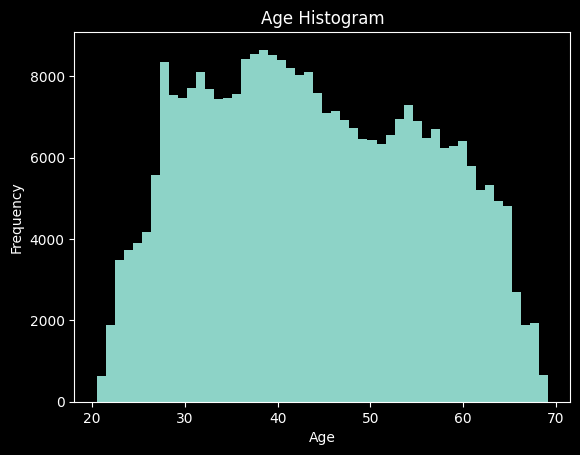

In [15]:
data["AGE"].plot.hist(bins=50, title="Age Histogram")
plt.xlabel("Age");


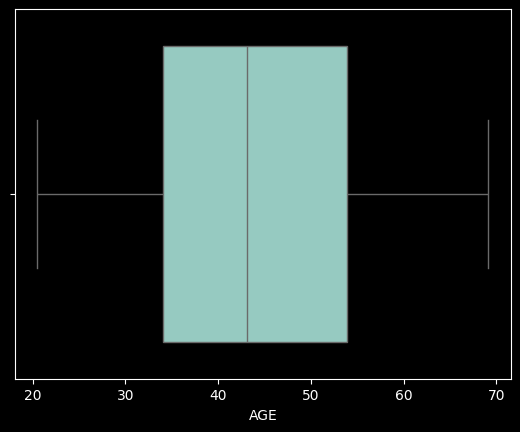

In [16]:
sns.boxplot(x=data["AGE"]);


####  DAYS_EMPLOYED

Cette colonne représente le nombre de jours avant le début du prêt qu'une personne a commencer son travail actuel.

In [17]:
data["DAYS_EMPLOYED"] = -data["DAYS_EMPLOYED"]


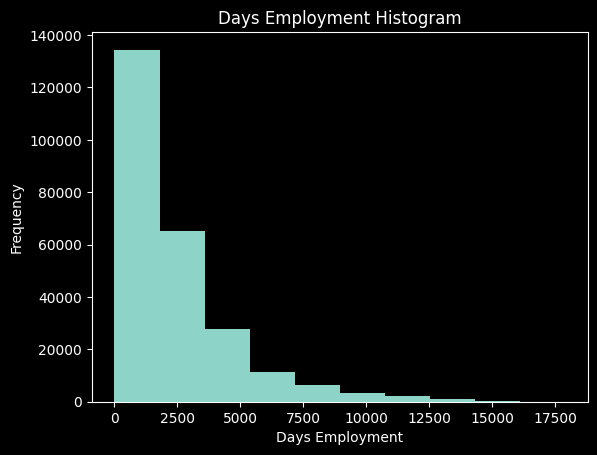

In [18]:
# Create an anomalous flag column
data["DAYS_EMPLOYED_ANOM"] = data["DAYS_EMPLOYED"] == -365243

# Replace the anomalous values with nan
data.replace({"DAYS_EMPLOYED": {-365243: np.nan}}, inplace=True)
data["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment");


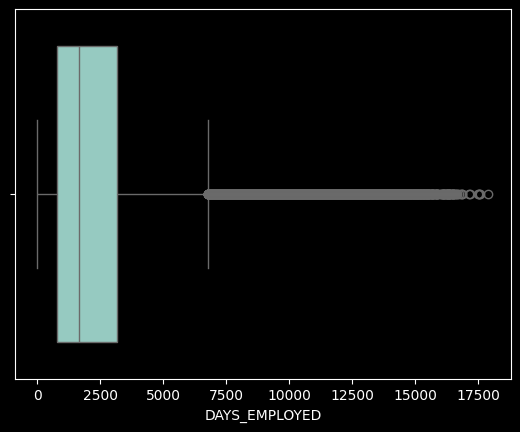

In [19]:
sns.boxplot(x=data["DAYS_EMPLOYED"]);


In [20]:
data["DAYS_EMPLOYED"].describe()


count    252137.000000
mean       2384.169325
std        2338.360162
min           0.000000
25%         767.000000
50%        1648.000000
75%        3175.000000
max       17912.000000
Name: DAYS_EMPLOYED, dtype: float64

La moitié des personnes avaient commencé leur travail depuis moins de 4 ans et demi au moment de contracter un prêt, 75% depuis moins 8,7 ans.

####  AMT_INCOME_TOTAL

Cette colonne représente le revenu total d'un client, sur une année.

In [21]:
data["AMT_INCOME_TOTAL"].describe()


count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

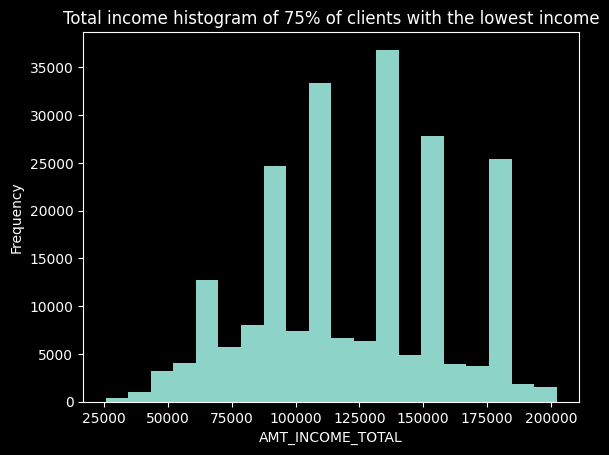

In [22]:
data[data["AMT_INCOME_TOTAL"] < 2.025e5]["AMT_INCOME_TOTAL"].plot.hist(
    title="Total income histogram of 75% of clients with the lowest income",
    bins=20,
)
plt.xlabel("AMT_INCOME_TOTAL");


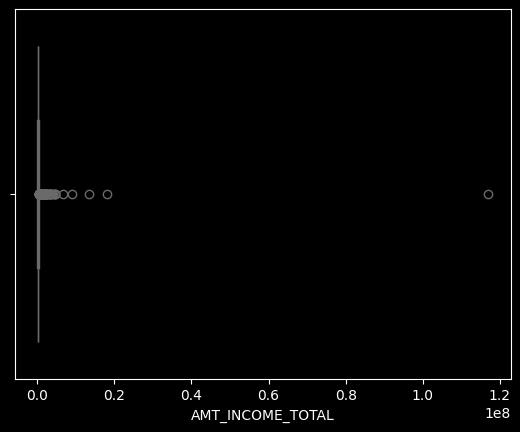

In [23]:
sns.boxplot(x=data["AMT_INCOME_TOTAL"]);


La moitié des personnes qui contractent un prêt ont un revenu annuel de moins de 147 150, 75% moins 202 500.

Nous pouvons voir avec le boxplot qu'il y a une valeur très extrême qui est un revenu annuel de 117 000 000.

####  AMT_CREDIT

Cette colonne représente le montant du crédit.

In [24]:
data["AMT_CREDIT"].describe()


count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

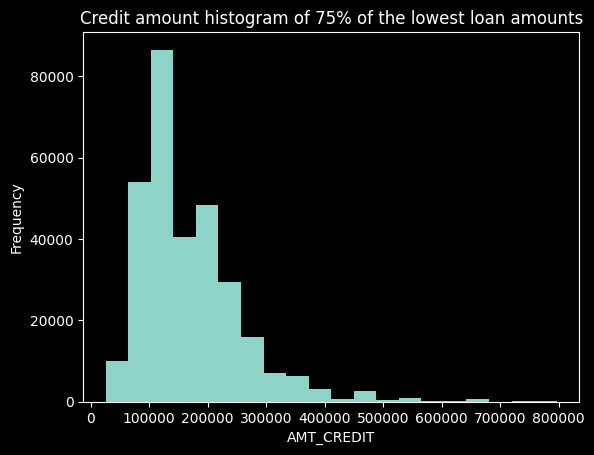

In [25]:
data[data["AMT_INCOME_TOTAL"] < 8.09e5]["AMT_INCOME_TOTAL"].plot.hist(
    title="Credit amount histogram of 75% of the lowest loan amounts", bins=20
)
plt.xlabel("AMT_CREDIT");


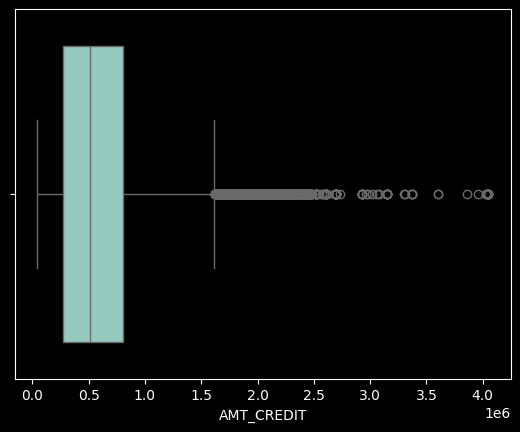

In [26]:
sns.boxplot(x=data["AMT_CREDIT"]);


In [27]:
data["AMT_CREDIT"].describe()


count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

La moitié des montant des crédits est de moins de 513 531, 75% moins 808 650.

Nous pouvons voir avec le boxplot qu'il y a des valeurs extrêmes, notamment le montant le plus important qui est de 4 050 000.

#### AMT_GOODS_PRICE

Cette colonne représente le prix des biens pour lesquels le prêt est accordé.

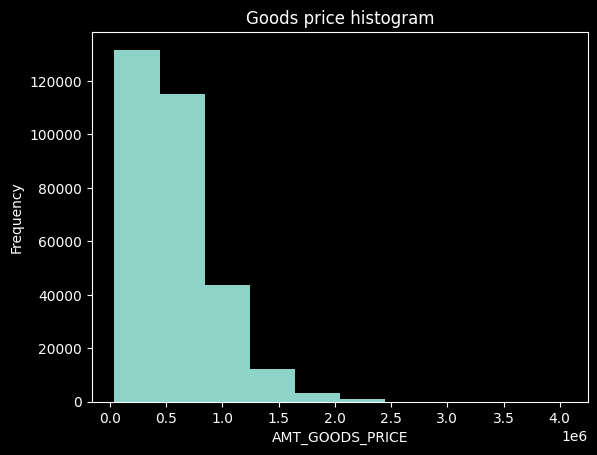

In [28]:
data["AMT_GOODS_PRICE"].plot.hist(title="Goods price histogram")
plt.xlabel("AMT_GOODS_PRICE");


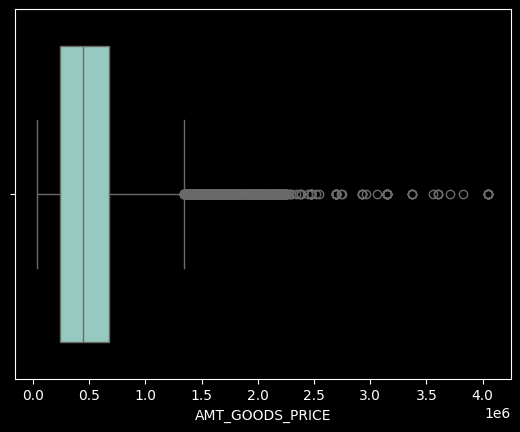

In [29]:
sns.boxplot(x=data["AMT_GOODS_PRICE"]);


In [30]:
data["AMT_GOODS_PRICE"].describe()


count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

La moitié du prix des biens pour lequel le prêt a été accordé est de moins de 450 000, 75% moins 679 500.

Nous pouvons voir avec le boxplot qu'il y a des valeurs extrêmes, notamment le montant le plus important qui est de 4 050 000.

#### OWN_CAR_AGE

Cette colonne représente l'ancienneté de la voiture d'une personne.

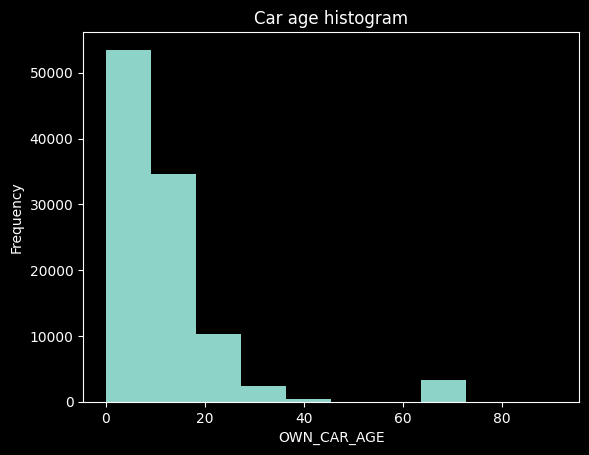

In [31]:
data["OWN_CAR_AGE"].plot.hist(title="Car age histogram")
plt.xlabel("OWN_CAR_AGE");


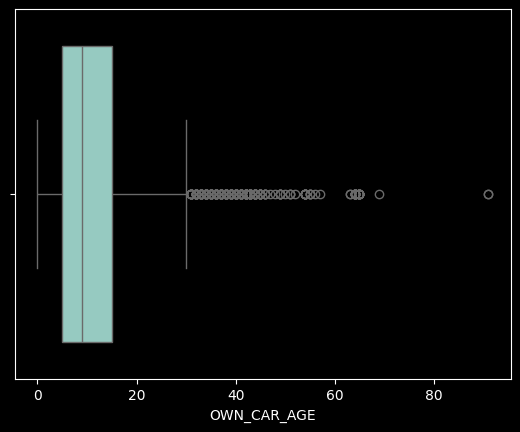

In [32]:
sns.boxplot(x=data["OWN_CAR_AGE"]);


In [33]:
data["OWN_CAR_AGE"].describe()


count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

50% des personnes ont une voiture avec une ancienneté de 9 ans ou moins, 75% avec une ancienneté de 15 ans ou moins.

#### CNT_CHILDREN

Cette colonne représente le nombre d'enfant d'une personne.

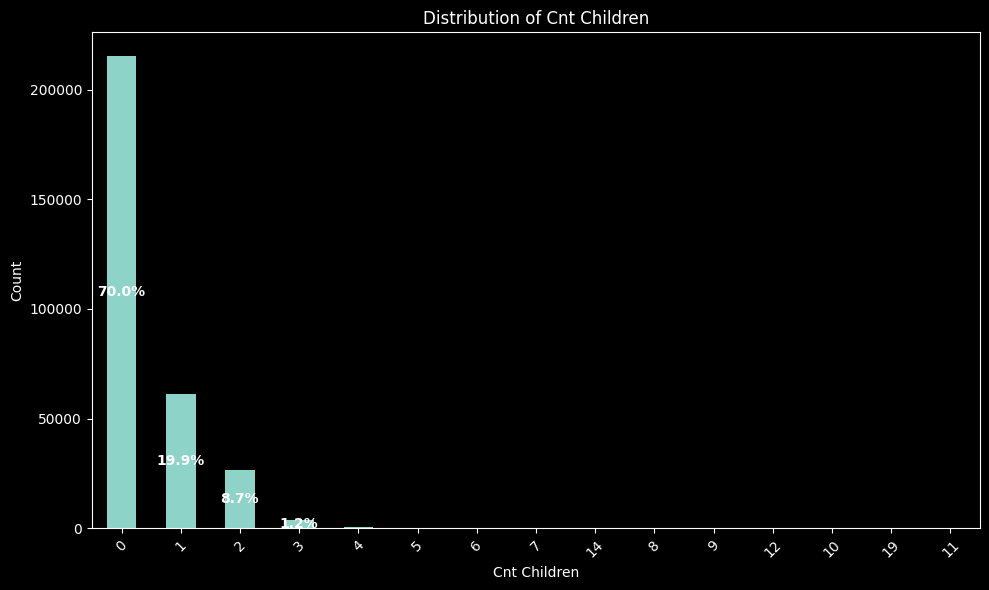

In [34]:
plot_categorical("CNT_CHILDREN")


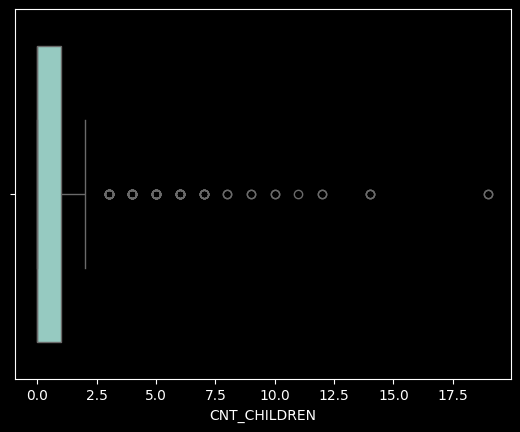

In [35]:
sns.boxplot(x=data["CNT_CHILDREN"]);


In [36]:
data["CNT_CHILDREN"].describe()


count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

70% des personnes n'ont pas d'enfants, 19.9% ont un enfant, 8.7% en ont 2.

#### CNT_FAM_MEMBERS

Cette colonne représente le nombre de membre que compte la famille d'une personne.

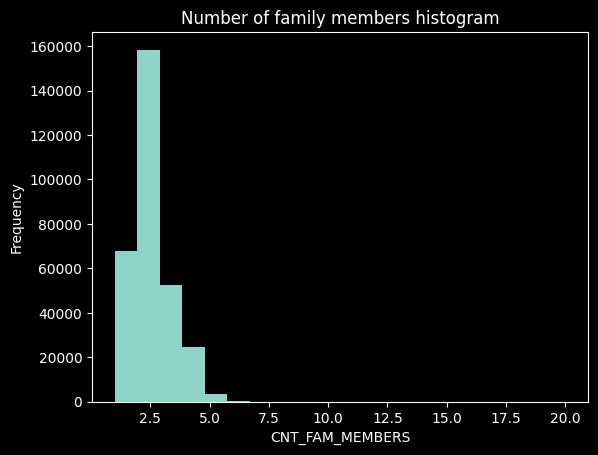

In [37]:
data["CNT_FAM_MEMBERS"].plot.hist(
    title="Number of family members histogram", bins=20
)
plt.xlabel("CNT_FAM_MEMBERS");


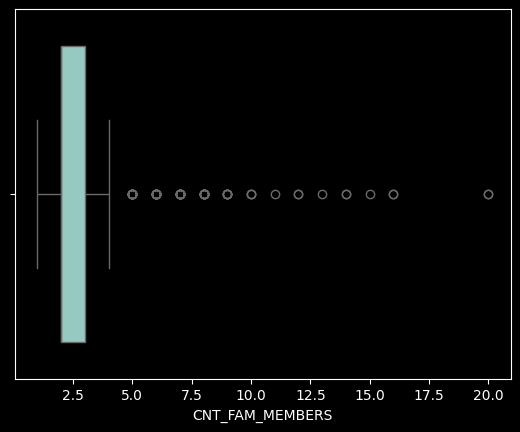

In [38]:
sns.boxplot(x=data["CNT_FAM_MEMBERS"]);


In [39]:
data["CNT_FAM_MEMBERS"].describe()


count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

50% des personnes ont une famille qui compte 2 membres ou moins, 75% 3 membres ou moins.

#### DAYS_LAST_PHONE_CHANGE

Cette colonne représente l'écart en jours entre la dernière fois qu'une personne à changé de téléphone et la demande du prêt.

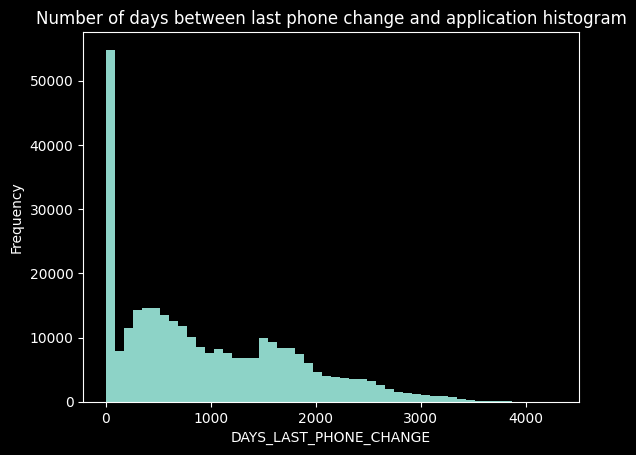

In [40]:
data["DAYS_LAST_PHONE_CHANGE"] = -data["DAYS_LAST_PHONE_CHANGE"]
data["DAYS_LAST_PHONE_CHANGE"].plot.hist(
    title="Number of days between last phone change and application histogram",
    bins=50,
)
plt.xlabel("DAYS_LAST_PHONE_CHANGE");


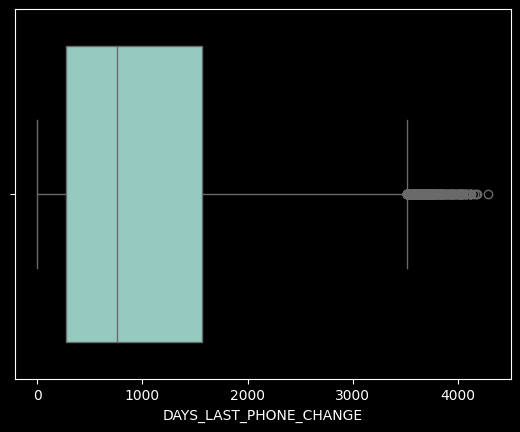

In [41]:
sns.boxplot(x=data["DAYS_LAST_PHONE_CHANGE"]);


In [42]:
data["DAYS_LAST_PHONE_CHANGE"].describe()


count    307510.000000
mean        962.858788
std         826.808487
min          -0.000000
25%         274.000000
50%         757.000000
75%        1570.000000
max        4292.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

50% des personnes ont changé de téléphone depuis moins de 757 jours.

En regardant l'histogramme, on peut remarquer qu'un peu plus de 50 000 personnes ont changé de téléphonne récemment (un peu plus de 16%)

### Variables catégorielles

#### NAME_CONTRACT_TYPE

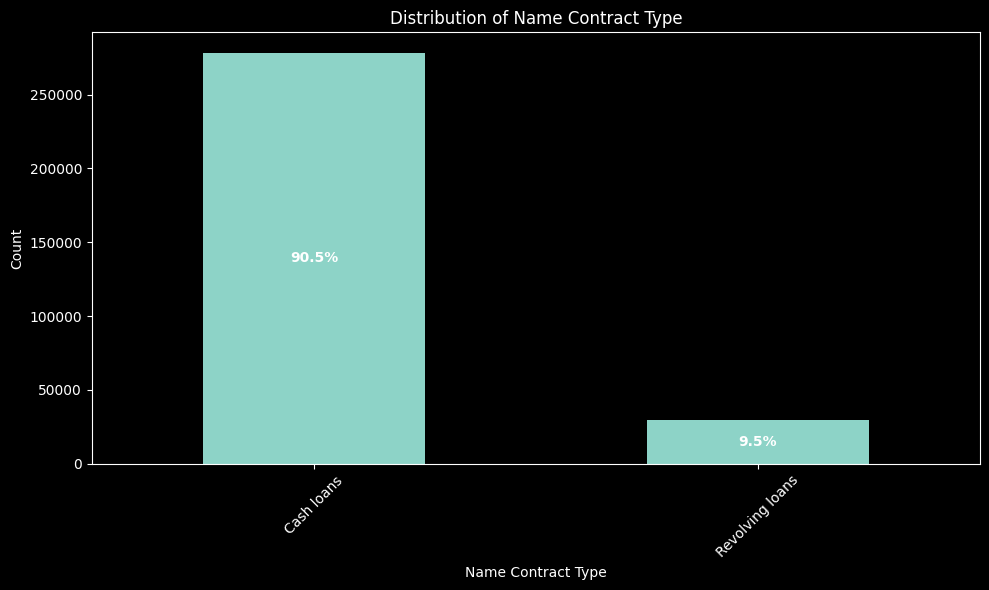

In [43]:
plot_categorical("NAME_CONTRACT_TYPE")


La grande majorité des contrats sont des prêts de trésorerie, les autres sont des crédits renouvelables.

Les credits renouvelables sont plus flexibles que les prêts de trésorerie (les fonds sont disponibles à tout moment) mais il peuvent avoir des taux variables plus élevés.

Pour les prêts de trésorerie, les mensualités sont fixées dès le début ainsi que les conditions de remboursement.

#### CODE_GENDER

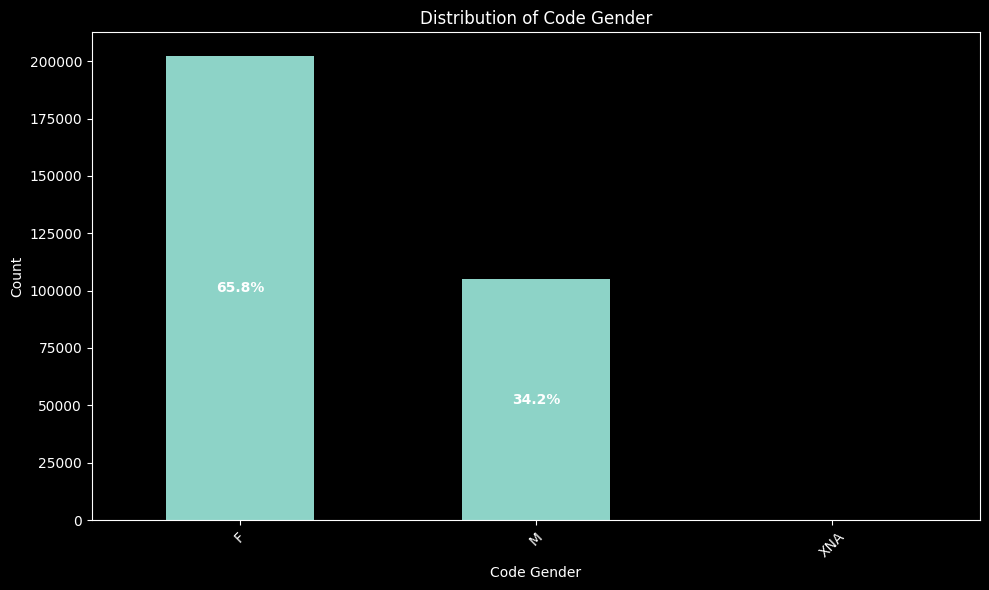

In [44]:
plot_categorical("CODE_GENDER")


Il y a une plus grande proportion de femmes qui contractent des prêts que les hommes.

#### FLAG_ON_CAR

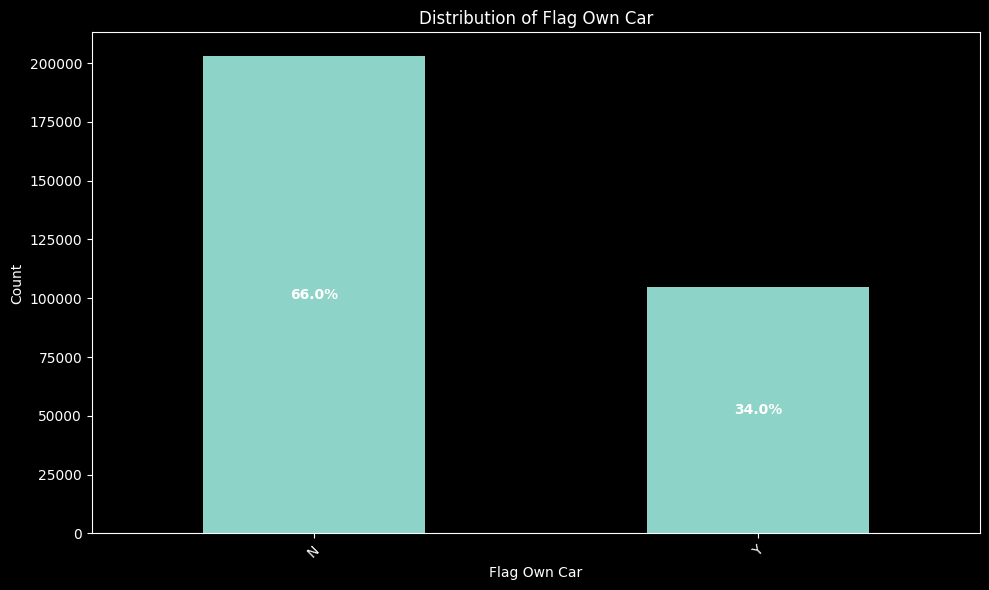

In [45]:
plot_categorical("FLAG_OWN_CAR")


Il y a une plus grand proportion de personnes qui contractent un prêt qui n'ont pas de voiture.

#### FLAG_OWN_REALTY

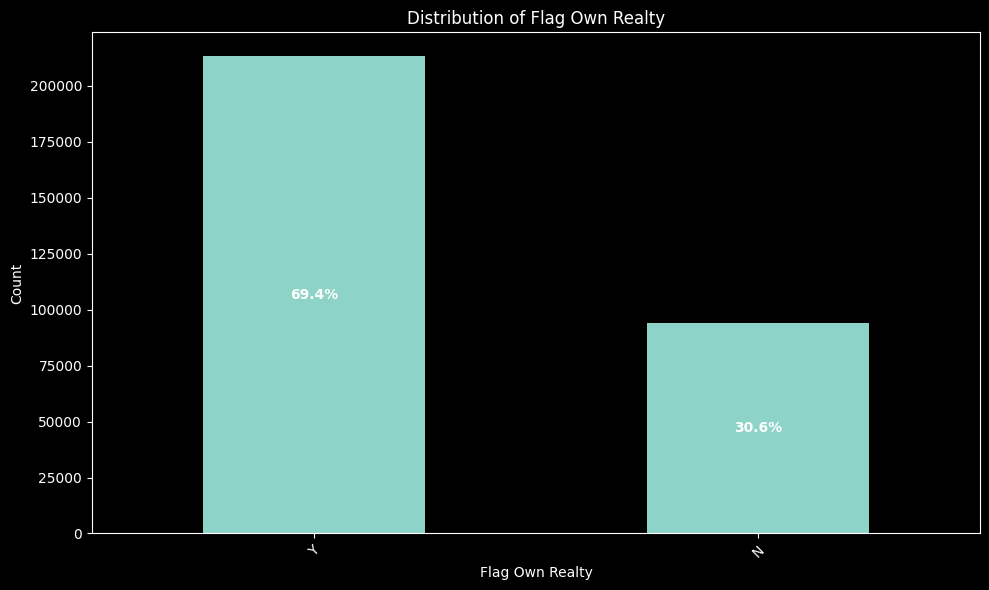

In [46]:
plot_categorical("FLAG_OWN_REALTY")


Il y a une plus grand proportion de personnes qui contractent un prêt qui n'ont pas ni d'appartement ni de maison.

#### NAME_TYPE_SUITE

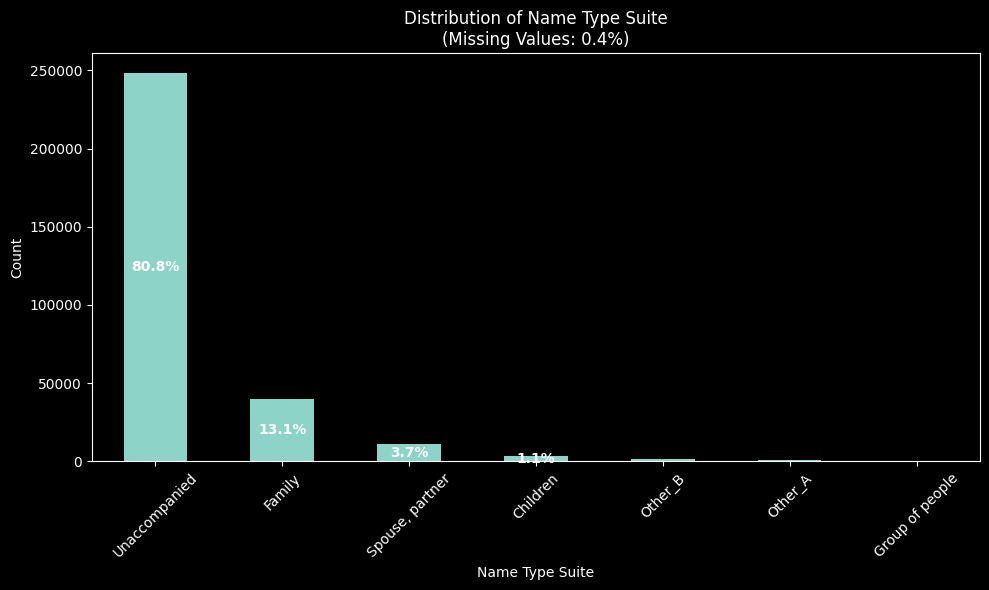

In [47]:
plot_categorical("NAME_TYPE_SUITE")


Cette colonne représente par qui les personnes ont été accompagné lorsqu'elles ont contracté leur prêt, si elles l'ont été.

La majorité des personnes n'ont pas été accompagnées.

#### NAME_INCOME_TYPE

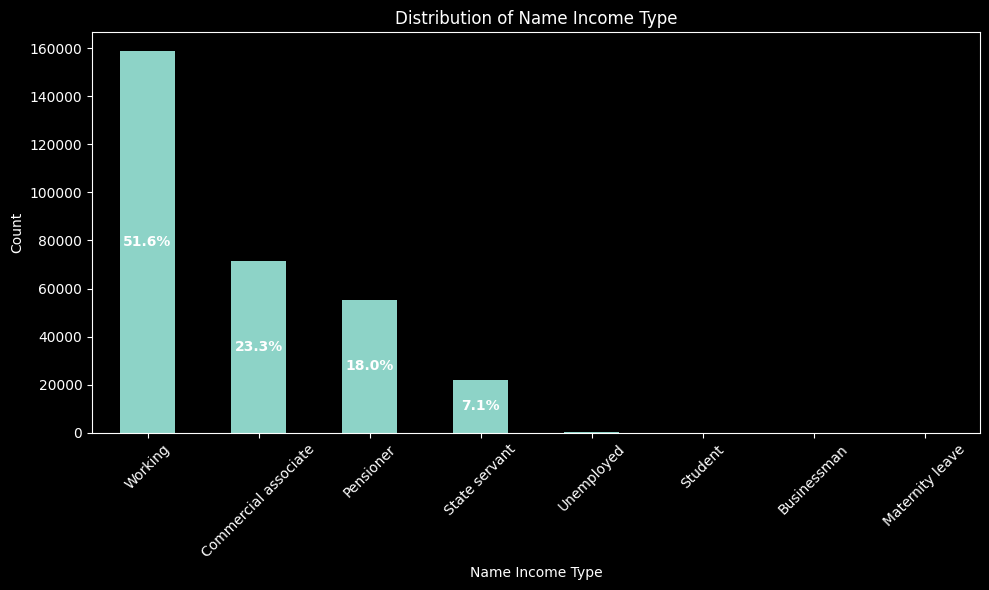

In [48]:
plot_categorical("NAME_INCOME_TYPE")


Cette colonne représente le type de revenu des personnes.

Un peu plus de la moitié des personnes travaillaient quand elles ont contracté leur prêt, 23.3% étaient des associés commerciaux, 18% des retraités, 7.1% des fonctinnaires.

#### NAME_EDUCATION_TYPE

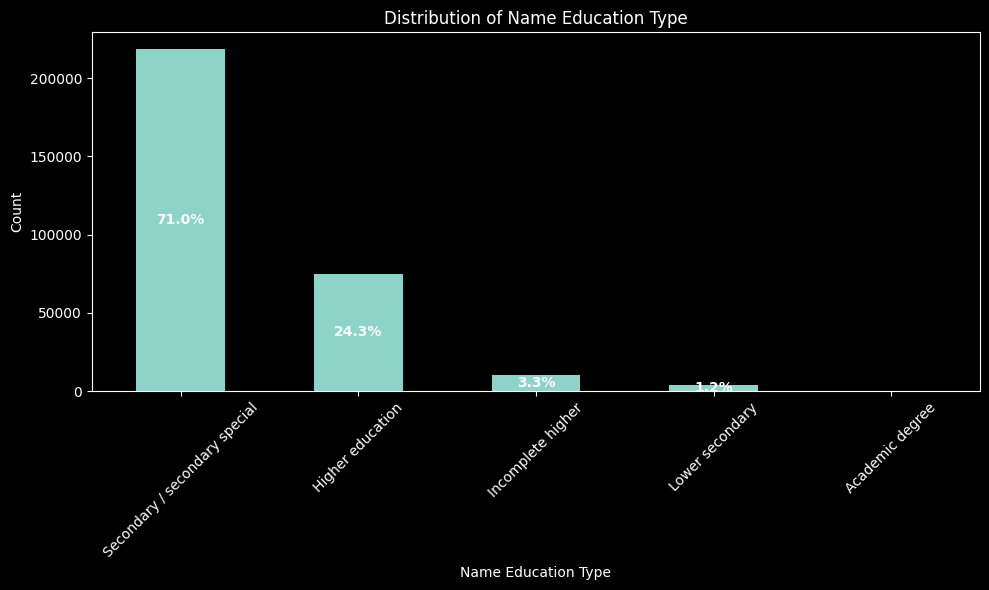

In [49]:
plot_categorical("NAME_EDUCATION_TYPE")


Cette colonne représente le niveau d’étude le plus élevé atteint par les personnes.

La plupart des clients ont eu leur Baccalauréat, 24.3% ont fini leurs études supérieurs.


#### NAME_FAMILY_STATUS

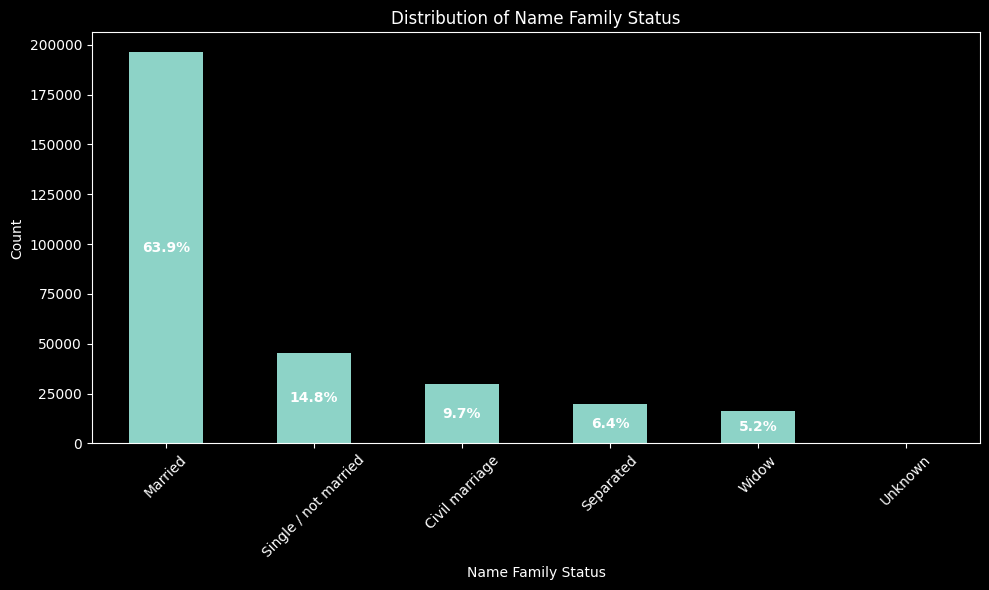

In [50]:
plot_categorical("NAME_FAMILY_STATUS")


Cette colonne représente le statut familial des personnes.

La majorité sont mariés.

#### NAME_HOUSING_TYPE

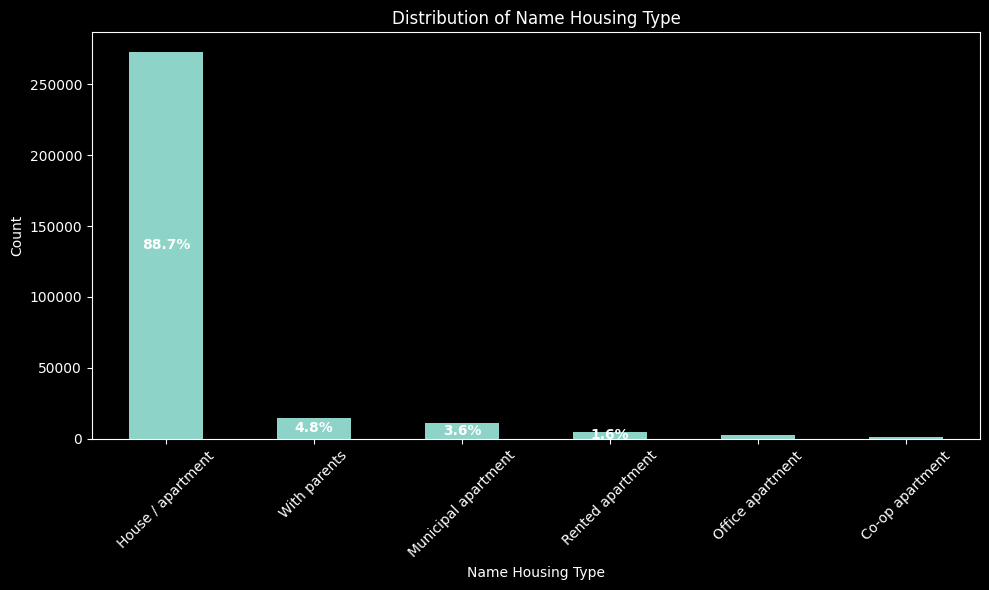

In [51]:
plot_categorical("NAME_HOUSING_TYPE")


Cette colonne représente la situation résidentielle des personnes.

La grande majorité vivent en maison ou en appartement.

#### OCCUPATION_TYPE

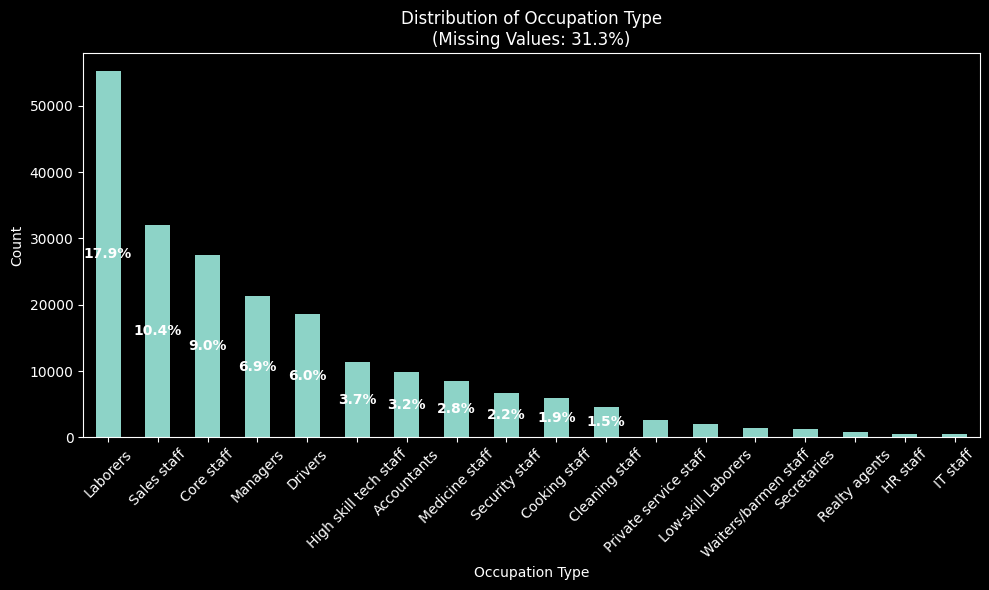

In [52]:
plot_categorical("OCCUPATION_TYPE")


Cette colonne représente le type d'une personne.

La majorité (17.9% sont des agriculteurs), 10.4% sont des vendeurs, 9% sont des employés, 6.9% sont des managers et 6% sont des chauffeurs.

#### WEEKDAY_APPR_PROCESS_START

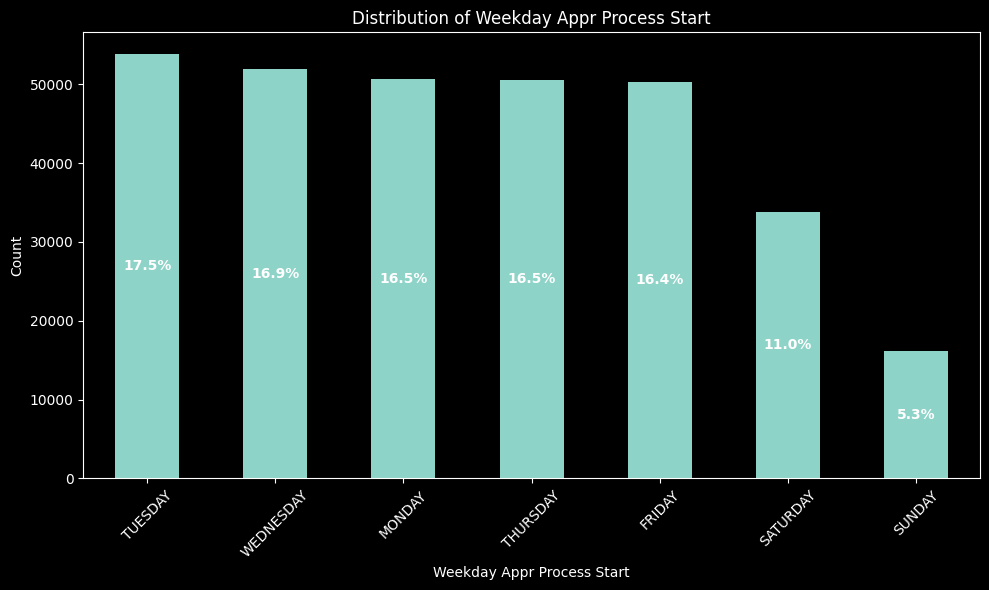

In [53]:
plot_categorical("WEEKDAY_APPR_PROCESS_START")


Cette colonne représente le jour de la semaine où la personne à contracté son prêt.

On pourrait se dire qu'à priori cette information ne nous aide pas à déterminer si un personne va rembourser son prêt ou non.

#### ORGANIZATION_TYPE

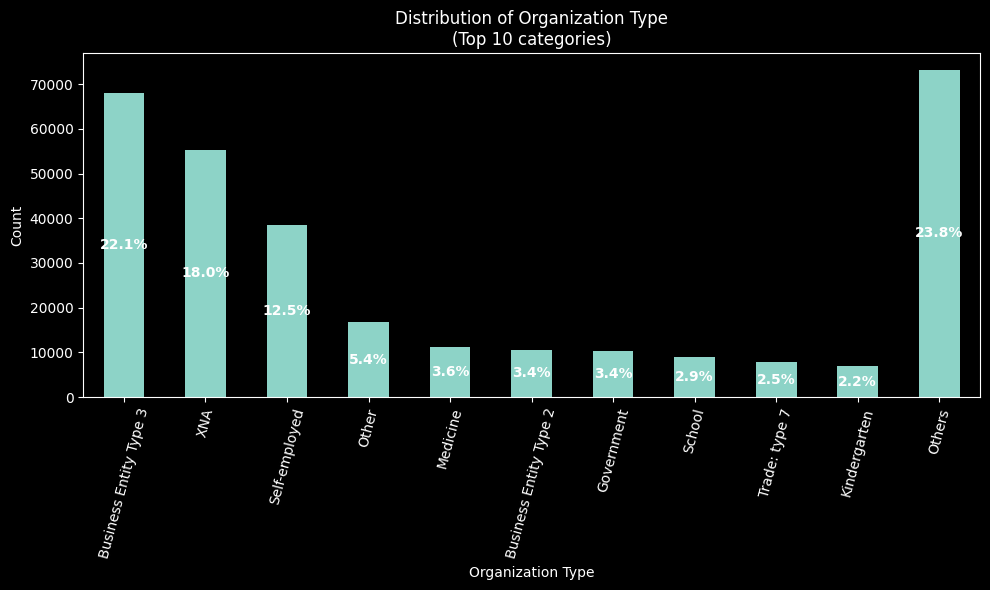

In [54]:
plot_categorical("ORGANIZATION_TYPE", top_n=10, rotation=75)


Cette colonne représente le type d'organisation dans laquelle travaille une personne.

Business entity type représente des types d'entreprises (comme par exemple les entreprises individuelles, les sociétés de personnes, les sociétés à responsabilité limitée, etc).

22.1% travaillent dans une entreprise de type 3, 12.5% sont des travailleurs indépendants.

On ne connait pas dans quelle type d'organisition travaille 18% des personnes.

#### HOUSETYPE_MODE

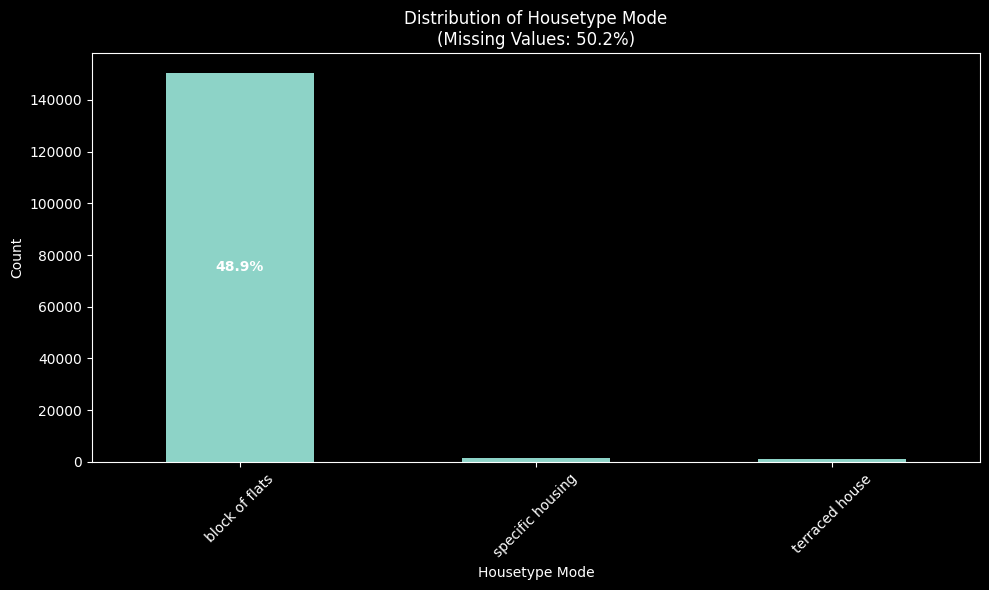

In [55]:
plot_categorical("HOUSETYPE_MODE")


Cette colonne représente le type d'habitation dans lequel une personne réside.

48% habitents dans des immeubles collectifs.

Attention, il y a plus de la moitié des valeurs qui sont vides.

#### WALLSMATERIAL_MODE

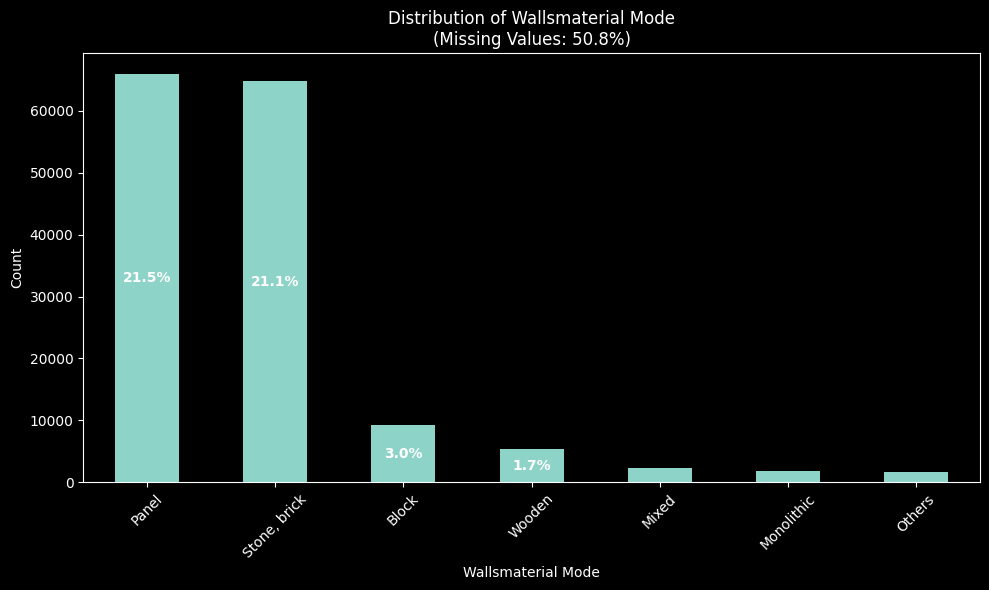

In [56]:
plot_categorical("WALLSMATERIAL_MODE")


Cette colonne représente le type de matériau des murs de l'habitation d'une personne.

21.5% sont des murs en panneaux ,  21.1% sont des murs en pierre ou en briques.

Attention, il y a plus de la moitié de valeurs vides.


#### REGION_RATING_CLIENT

Cette colonne représente le score de la région où vie une personne.

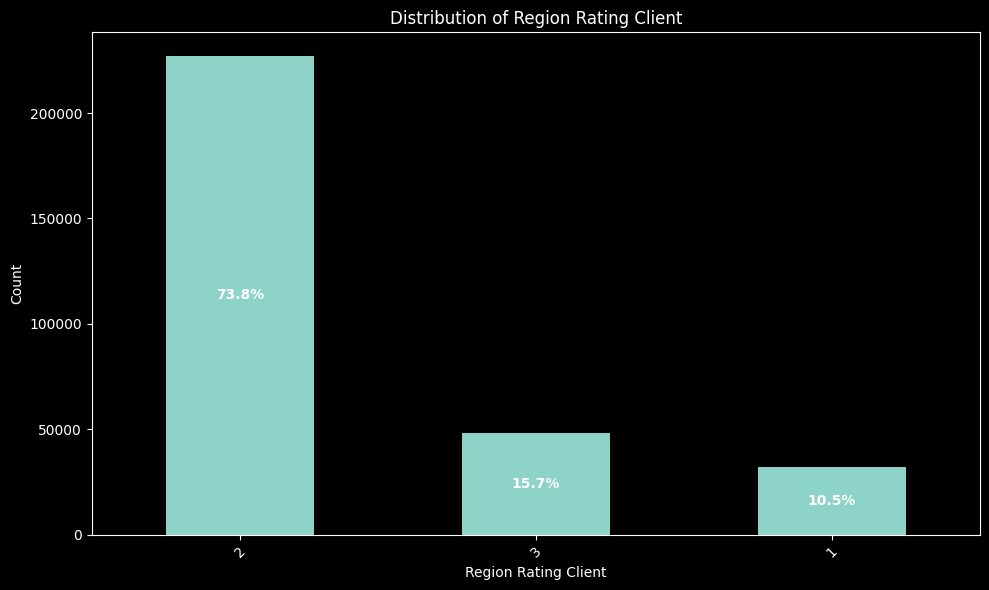

In [57]:
plot_categorical("REGION_RATING_CLIENT")


73.8% des personnes vivent dans une région avec une score de 2.

Le problème est que nous savons pas quel est le meilleur score entre 1 et 3 et aussi comment est construit ce score.

#### REGION_RATING_CLIENT_W_CITY

Cette colonne représente le score de la région où vie une personne, en prenant en compte ici la ville.

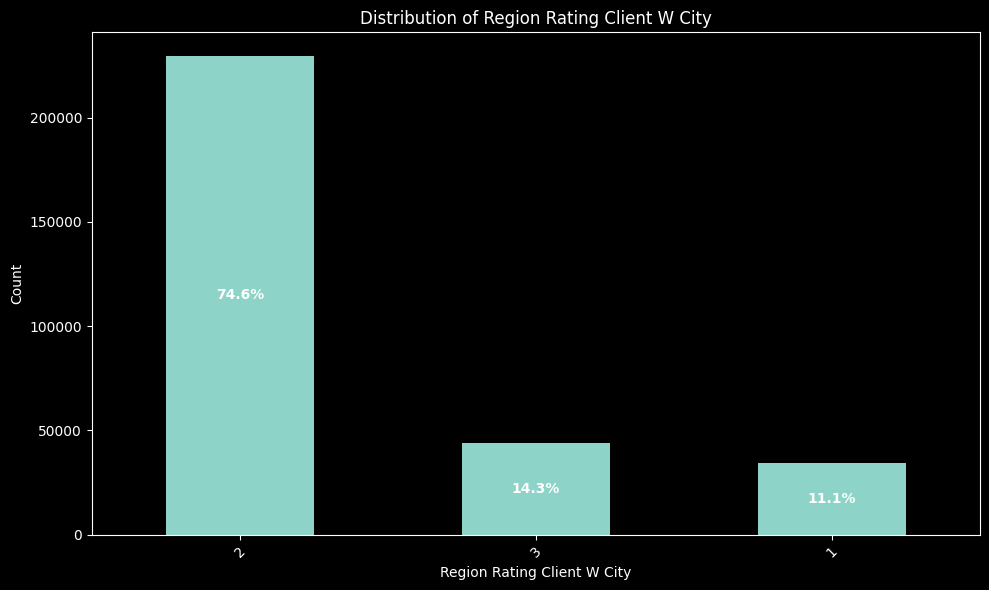

In [58]:
plot_categorical("REGION_RATING_CLIENT_W_CITY")


74.6% des personnes vivent dans une région avec une score de 2.

Le problème est que nous savons pas quel est le meilleur score entre 1 et 3 et aussi comment est construit ce score.

#### REG_REGION_NOT_LIVE_REGION

Cette colonne nous donne l'information si l'adresse permanente d'une personne correspond à l'adresse de contact de cette personne (au niveau de la région). 0 si c'est le cas, 1 sinon

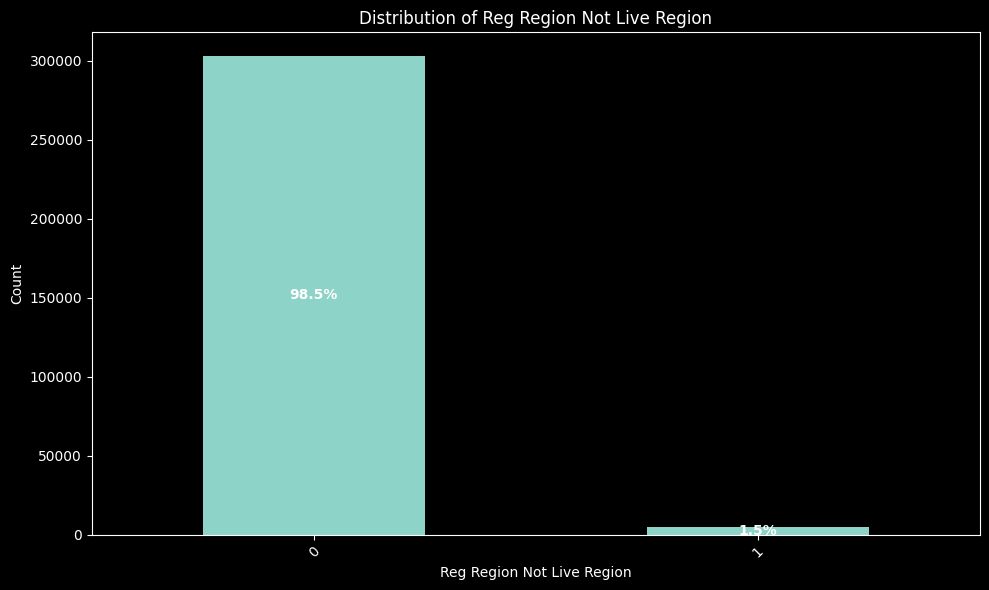

In [59]:
plot_categorical("REG_REGION_NOT_LIVE_REGION")


98.5 % des adresses sont les mêmes.

#### REG_CITY_NOT_LIVE_CITY

Cette colonne nous donne l'information si l'adresse permanente d'une personne correspond à l'adresse de contact de cette personne (au niveau de la ville). 0 si c'est le cas, 1 sinon

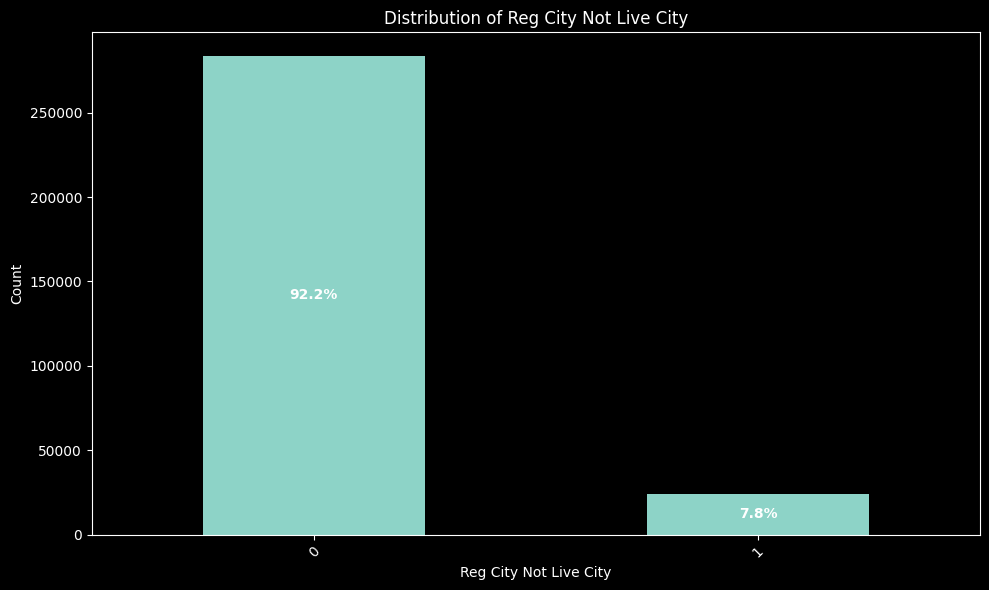

In [60]:
plot_categorical("REG_CITY_NOT_LIVE_CITY")


92.2 % des adresses sont les mêmes.

### Corrélation

In [ ]:
df_corr = data.copy()
le_count = 0

for col in df_corr.columns:
    if df_corr[col].dtype == "object":
        if df_corr[col].nunique() <= 2:
            print(f"Encoding {df_corr[col].name} column")
            le = LabelEncoder()
            df_corr[col] = le.fit_transform(df_corr[col])
            le_count += 1

print(f"{le_count} columns were label encoded.")


Encoding NAME_CONTRACT_TYPE column
Encoding FLAG_OWN_CAR column
Encoding FLAG_OWN_REALTY column
Encoding EMERGENCYSTATE_MODE column
4 columns were label encoded.


In [ ]:
# One-hot encoding
df_corr = pd.get_dummies(df_corr)

print("Correlation DataFrame features shape: ", df_corr.shape)


Correlation DataFrame features shape:  (307511, 243)


In [ ]:
# Find correlations with the target and sort
correlations = df_corr.corr()["TARGET"].sort_values()

# Display correlations
print("Most Positive Correlations:\n", correlations.tail(15))
print("\nMost Negative Correlations:\n", correlations.head(15))


Most Positive Correlations:
 OWN_CAR_AGE                                          0.037612
EMERGENCYSTATE_MODE                                  0.041955
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

#### AGE

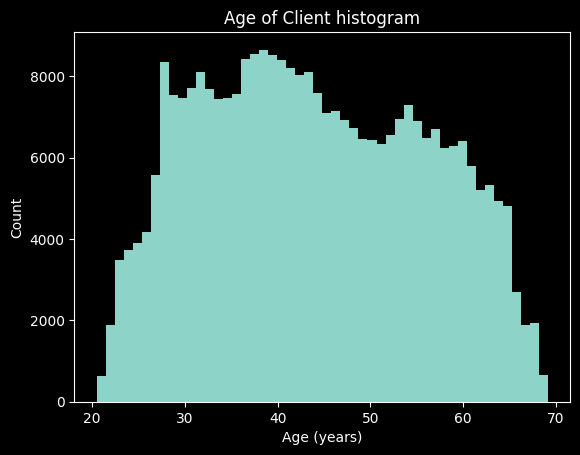

In [ ]:
# Plot the distribution of ages in years
plt.hist(df_corr["AGE"], bins=50)
plt.title("Age of Client histogram")
plt.xlabel("Age (years)")
plt.ylabel("Count");


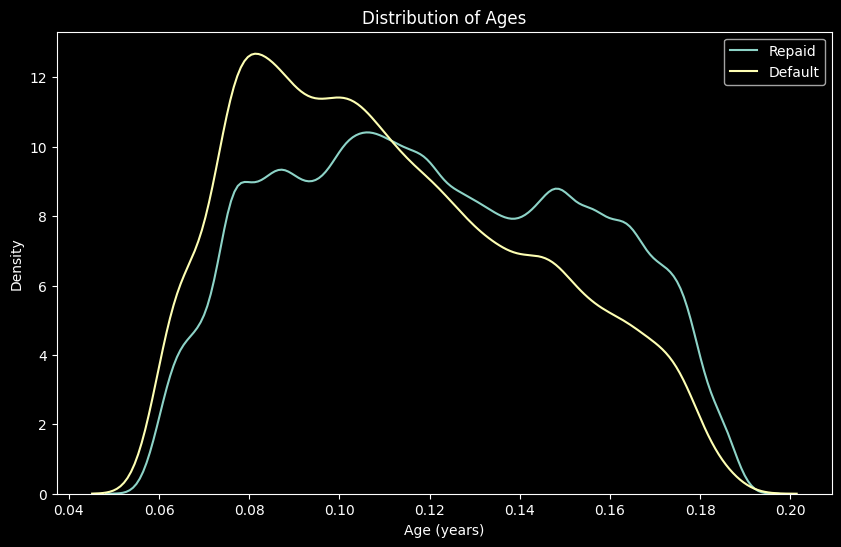

In [ ]:
plt.figure(figsize=(10, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_corr.loc[df_corr["TARGET"] == 0, "AGE"] / 365, label="Repaid")

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_corr.loc[df_corr["TARGET"] == 1, "AGE"] / 365, label="Default")

# Labeling of plot
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Ages");


Même si la corrélation n'est pas très importante (-0.078), la colonne AGE est utile pour différencier les personnes qui remboursent leur crédit et celles qui ne le font pas.

In [ ]:
# Age information into a separate dataframe
age_data = df_corr.copy()
age_data = age_data[["TARGET", "AGE"]]

# Bin the age data
age_data["AGE_BINNED"] = pd.cut(
    age_data["AGE"], bins=np.linspace(20, 70, num=11)
)
age_data.head(10)


TARGET        AGE    AGE_BINNED
0       1  25.920548  (25.0, 30.0]
1       0  45.931507  (45.0, 50.0]
2       0  52.180822  (50.0, 55.0]
3       0  52.068493  (50.0, 55.0]
4       0  54.608219  (50.0, 55.0]
5       0  46.413699  (45.0, 50.0]
6       0  37.747945  (35.0, 40.0]
7       0  51.643836  (50.0, 55.0]
8       0  55.065753  (55.0, 60.0]
9       0  39.641096  (35.0, 40.0]

In [ ]:
# Group by the bin and calculate averages
age_groups = age_data.groupby("AGE_BINNED", observed=False).mean()
age_groups


TARGET        AGE
AGE_BINNED                       
(20.0, 25.0]  0.123036  23.377522
(25.0, 30.0]  0.111436  27.822518
(30.0, 35.0]  0.102814  32.479037
(35.0, 40.0]  0.089414  37.555913
(40.0, 45.0]  0.078491  42.459346
(45.0, 50.0]  0.074171  47.462741
(50.0, 55.0]  0.066968  52.593136
(55.0, 60.0]  0.055314  57.491131
(60.0, 65.0]  0.052737  62.412459
(65.0, 70.0]  0.037270  66.555108

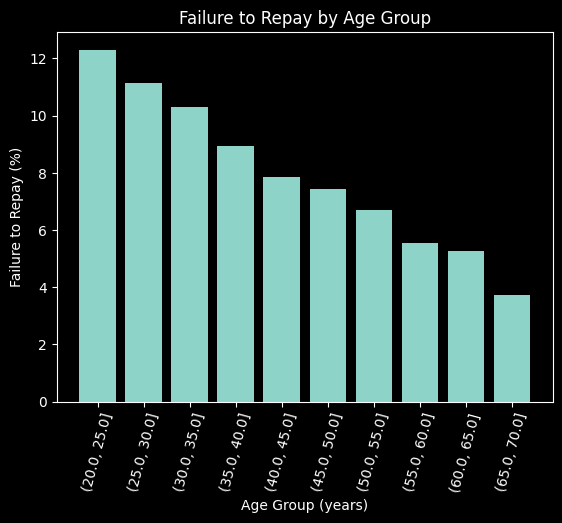

In [ ]:
# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups["TARGET"])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel("Age Group (years)")
plt.ylabel("Failure to Repay (%)")
plt.title("Failure to Repay by Age Group");


Cela confirme ce qu'on a vu avant : les personnes les plus jeunes ont tendance à moins rembourser leur crédit que les personnes les plus âgées.

#### DAYS_EMPLOYED

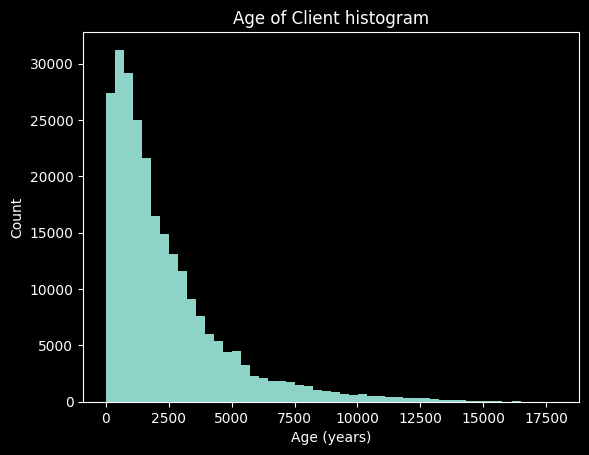

In [ ]:
# Plot the distribution of ages in years
plt.hist(df_corr["DAYS_EMPLOYED"], bins=50)
plt.title("Age of Client histogram")
plt.xlabel("Age (years)")
plt.ylabel("Count");


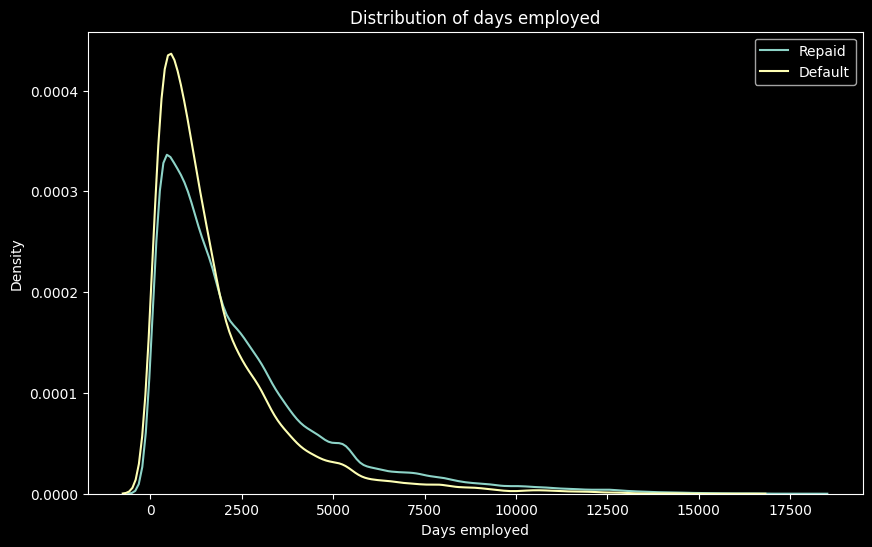

In [ ]:
plt.figure(figsize=(10, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(
    df_corr.loc[df_corr["TARGET"] == 0, "DAYS_EMPLOYED"], label="Repaid"
)

# KDE plot of loans which were not repaid on time
sns.kdeplot(
    df_corr.loc[df_corr["TARGET"] == 1, "DAYS_EMPLOYED"], label="Default"
)

# Labeling of plot
plt.xlabel("Days employed")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of days employed");


Même si la corrélation n'est pas très importante (-0.074), la colonne DAYS_EMPLOYED semble être utile pour différencier les personnes qui remboursent leur crédit et celles qui ne le font pas. Les personnes qui ont commencé leur travail plus récement semble avoir plus de mal à rembourser leur crédit.

In [ ]:
# Age information into a separate dataframe
age_data = df_corr.copy()
age_data = age_data[["TARGET", "DAYS_EMPLOYED"]]

# Bin the age data
age_data["DAYS_EMPLOYED_BINNED"] = pd.cut(
    age_data["DAYS_EMPLOYED"], bins=np.linspace(0, 10000, num=11)
)
age_data.head(10)


TARGET  DAYS_EMPLOYED DAYS_EMPLOYED_BINNED
0       1          637.0        (0.0, 1000.0]
1       0         1188.0     (1000.0, 2000.0]
2       0          225.0        (0.0, 1000.0]
3       0         3039.0     (3000.0, 4000.0]
4       0         3038.0     (3000.0, 4000.0]
5       0         1588.0     (1000.0, 2000.0]
6       0         3130.0     (3000.0, 4000.0]
7       0          449.0        (0.0, 1000.0]
8       0            NaN                  NaN
9       0         2019.0     (2000.0, 3000.0]

In [ ]:
# Group by the bin and calculate averages
days_employed_groups = age_data.groupby(
    "DAYS_EMPLOYED_BINNED", observed=False
).mean()
days_employed_groups


TARGET  DAYS_EMPLOYED
DAYS_EMPLOYED_BINNED                         
(0.0, 1000.0]         0.111502     519.390177
(1000.0, 2000.0]      0.095382    1458.021055
(2000.0, 3000.0]      0.075016    2476.305926
(3000.0, 4000.0]      0.064962    3449.239307
(4000.0, 5000.0]      0.056155    4466.211630
(5000.0, 6000.0]      0.052199    5426.953555
(6000.0, 7000.0]      0.048384    6481.014263
(7000.0, 8000.0]      0.047019    7468.704612
(8000.0, 9000.0]      0.049126    8452.525223
(9000.0, 10000.0]     0.037255    9468.793137

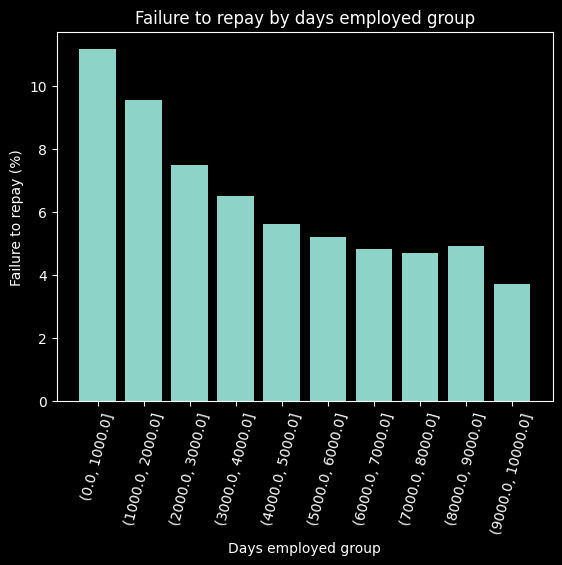

In [ ]:
# Graph the age bins and the average of the target as a bar plot
plt.bar(
    days_employed_groups.index.astype(str), 100 * days_employed_groups["TARGET"]
)

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel("Days employed group")
plt.ylabel("Failure to repay (%)")
plt.title("Failure to repay by days employed group");


Cela confirme ce qu'on a vu avant : les personnes qui ont commencé leur travail plus récemment ont tendance à moins rembourser leur crédit que les autres.

#### Plot all

Plotting distributions for 109 numeric columns...


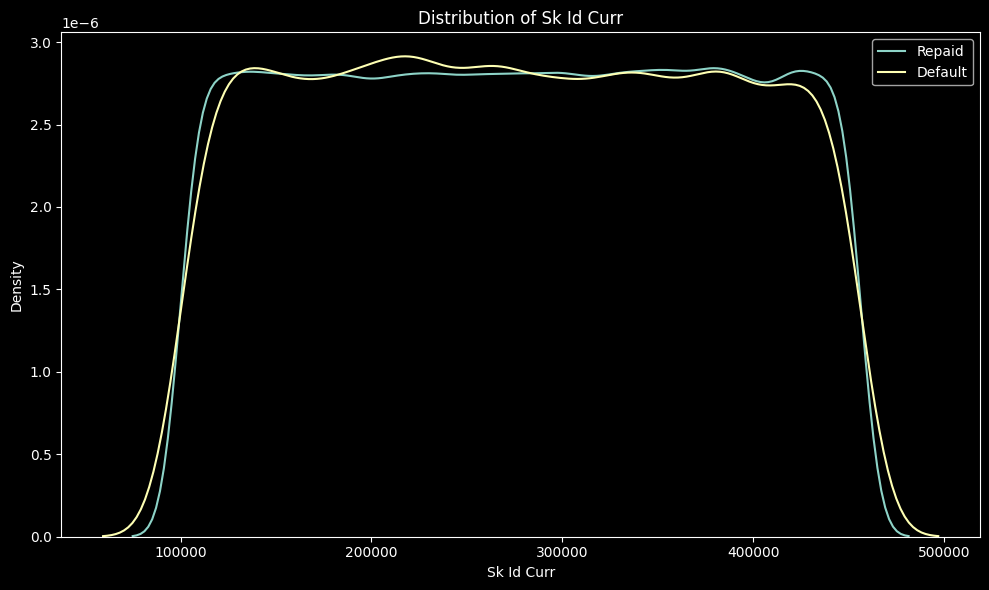

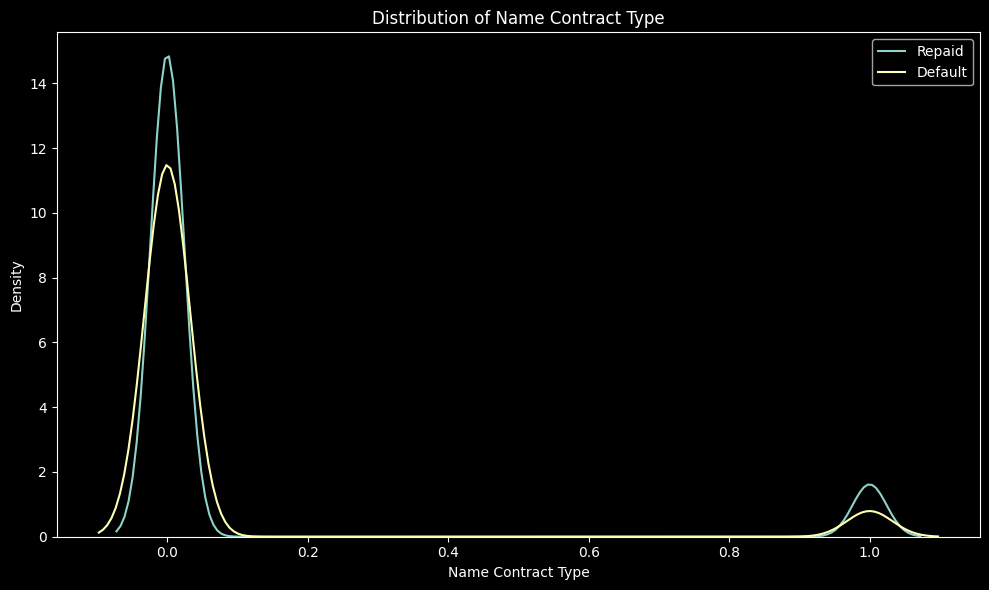

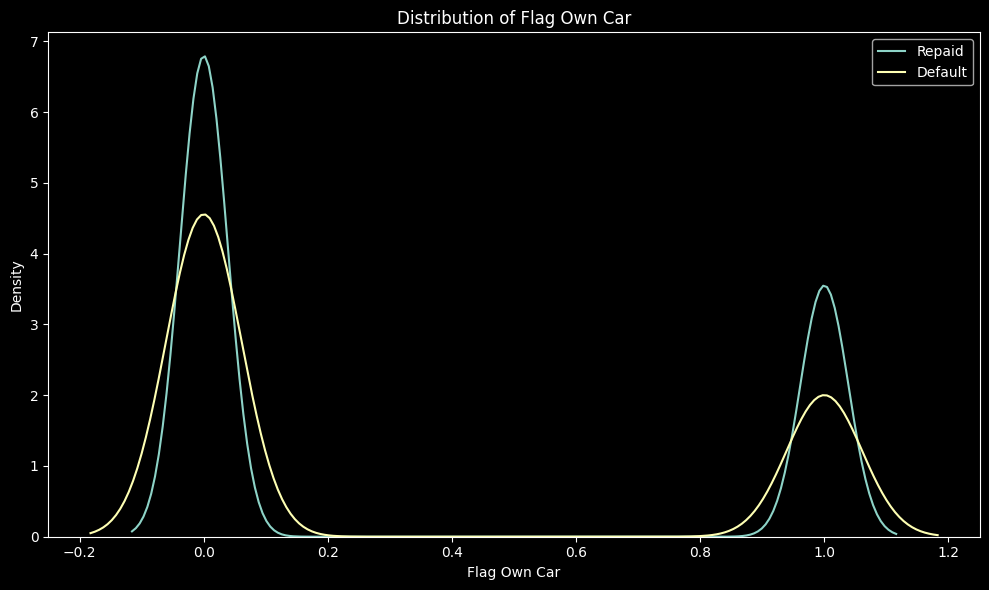

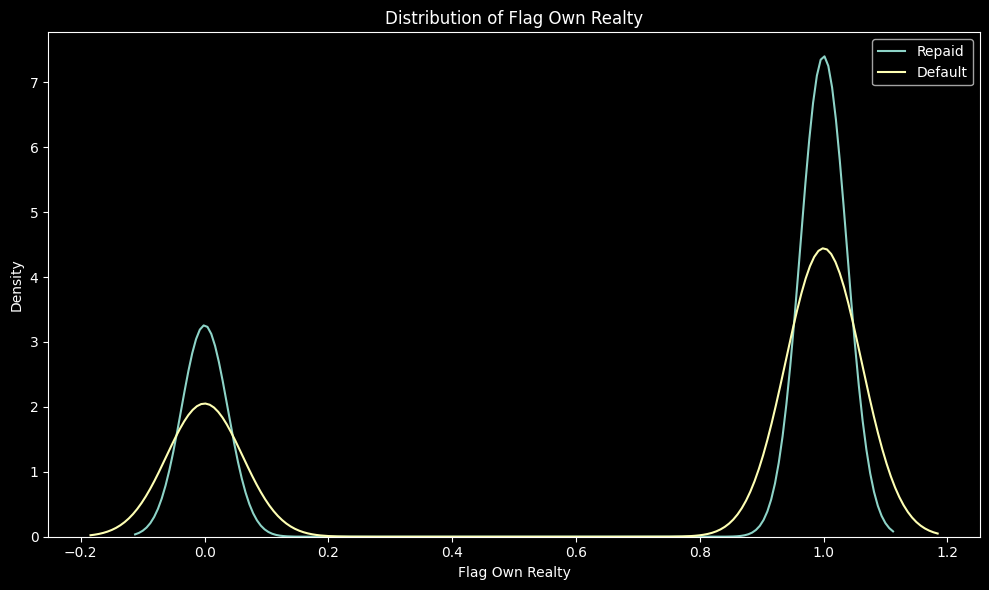

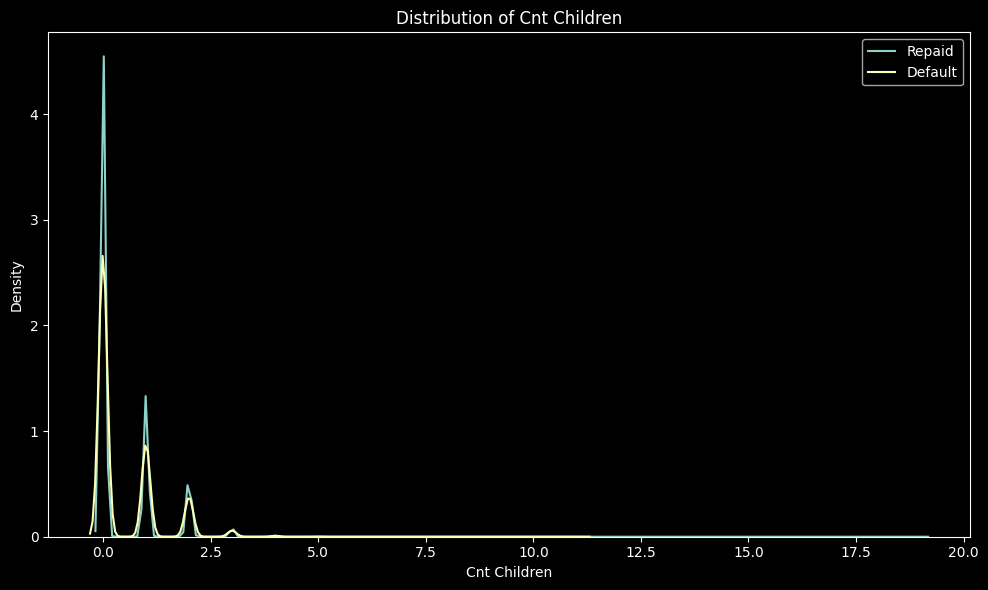

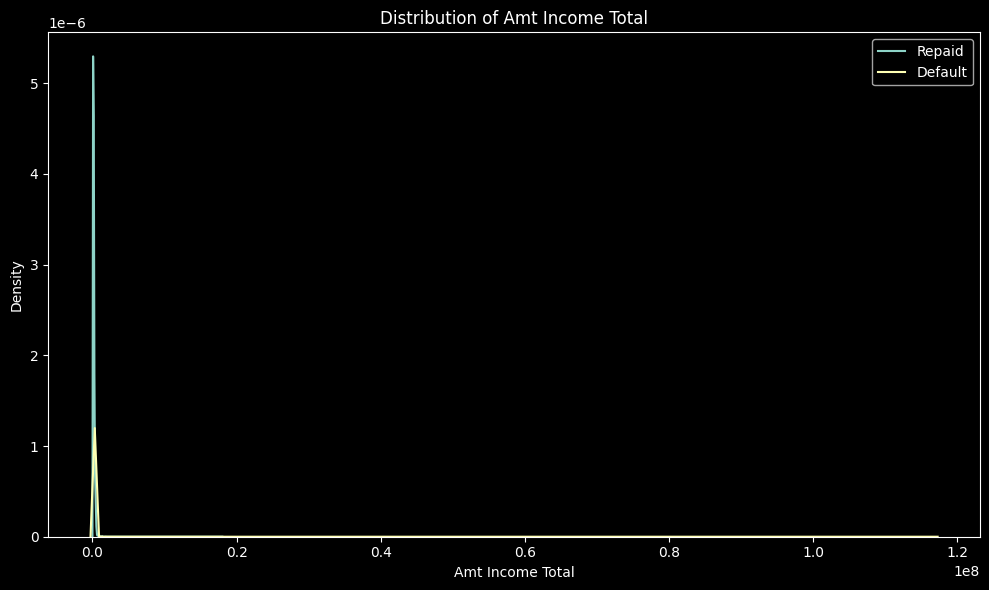

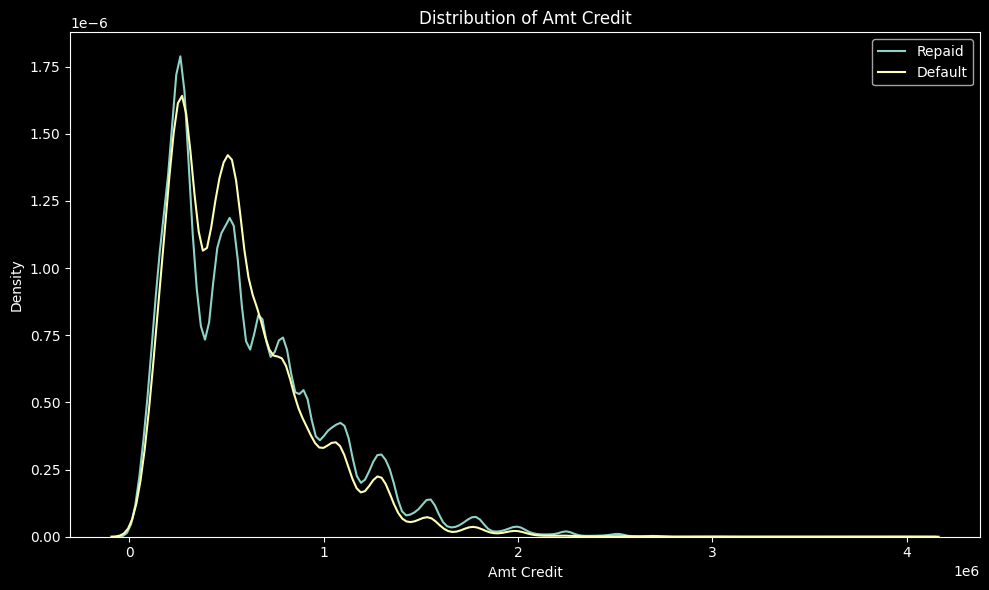

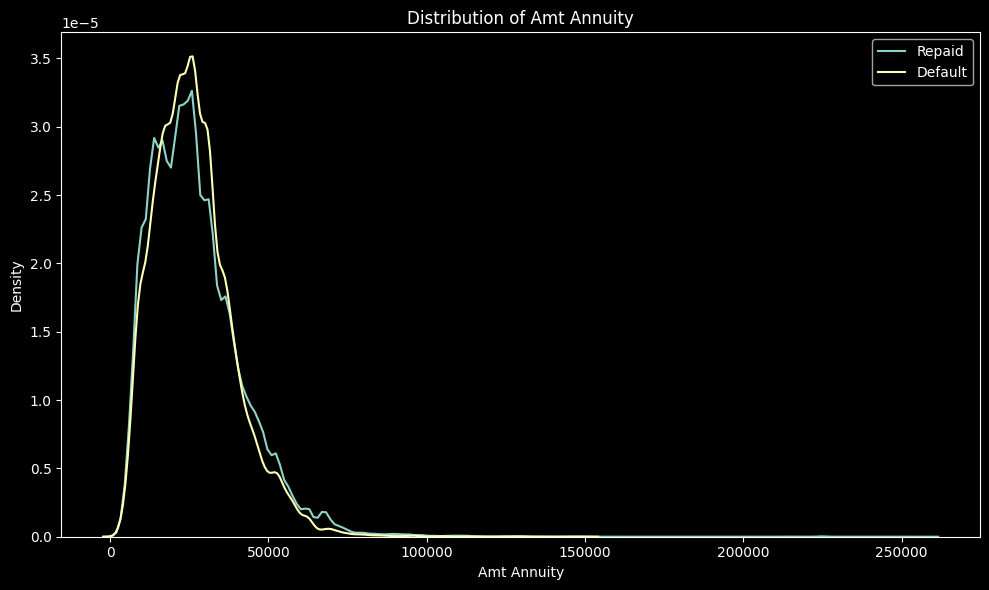

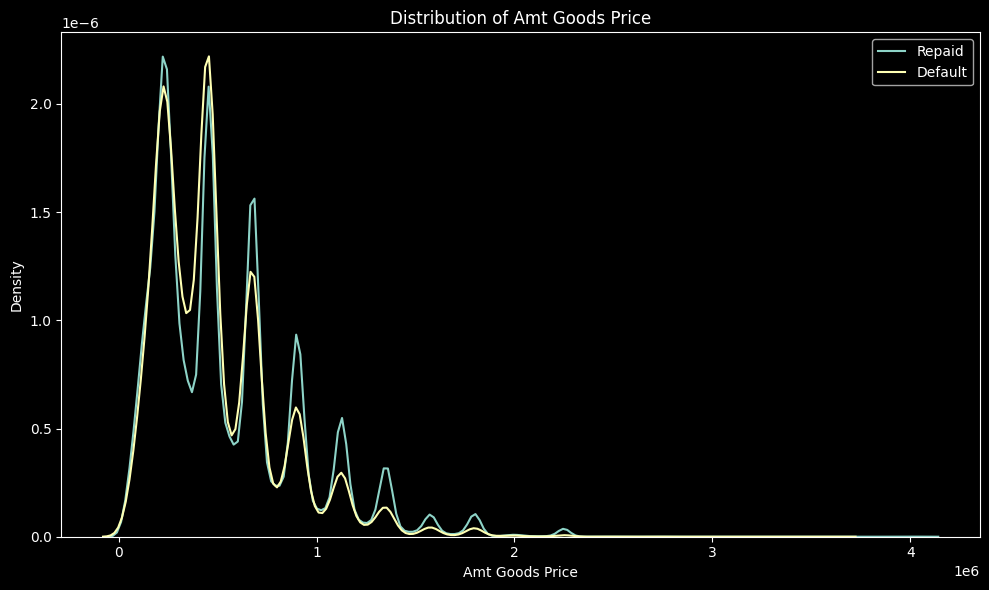

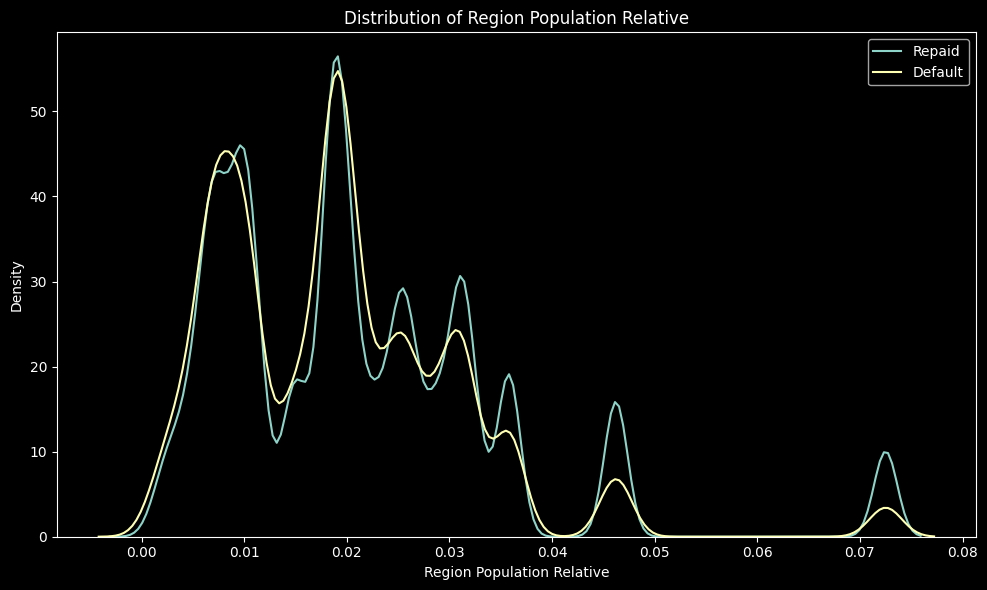

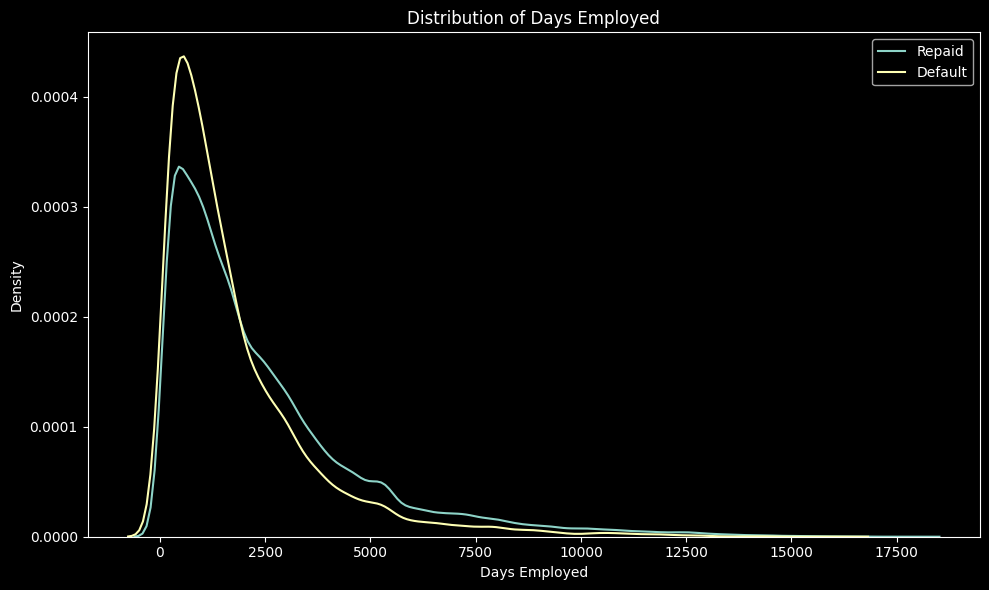

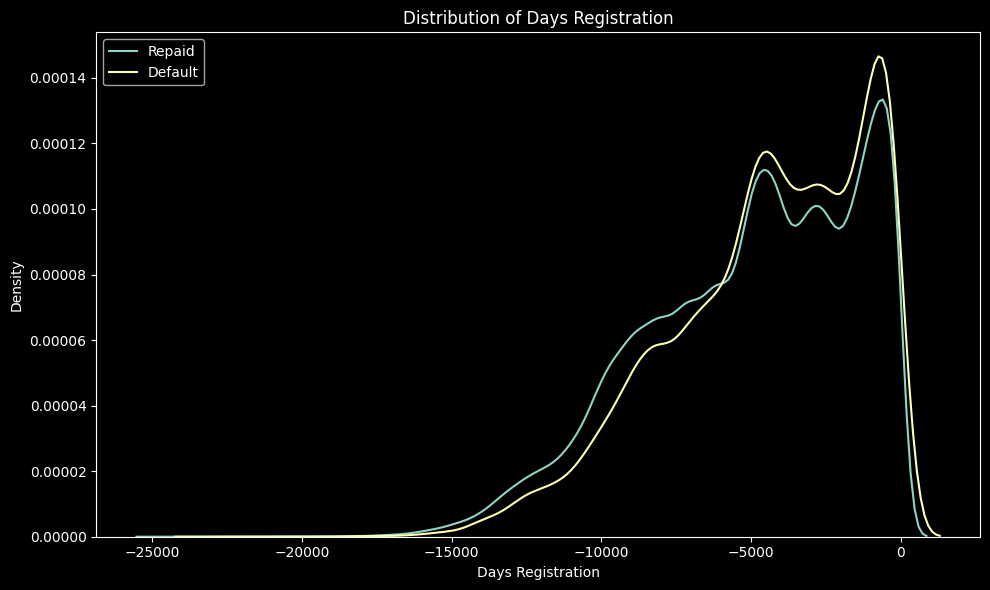

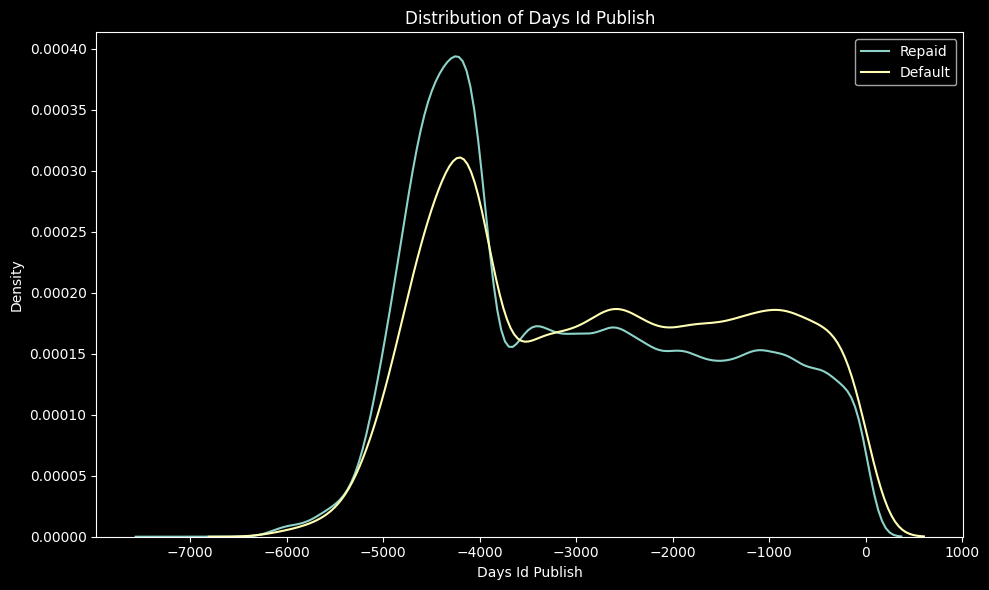

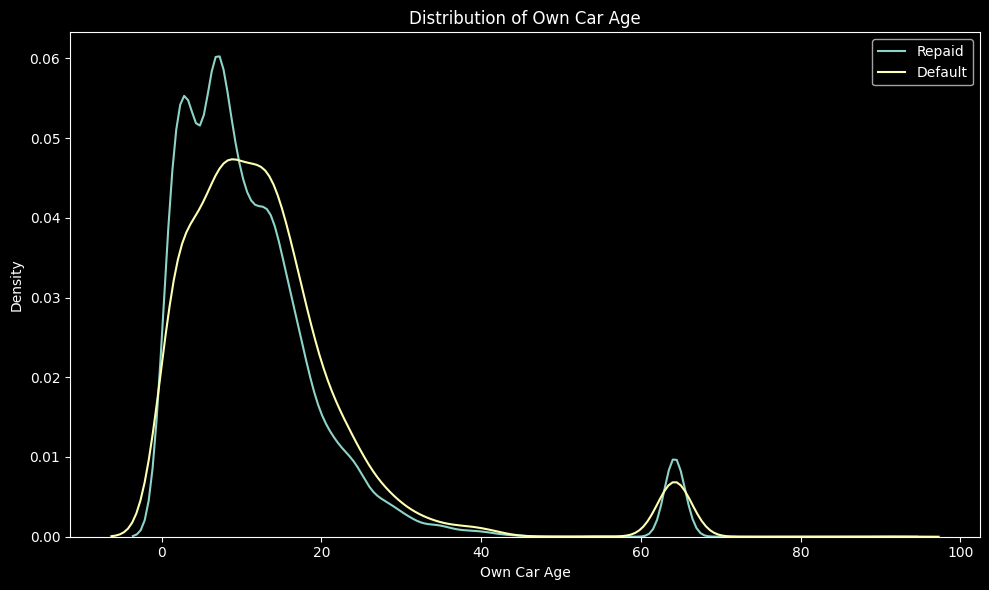

/var/folders/jw/7s6k1pd17nj7rvp321jl59sm0000gn/T/ipykernel_63109/2334096669.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["TARGET"] == 1, column], label="Default")


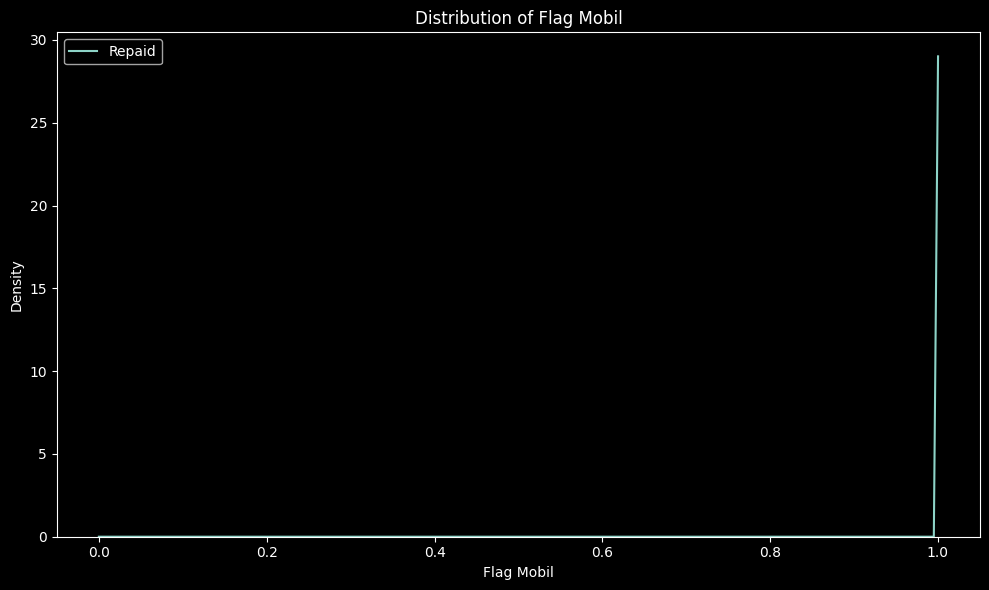

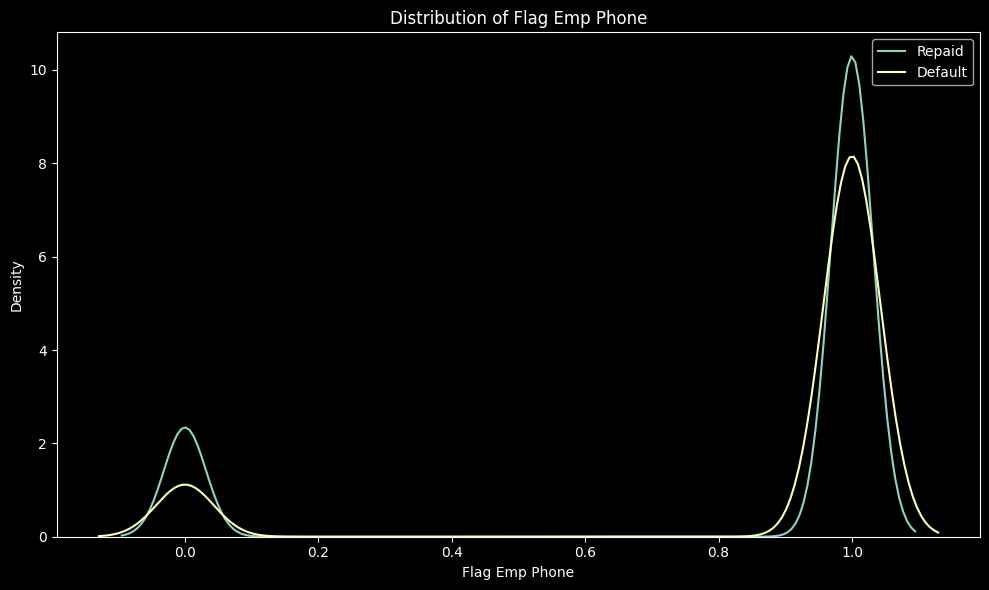

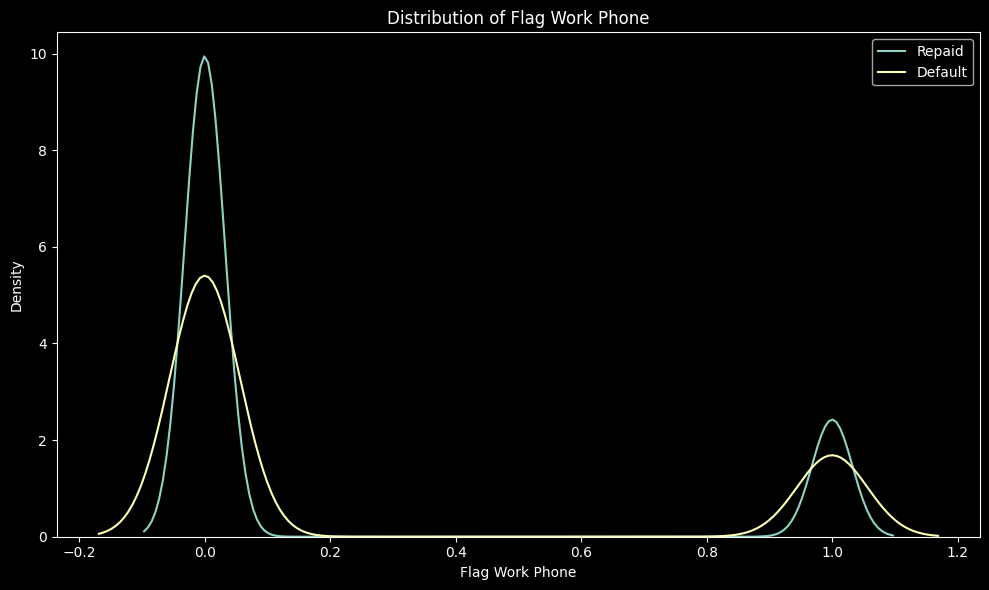

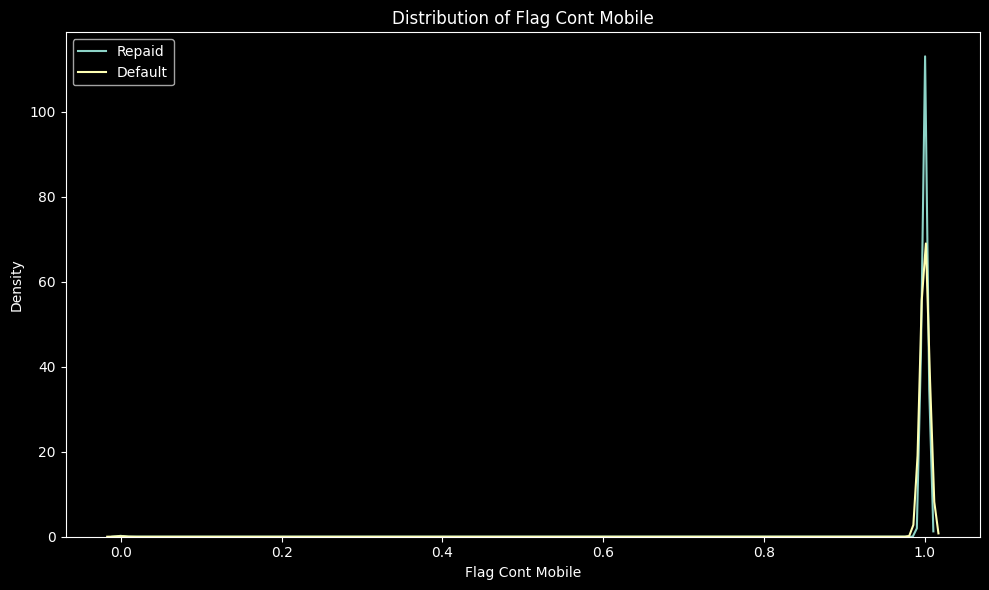

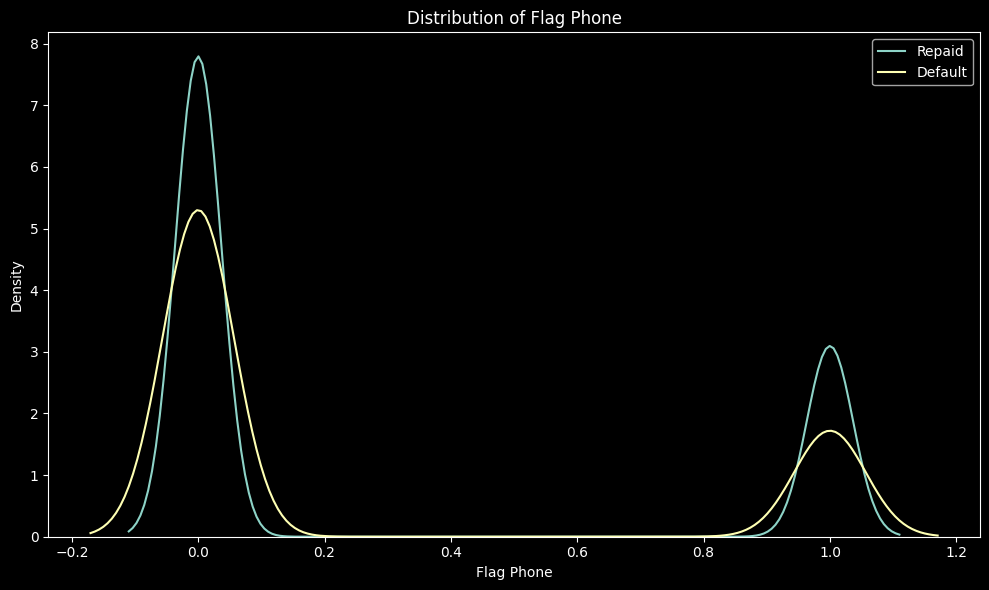

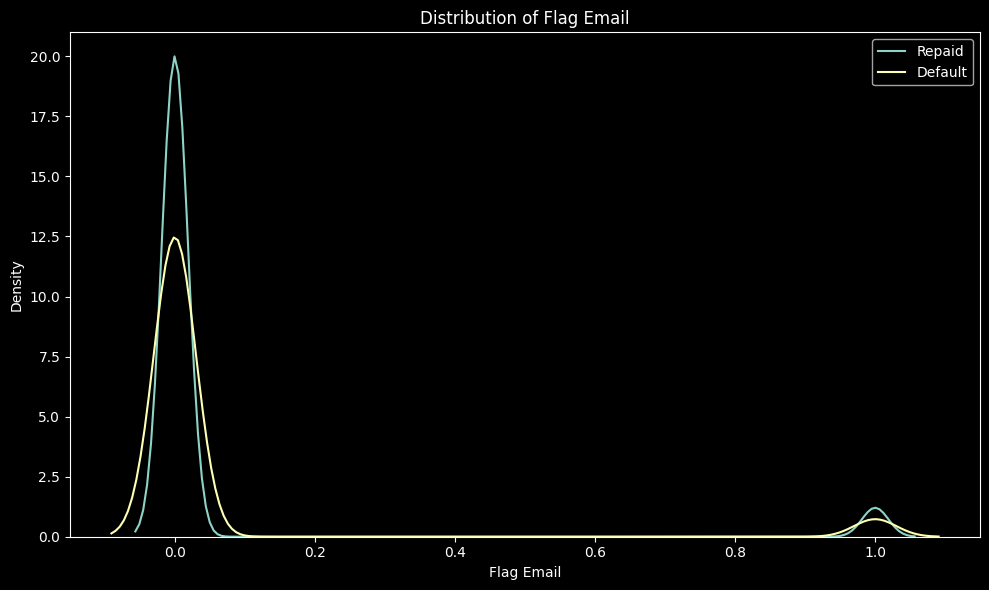

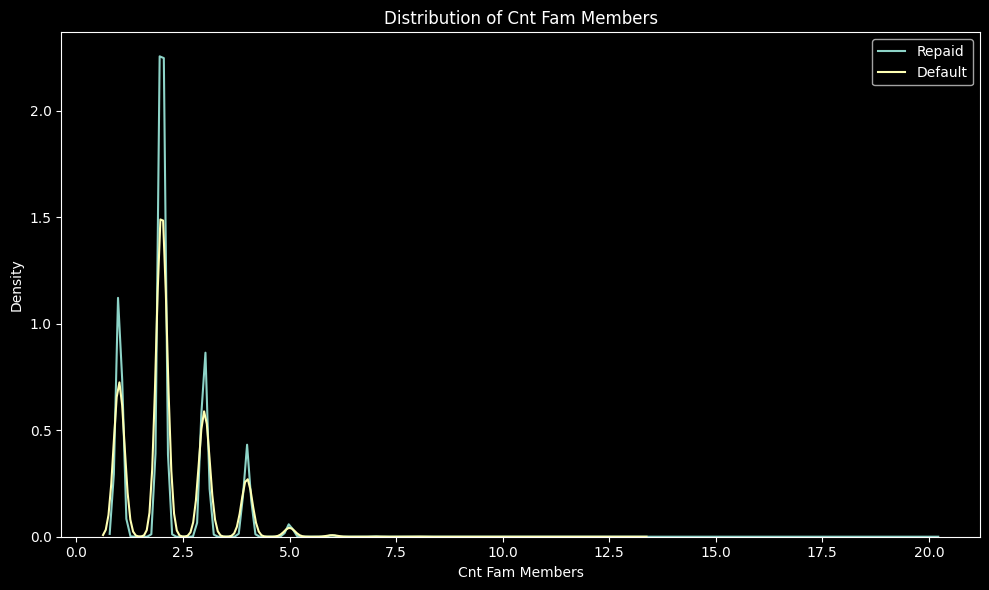

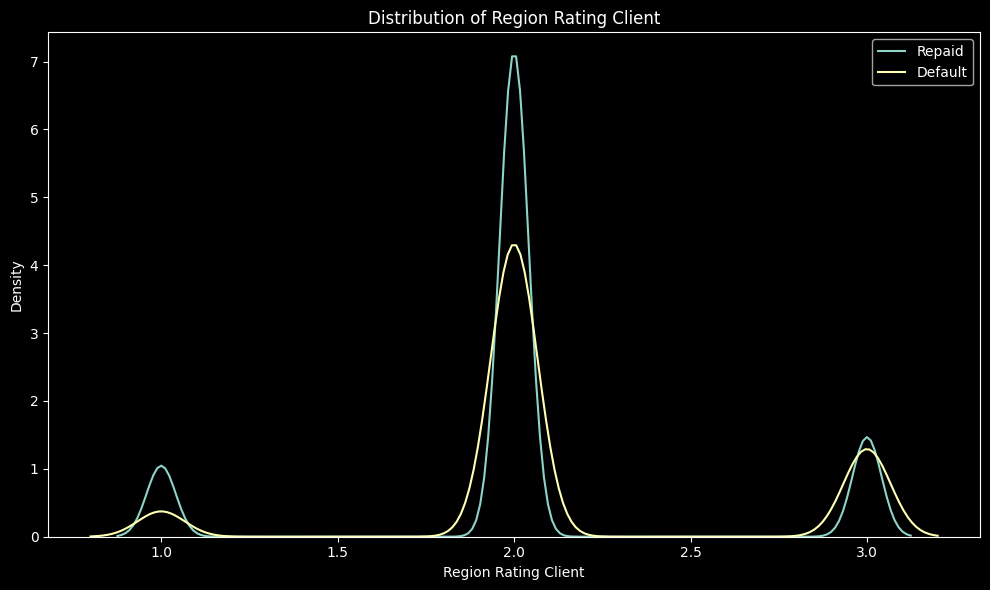

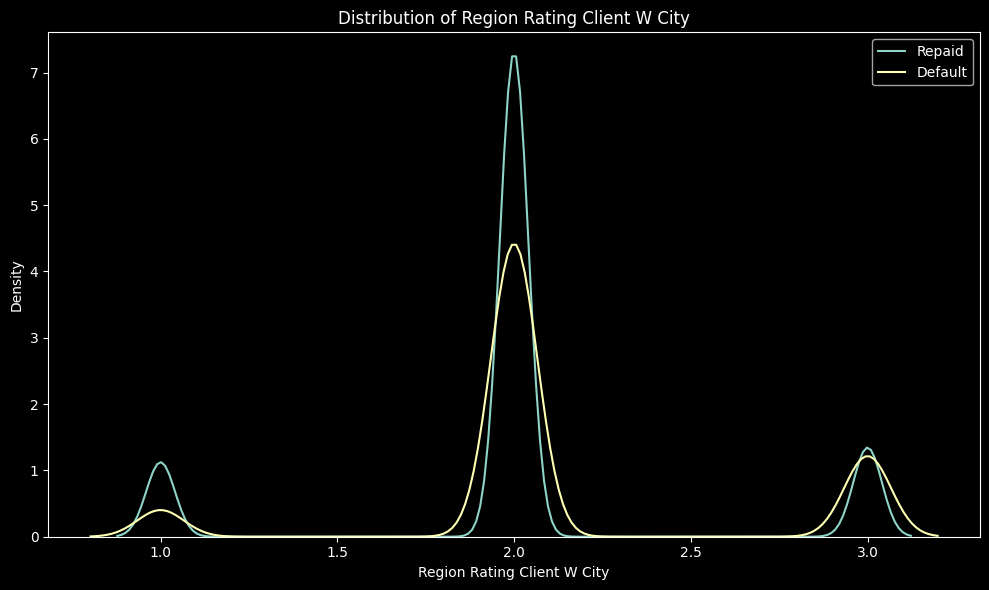

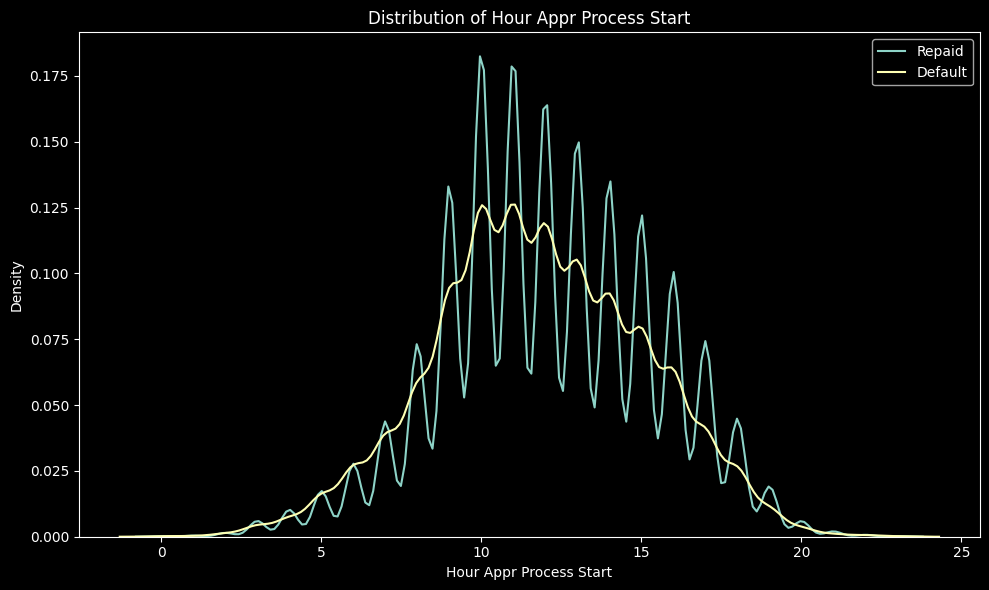

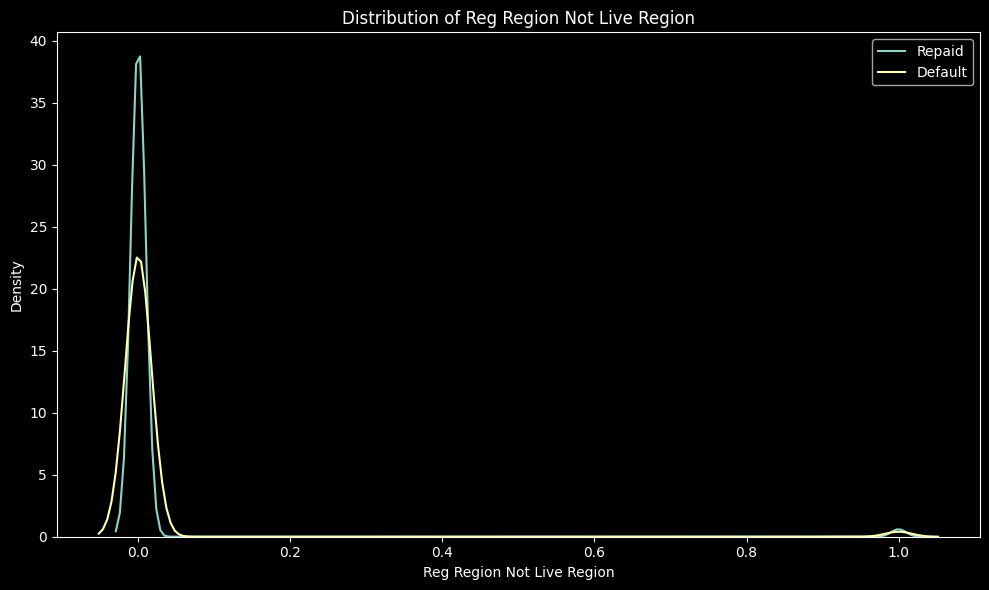

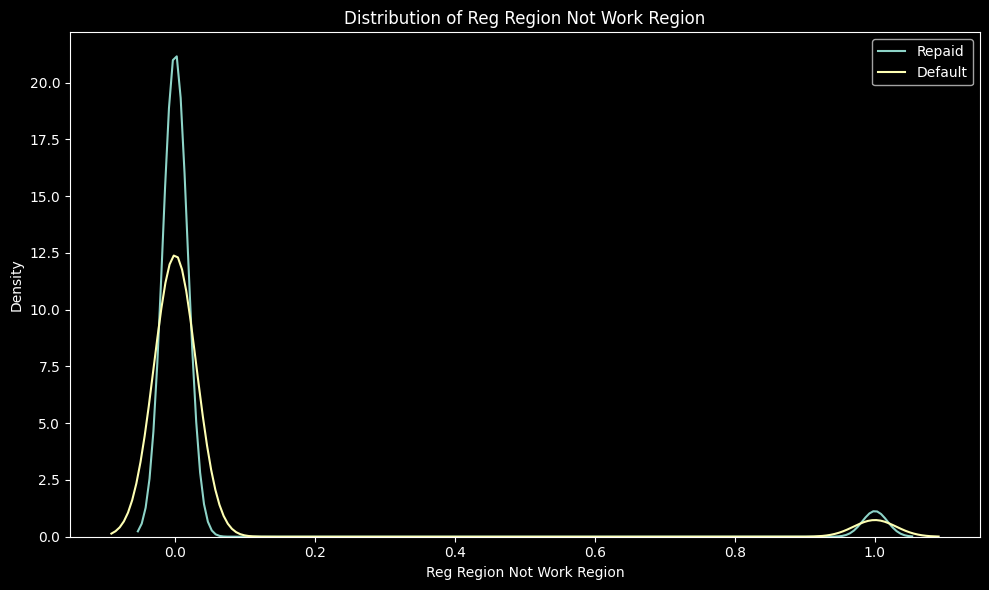

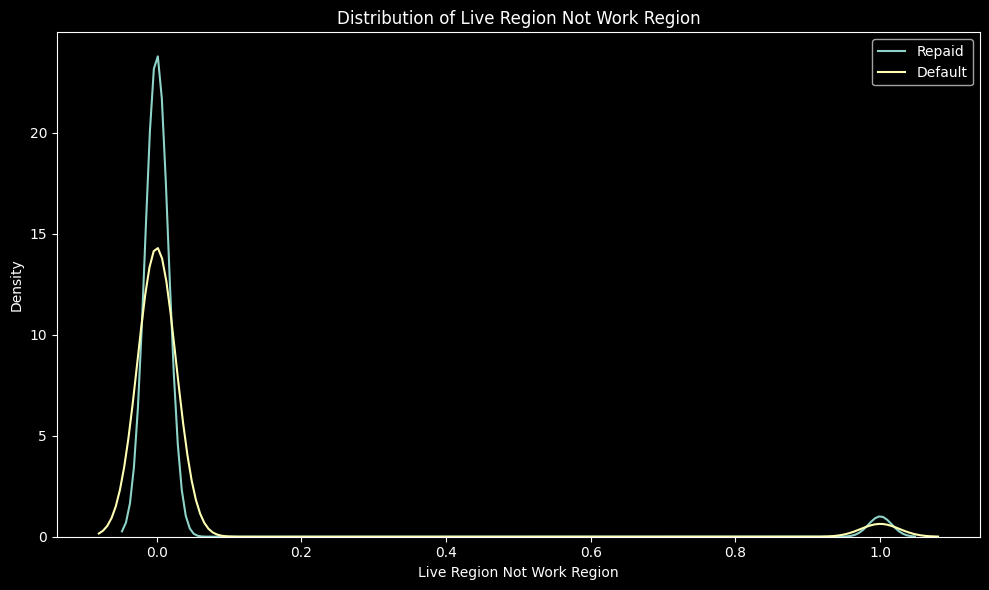

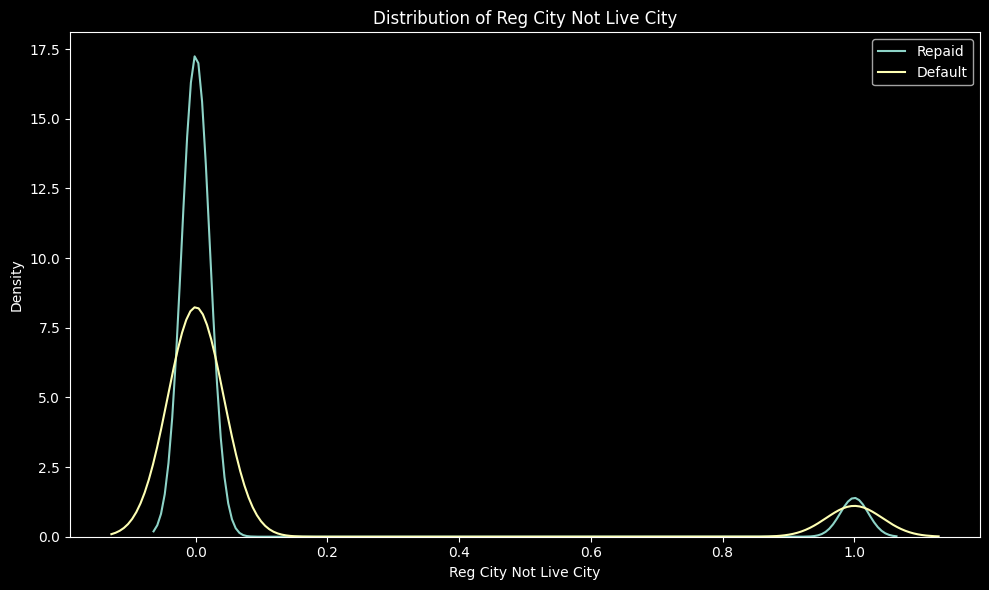

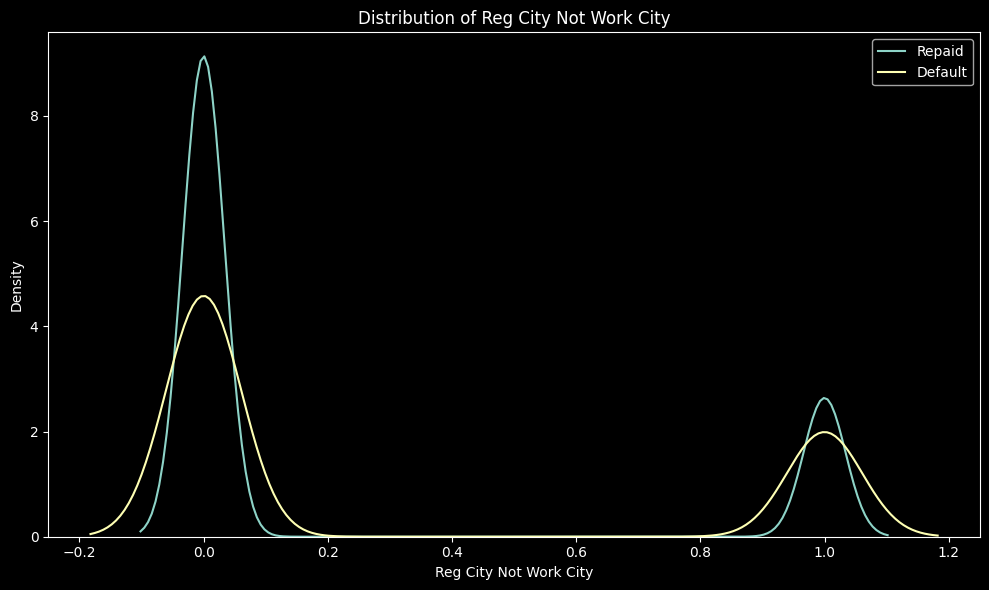

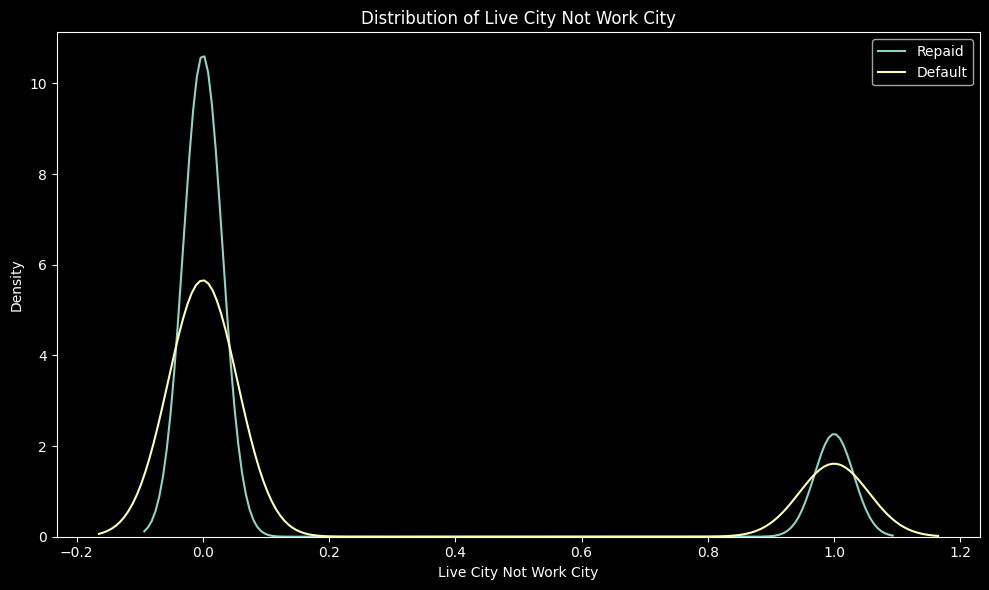

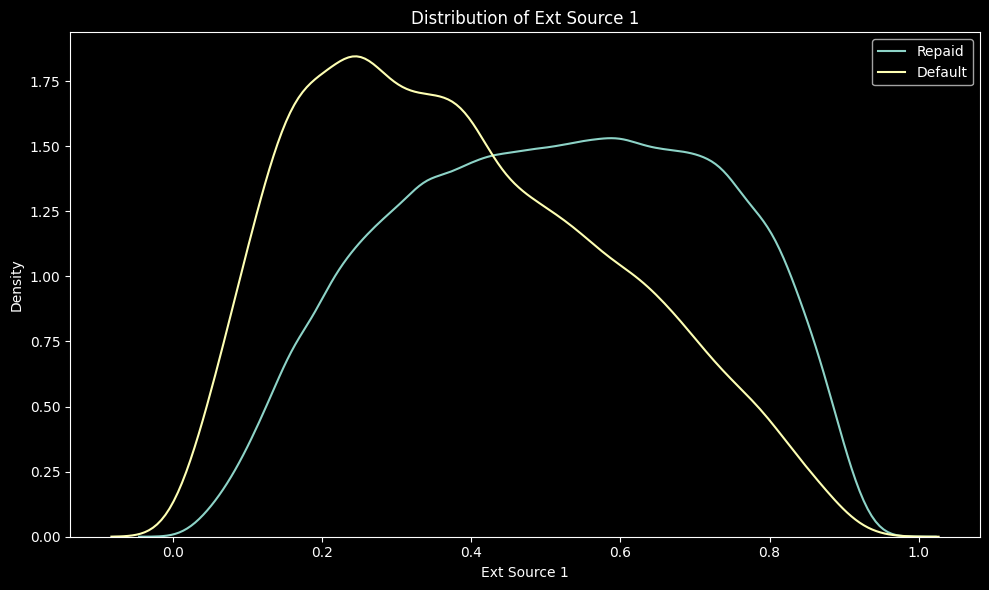

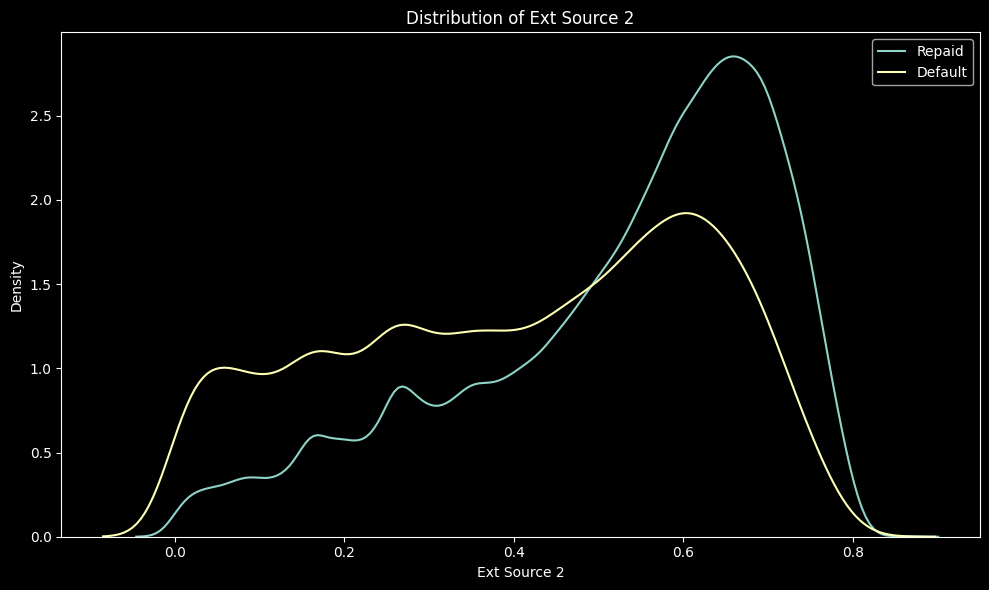

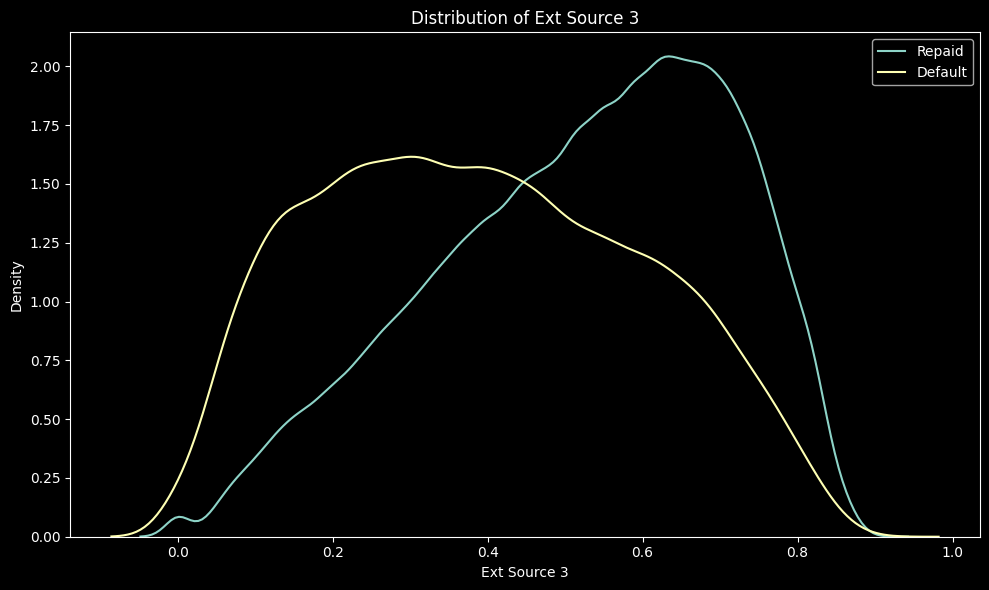

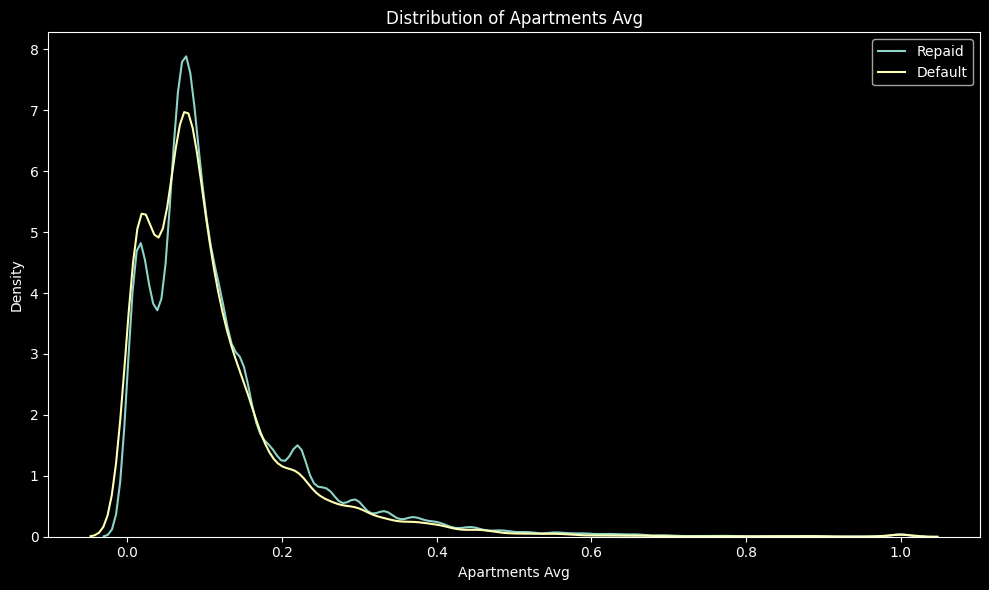

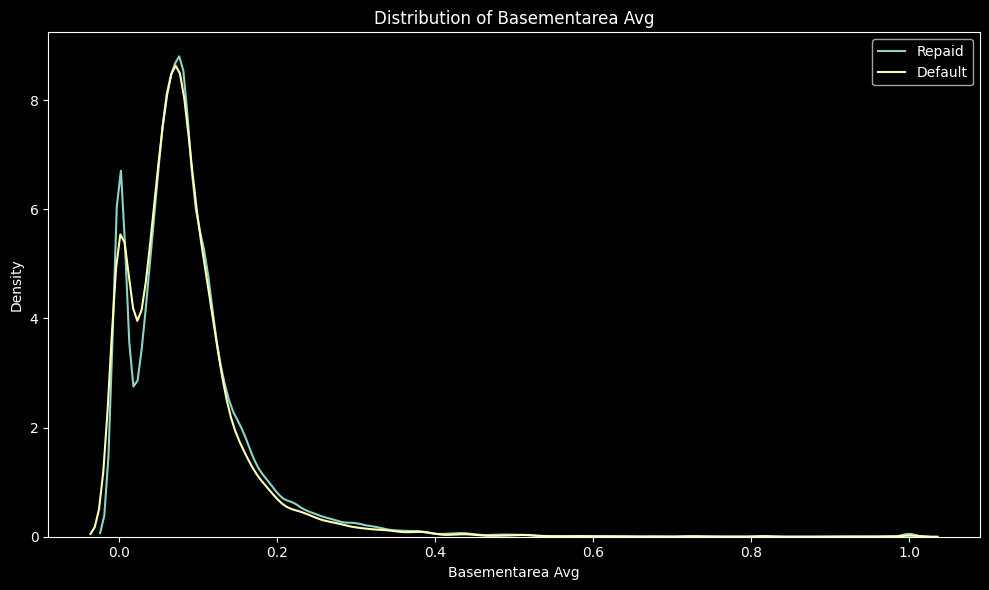

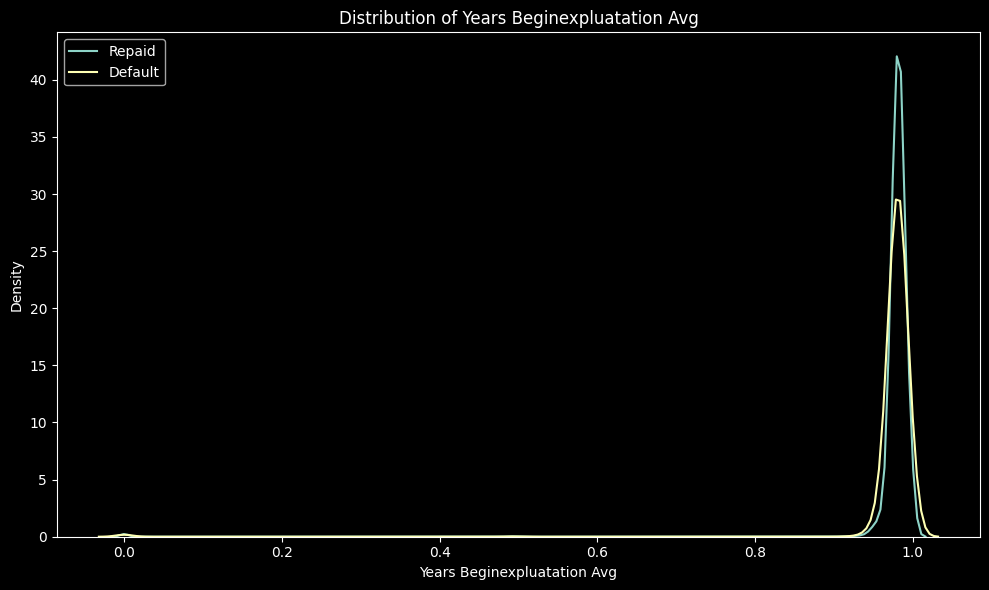

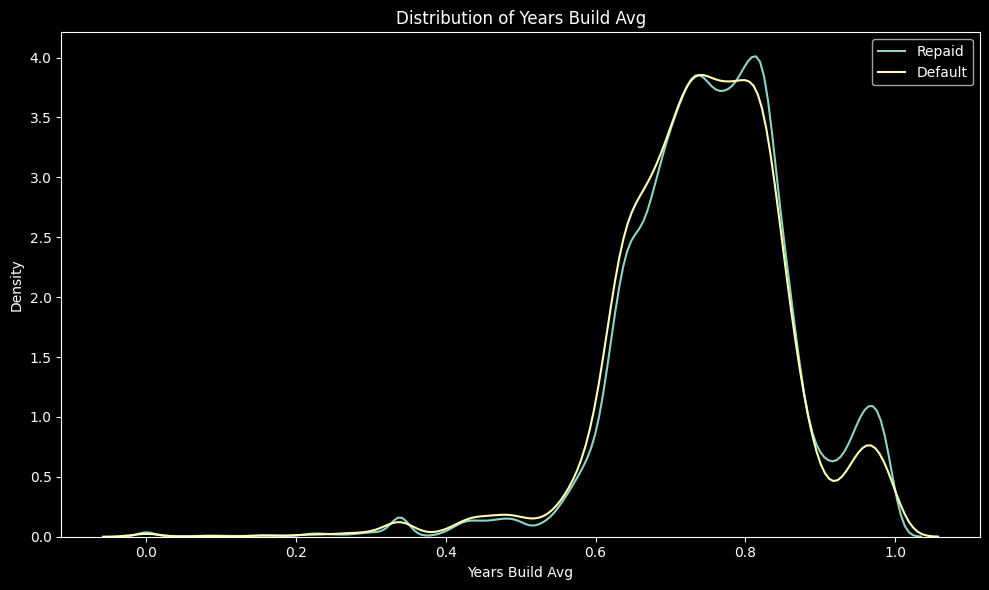

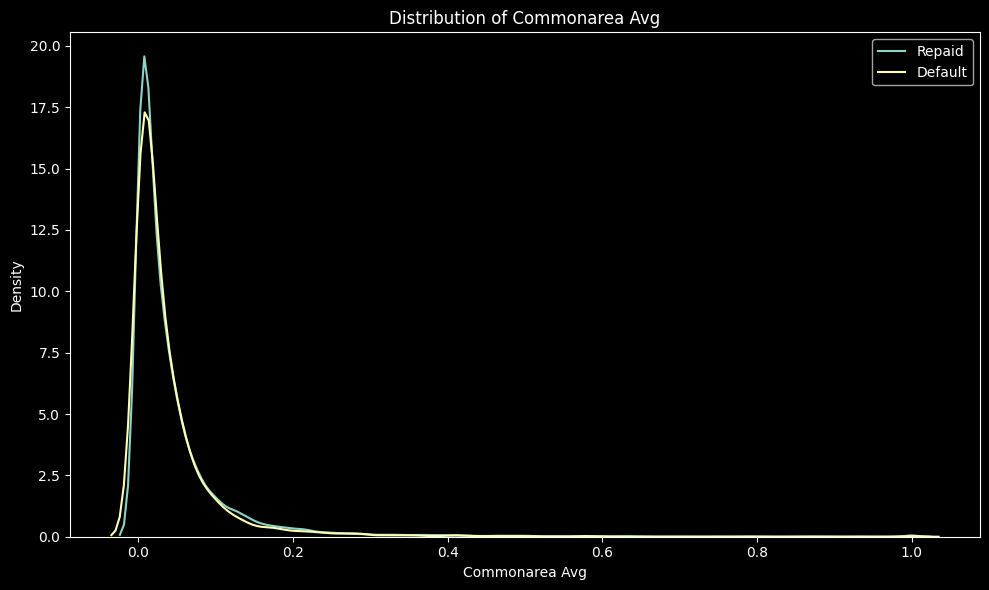

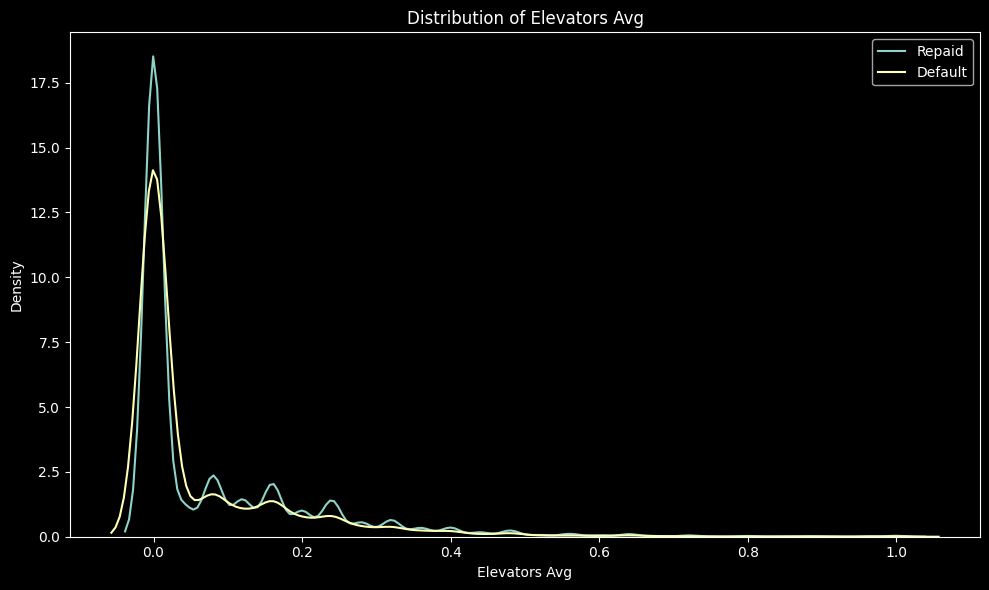

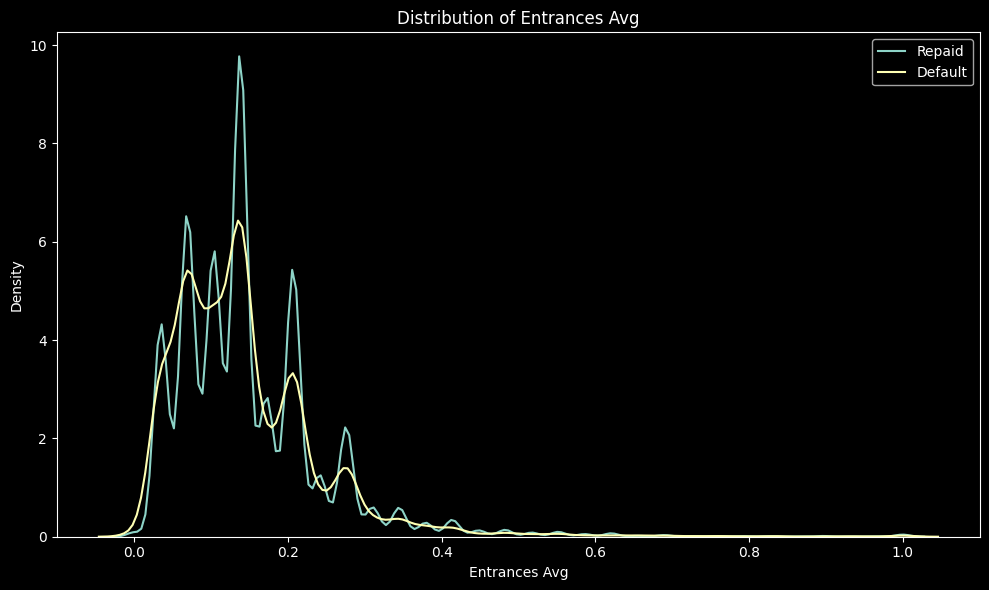

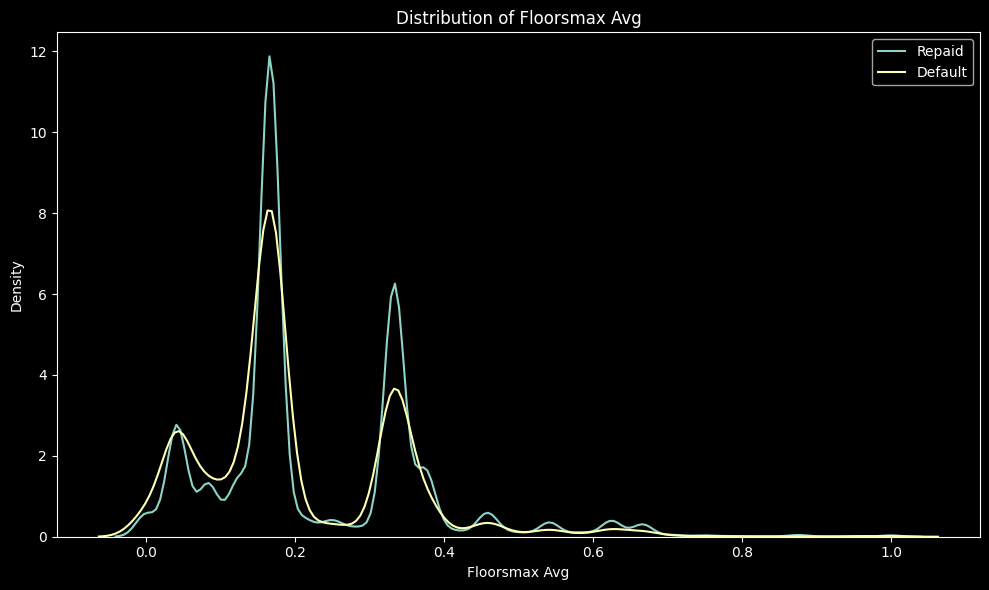

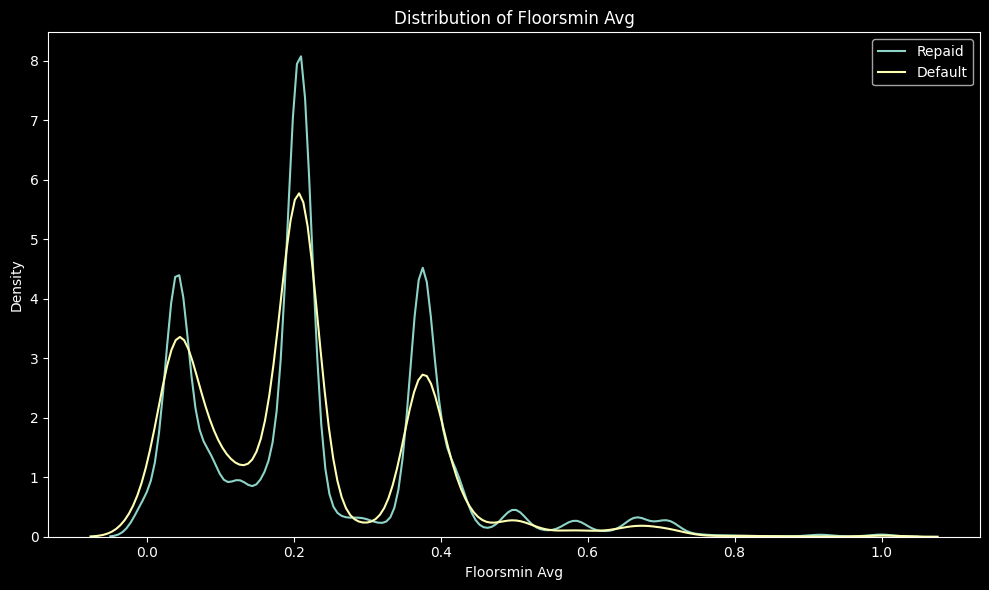

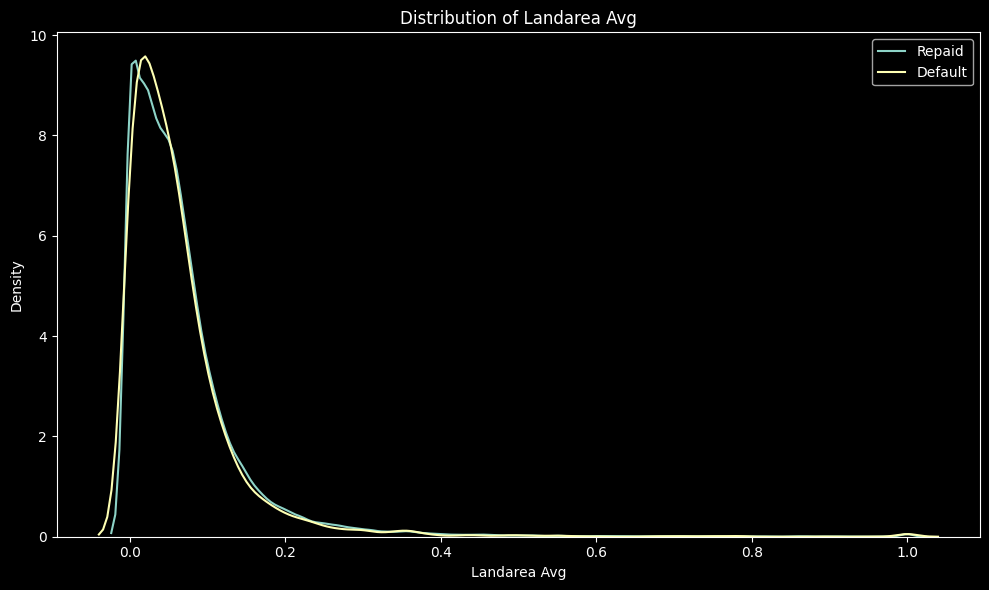

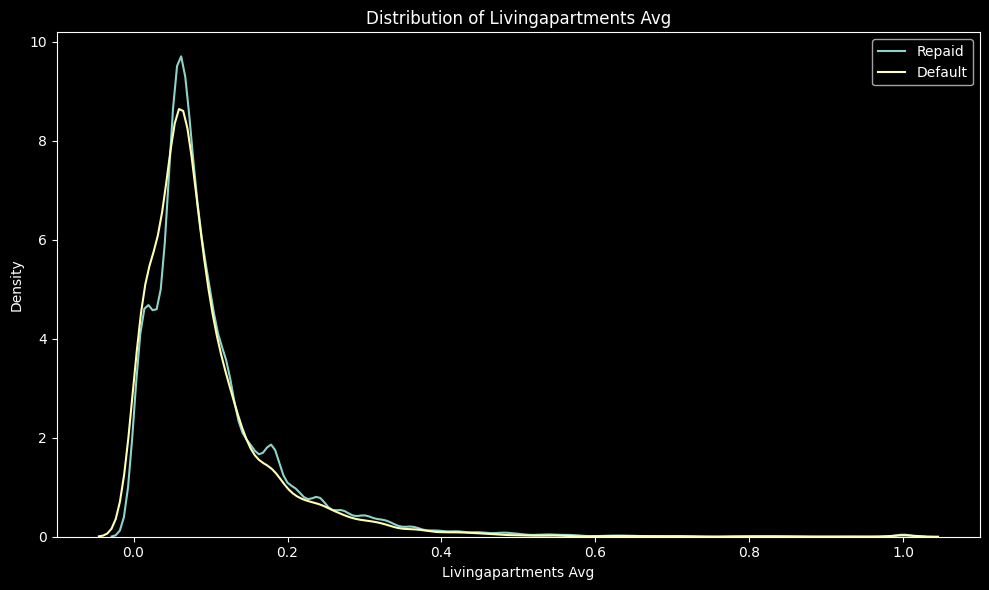

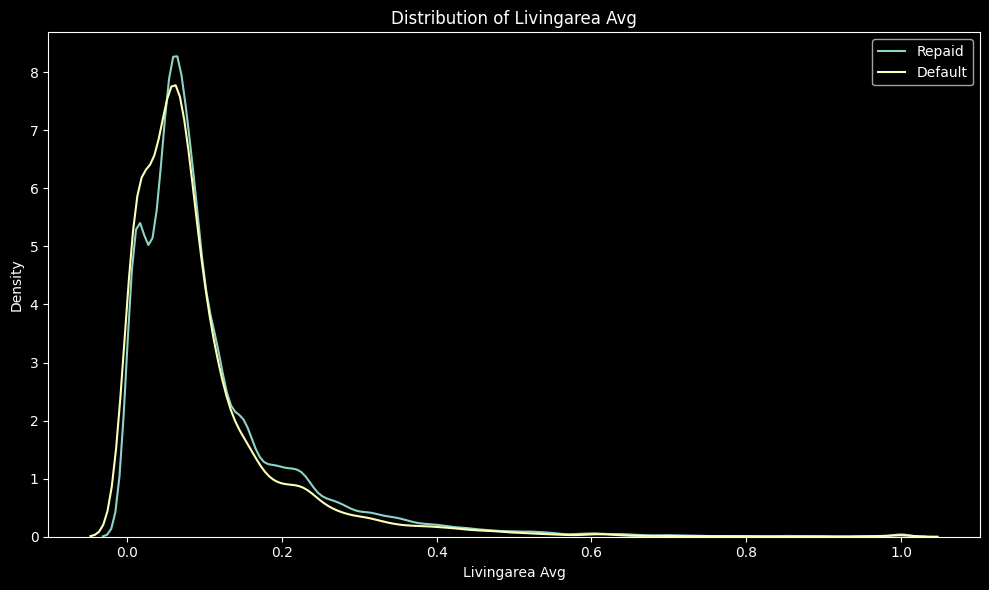

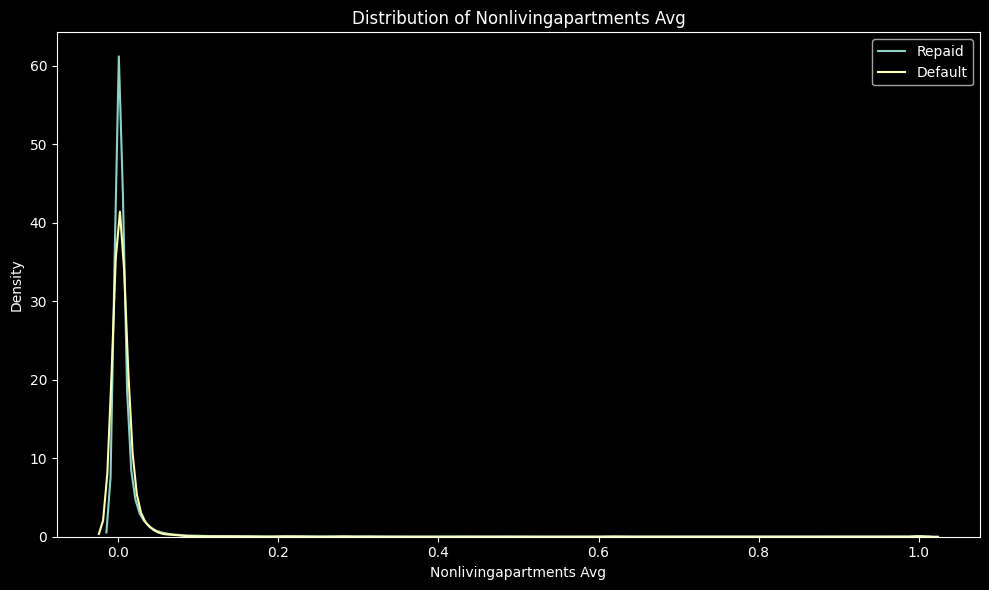

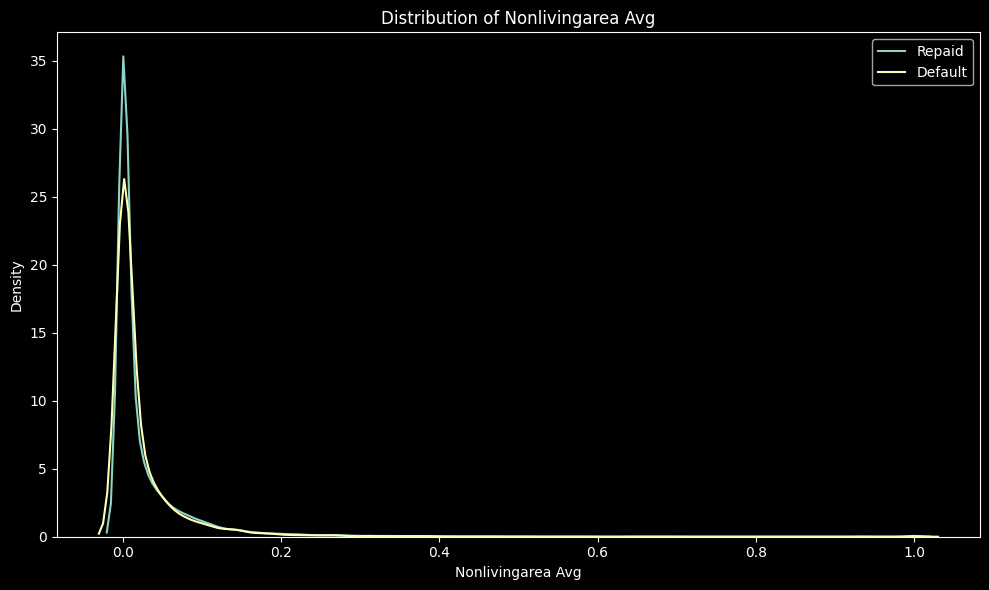

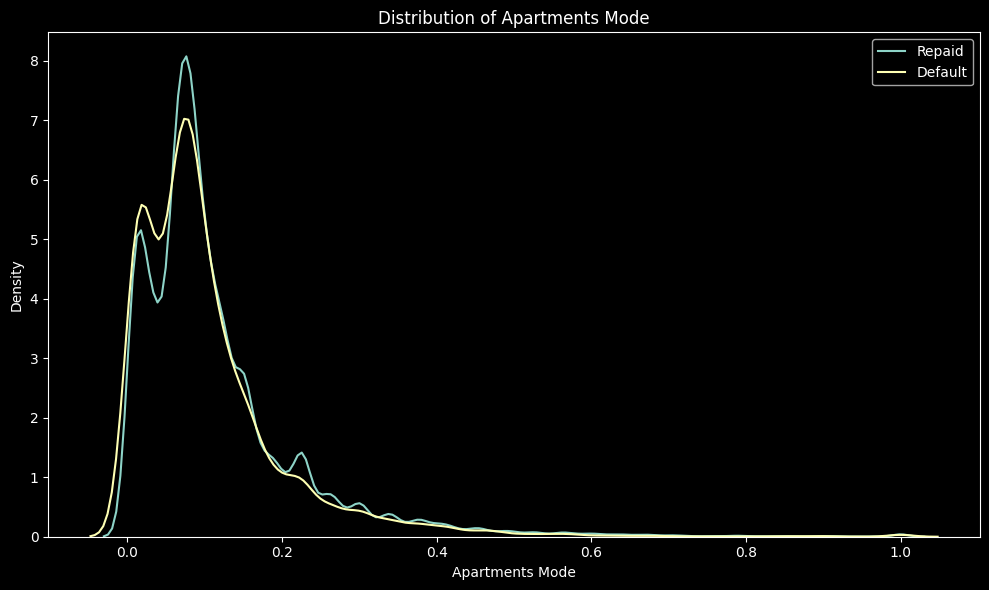

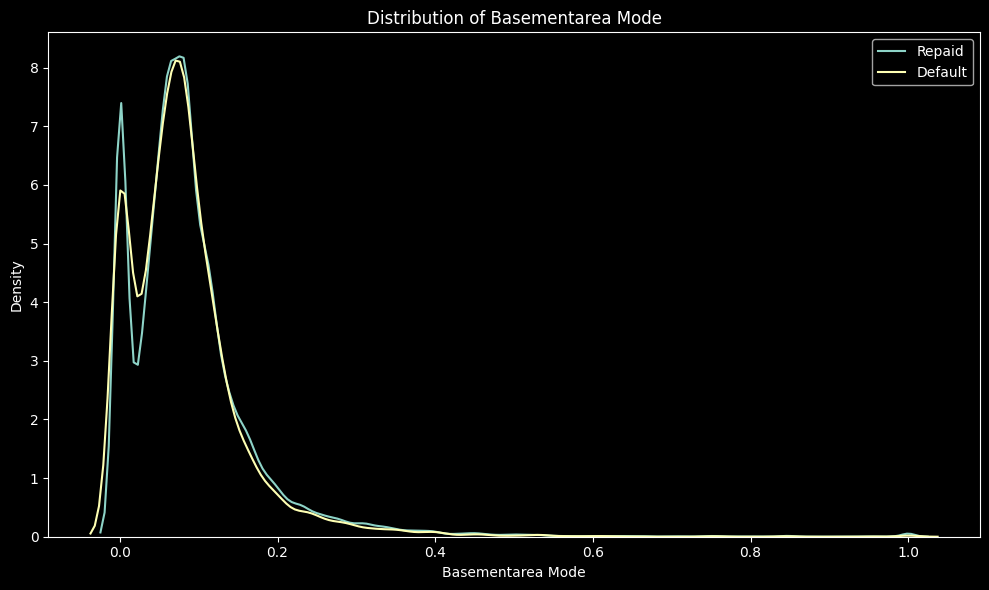

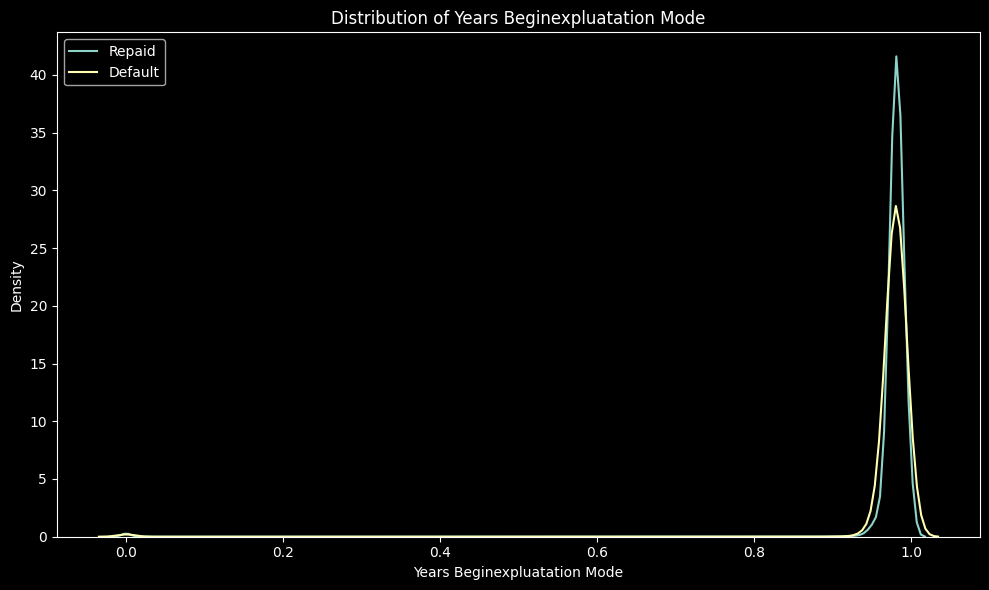

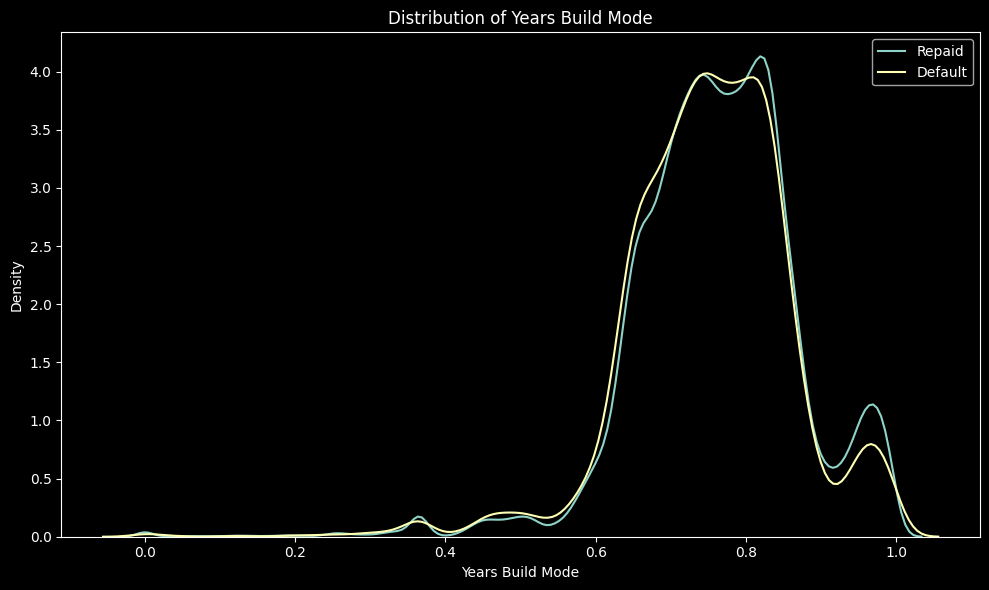

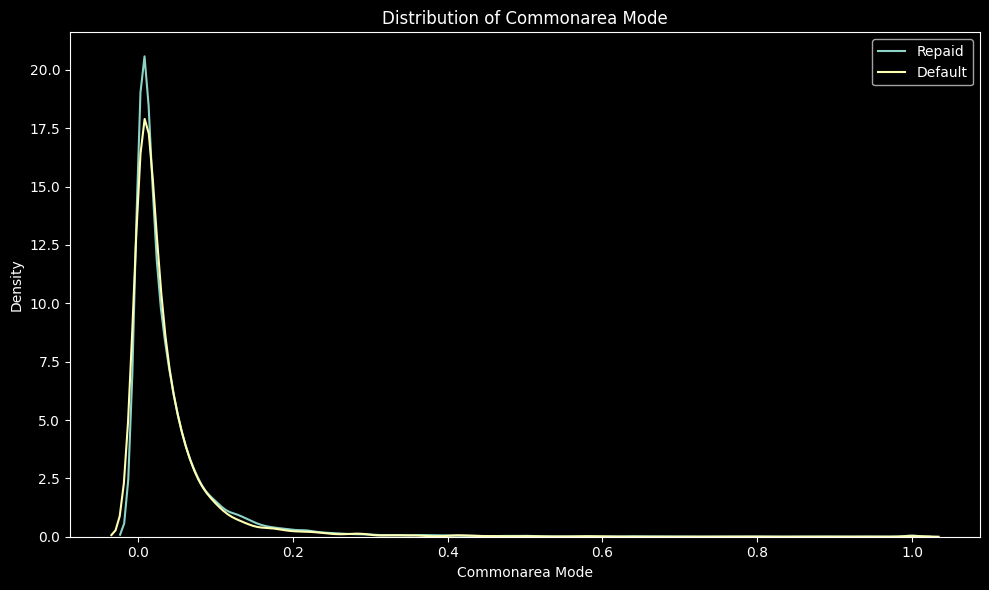

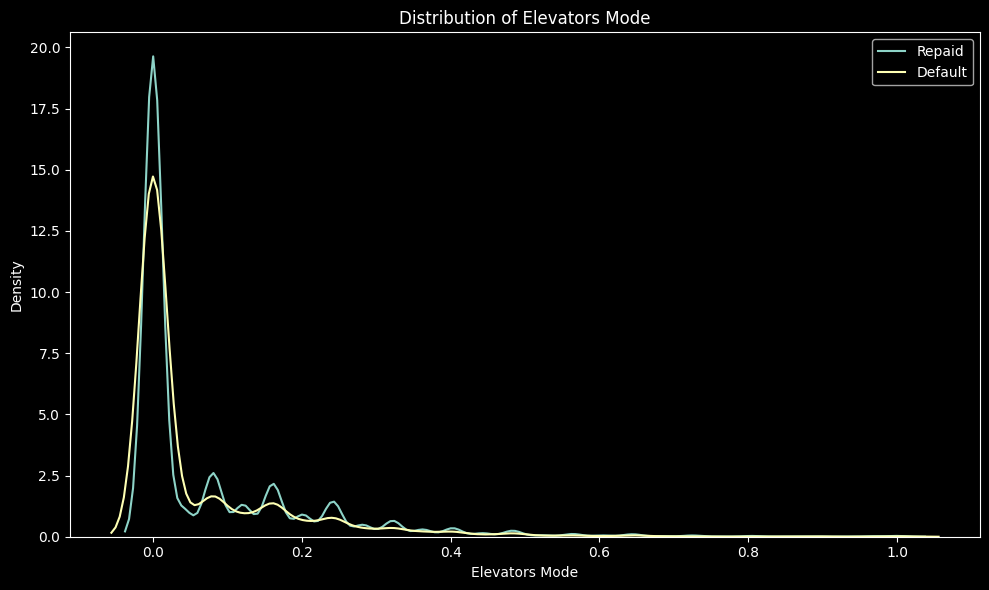

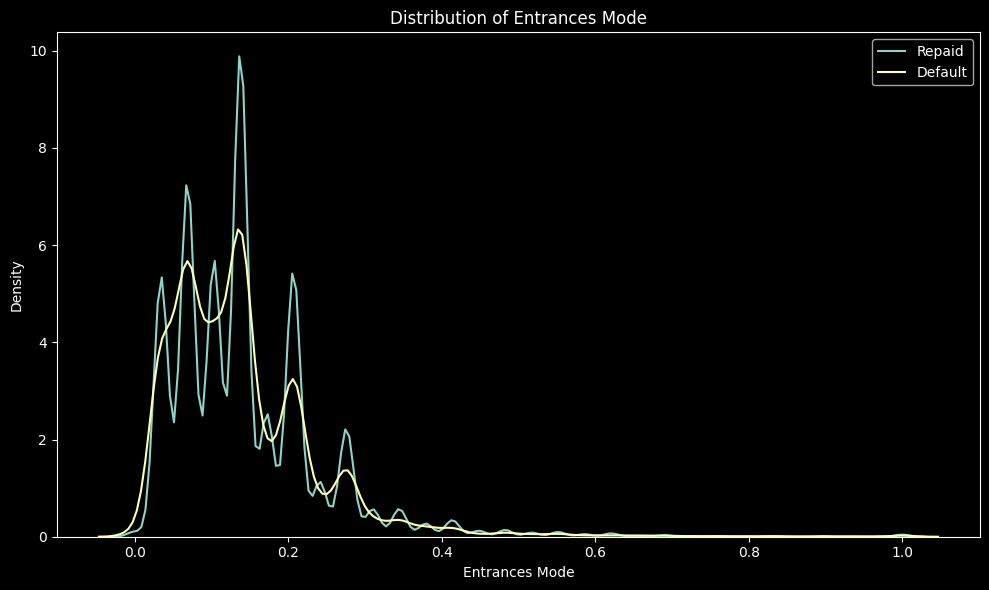

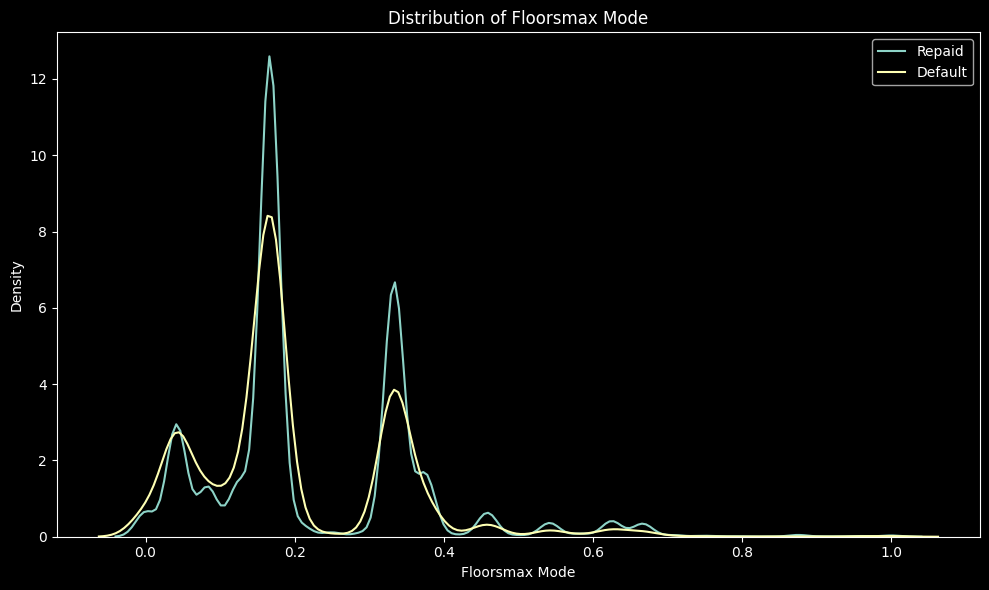

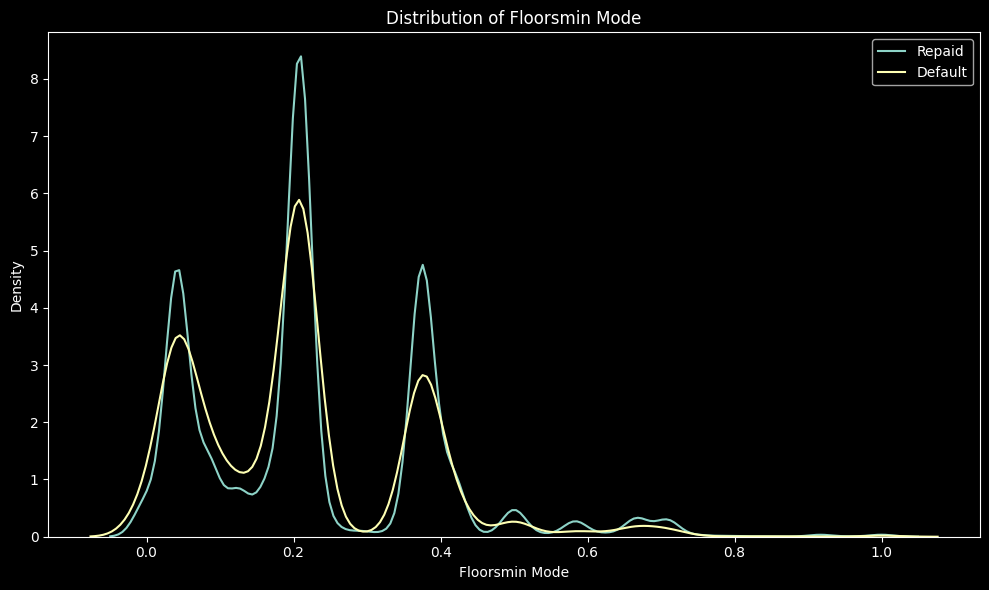

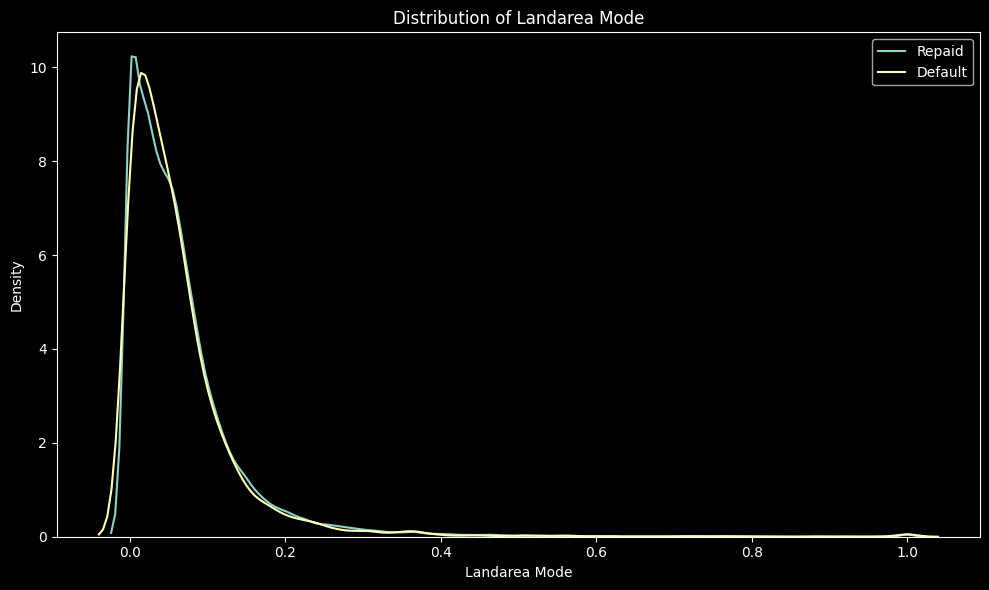

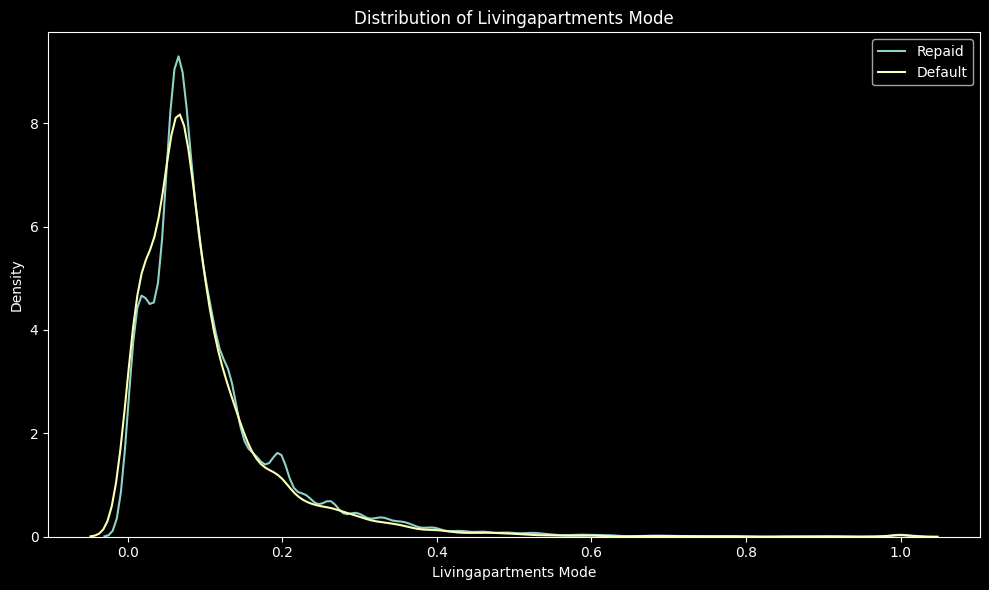

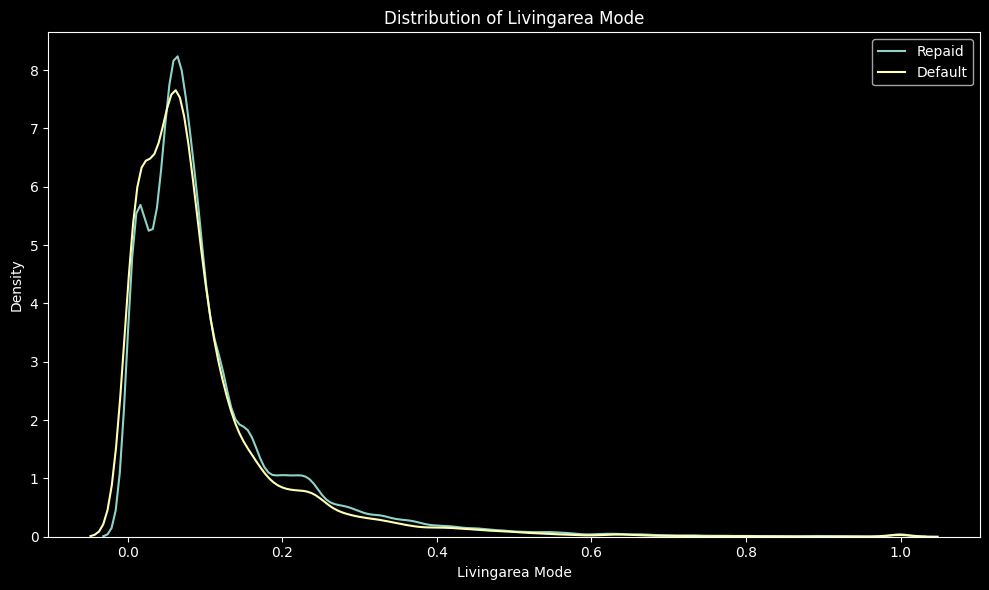

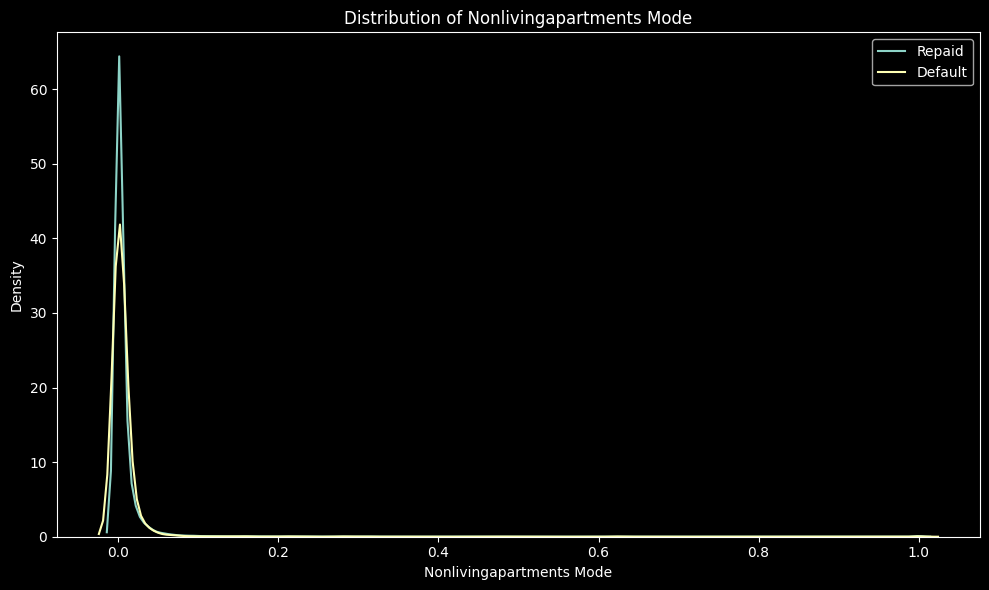

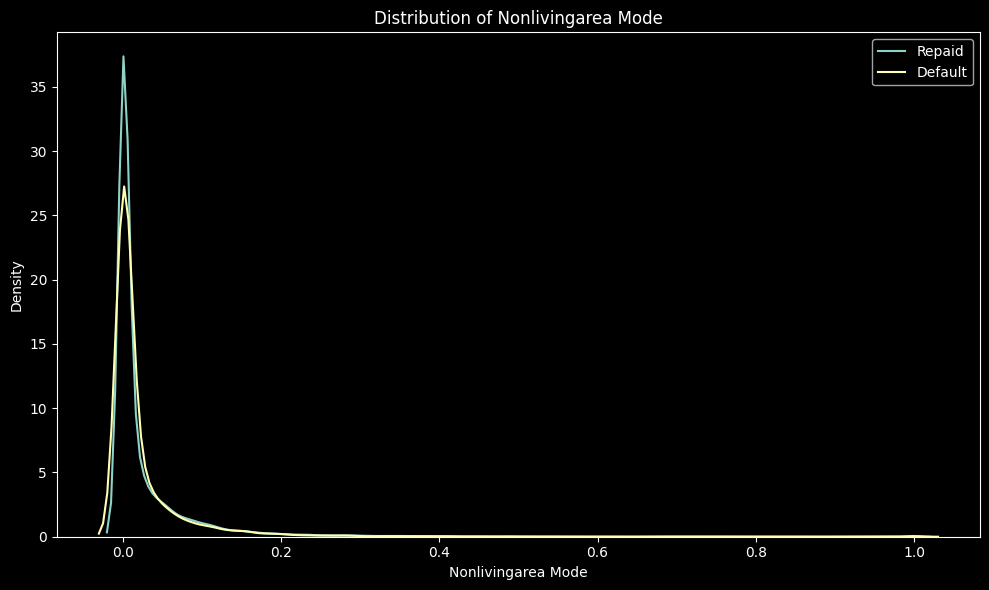

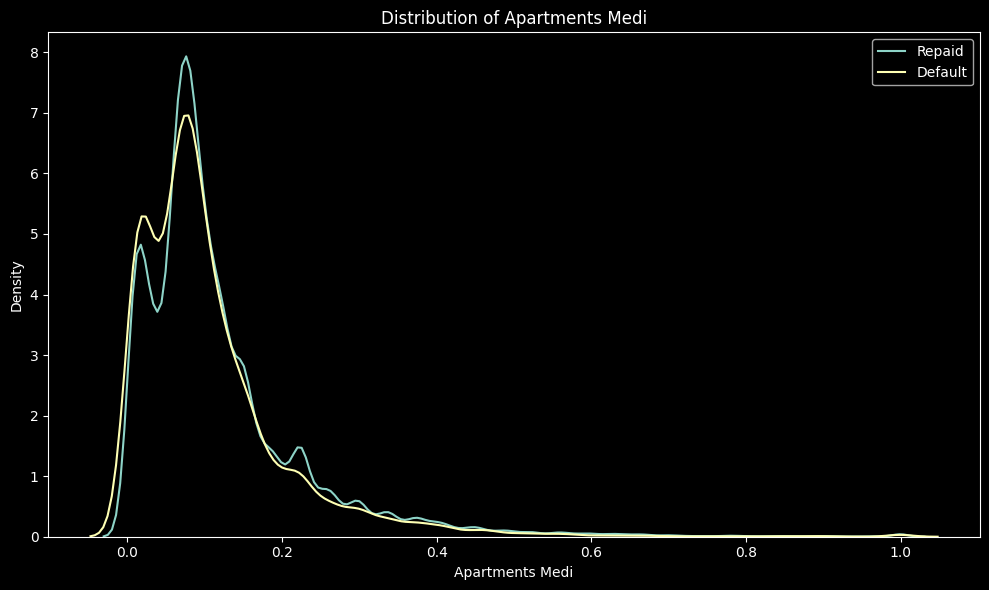

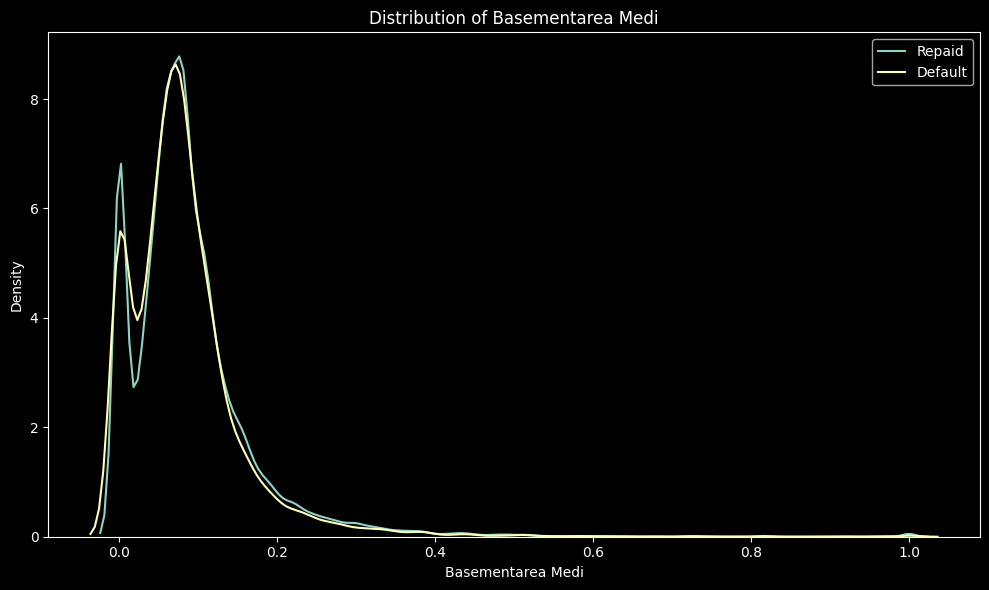

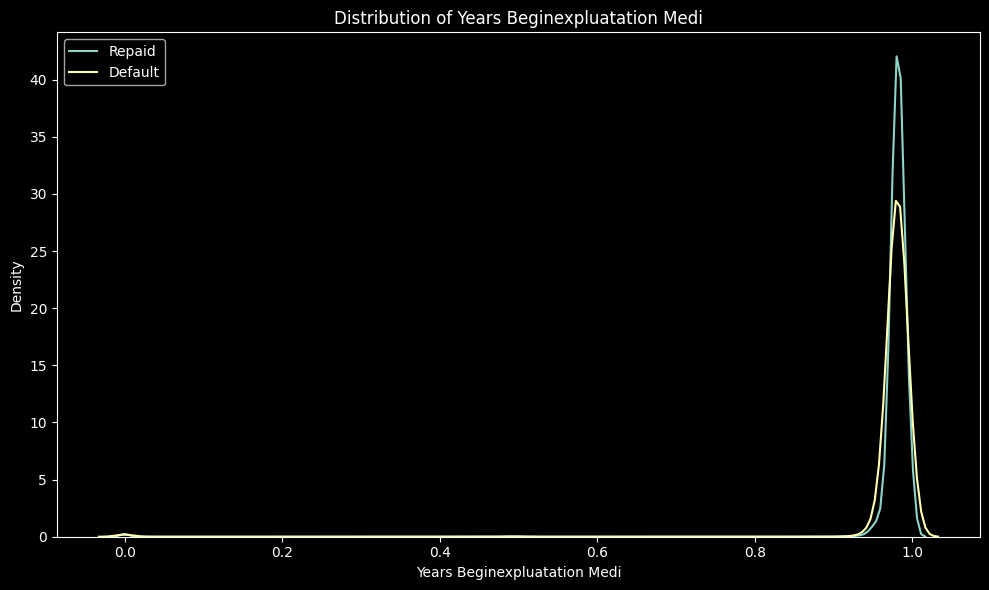

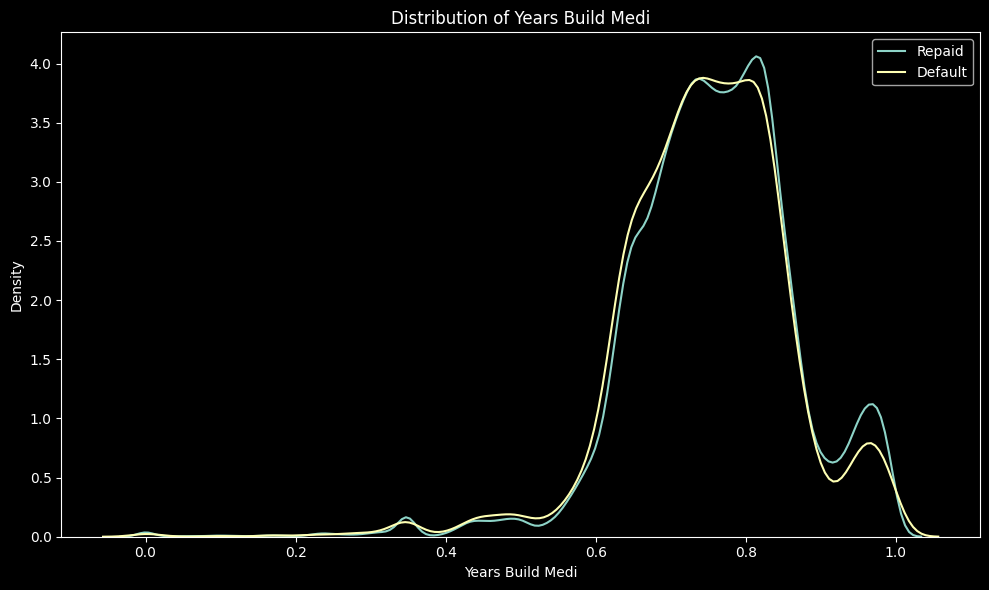

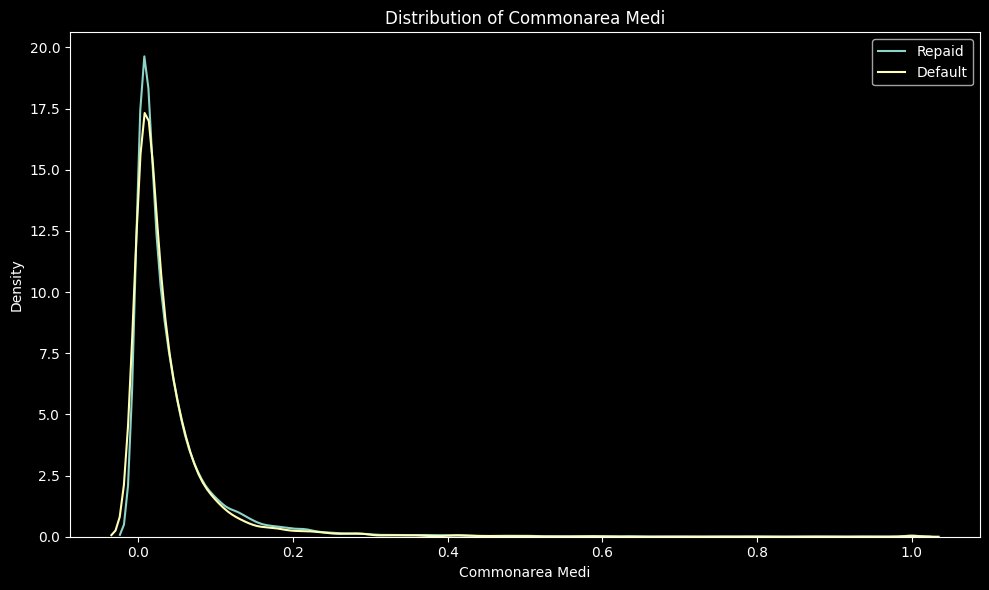

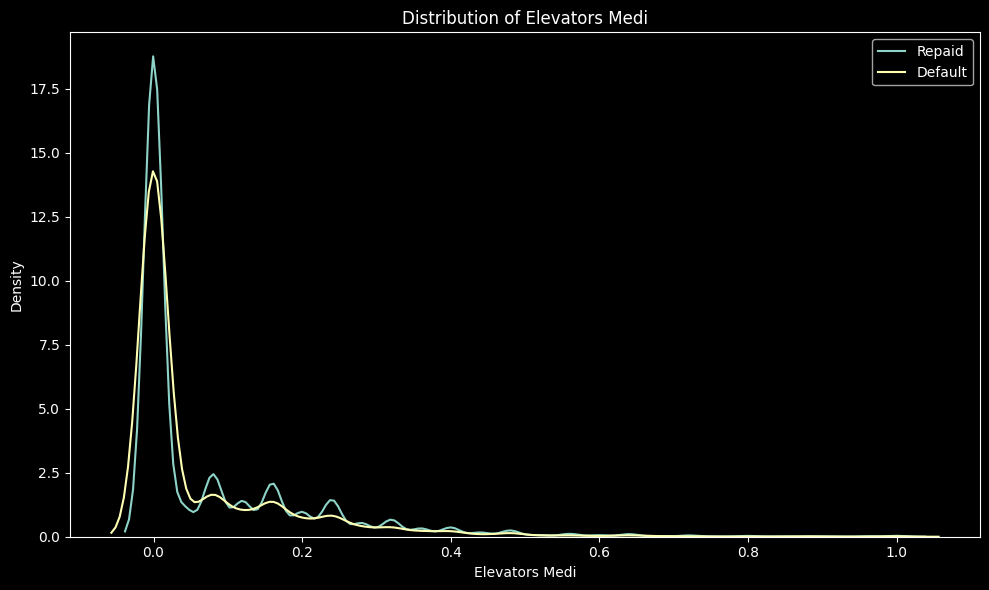

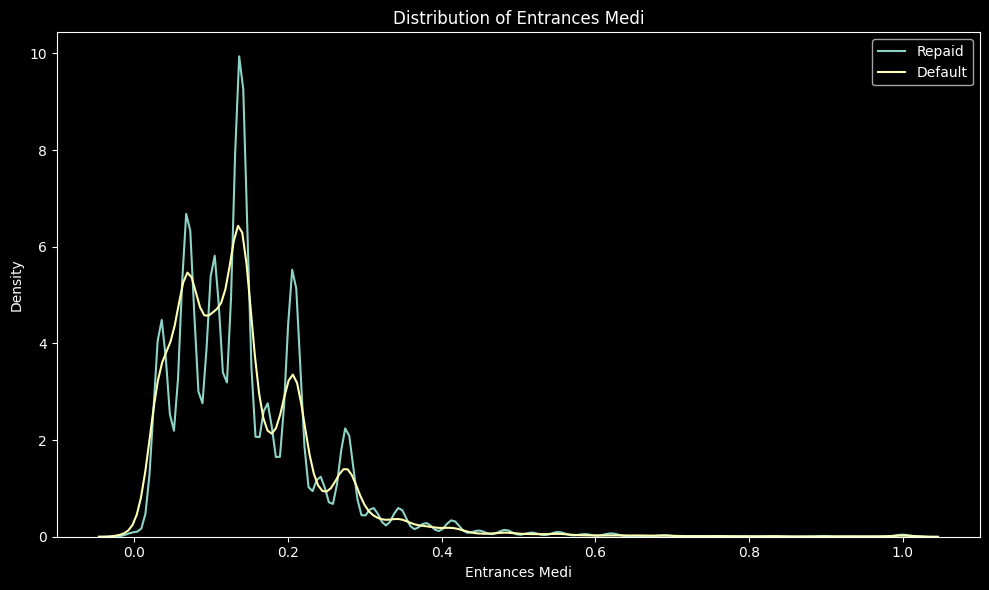

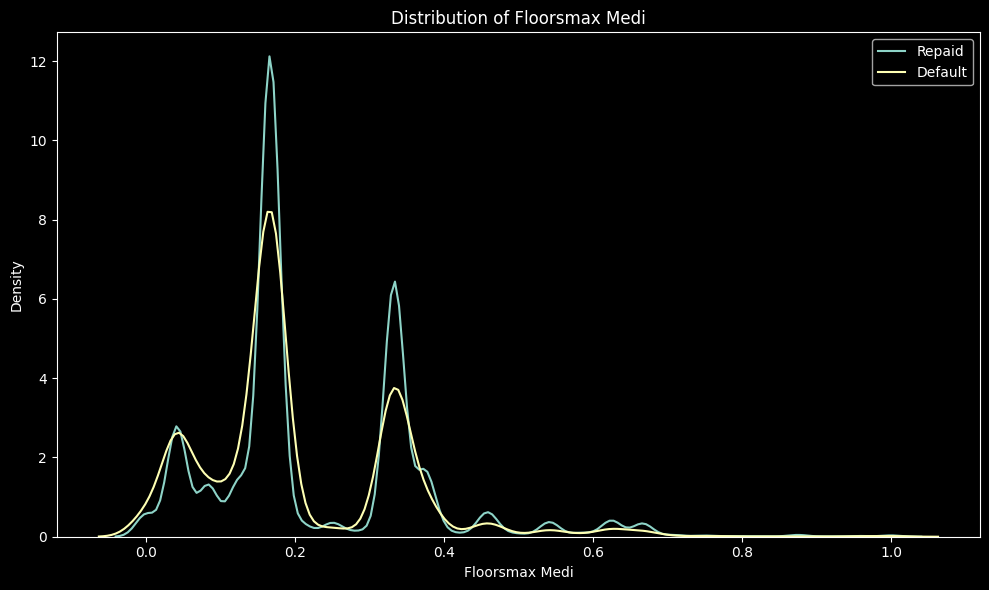

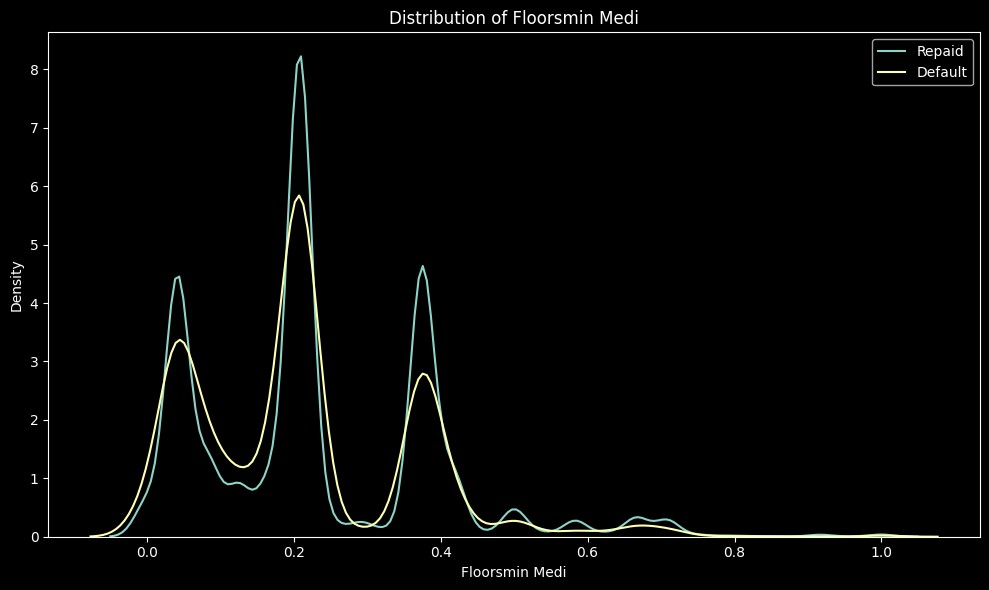

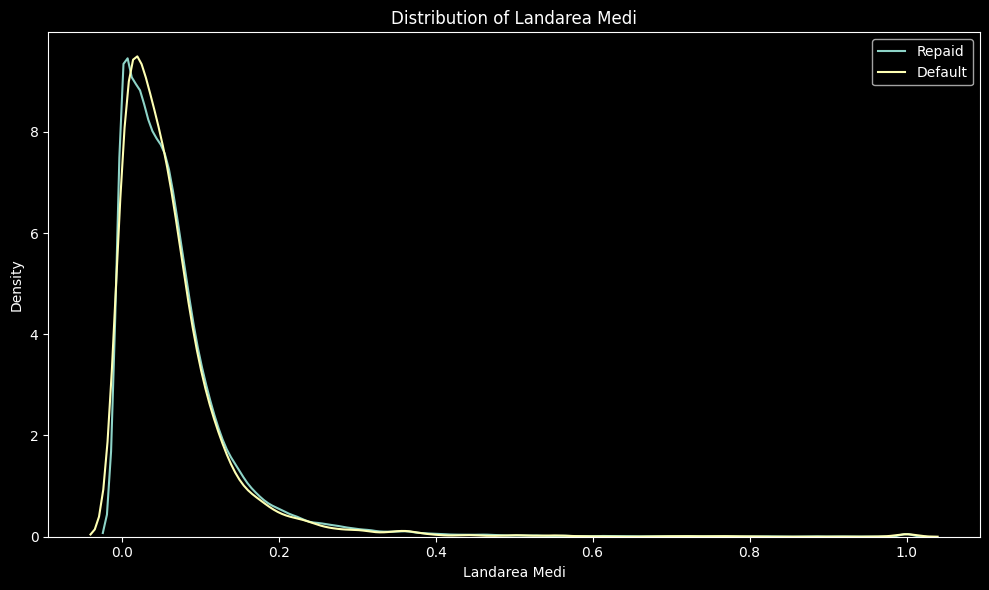

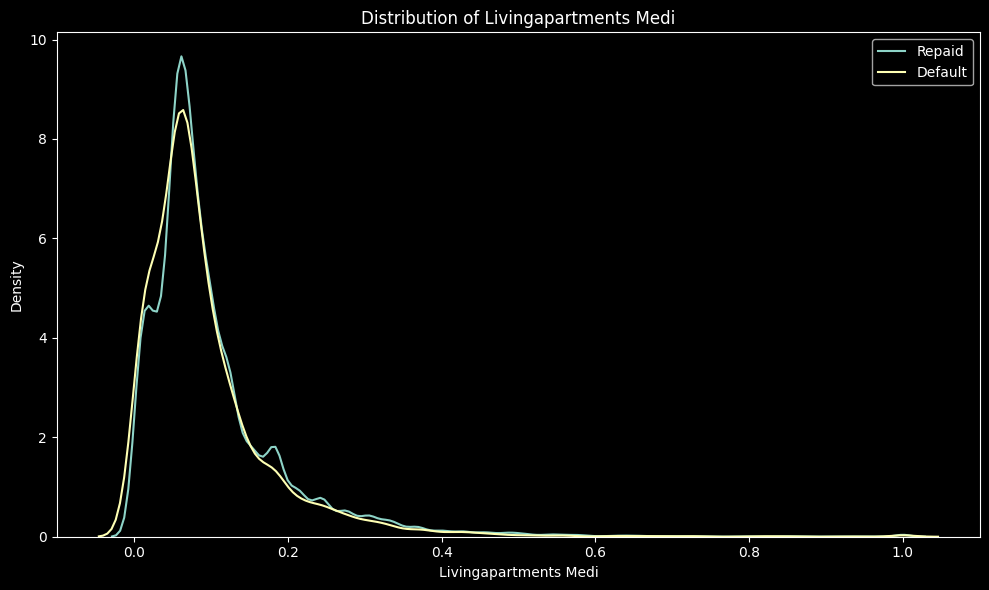

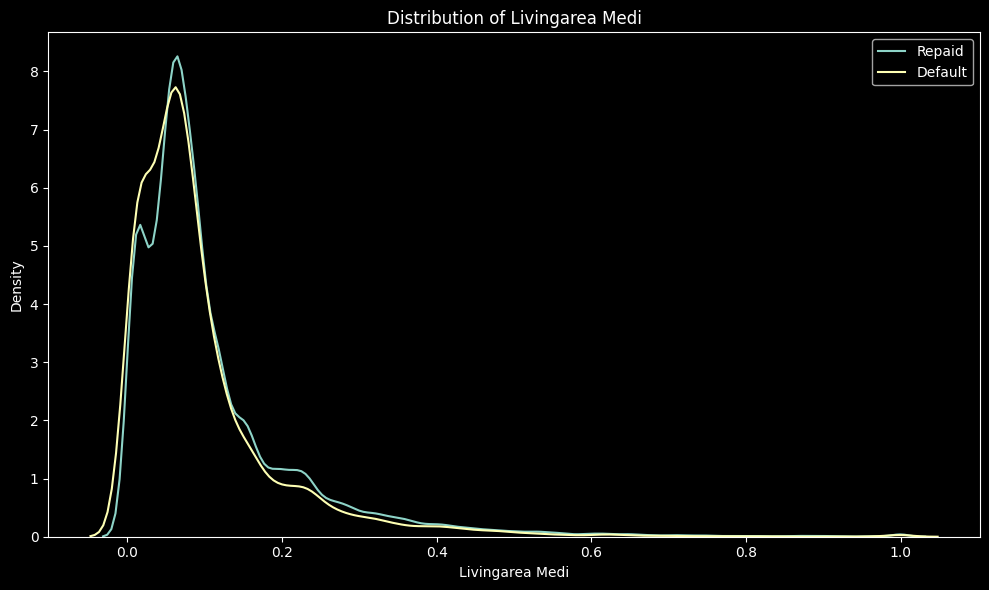

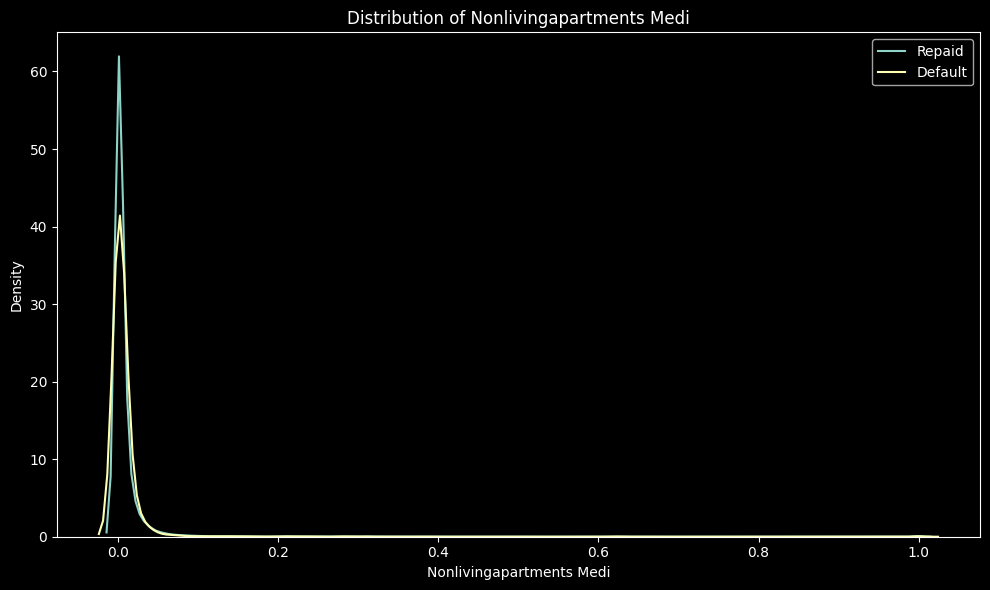

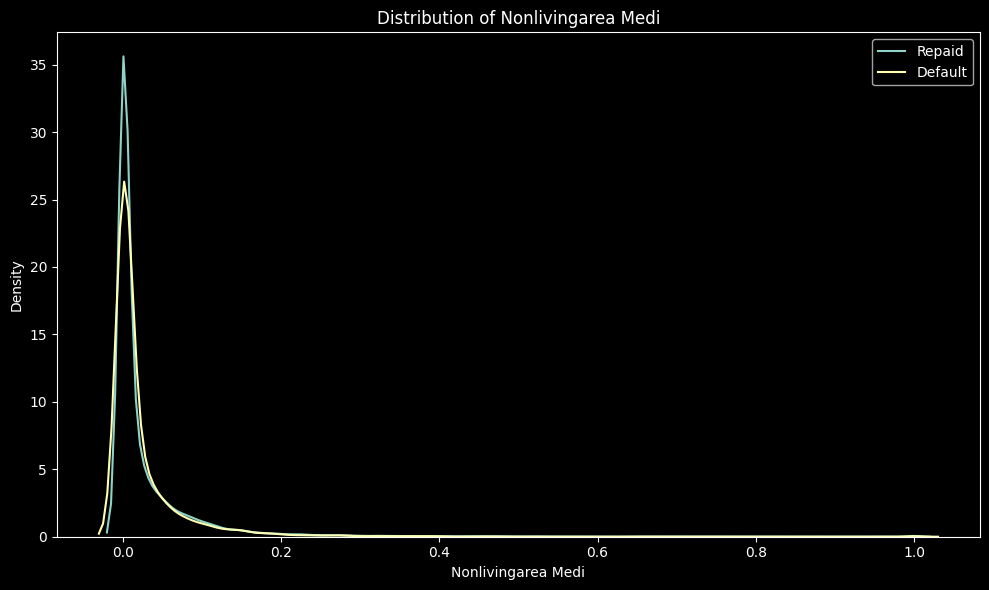

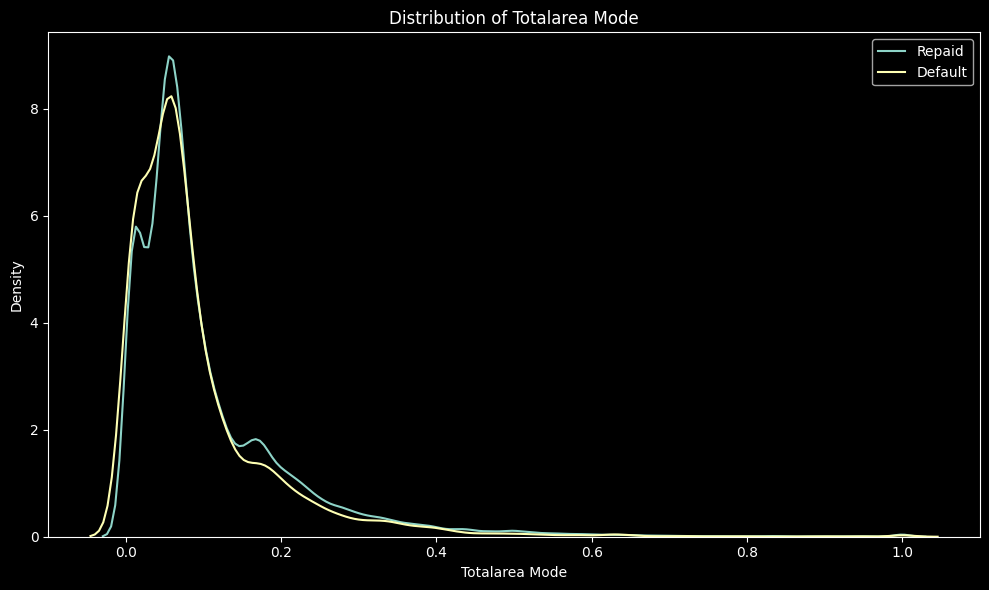

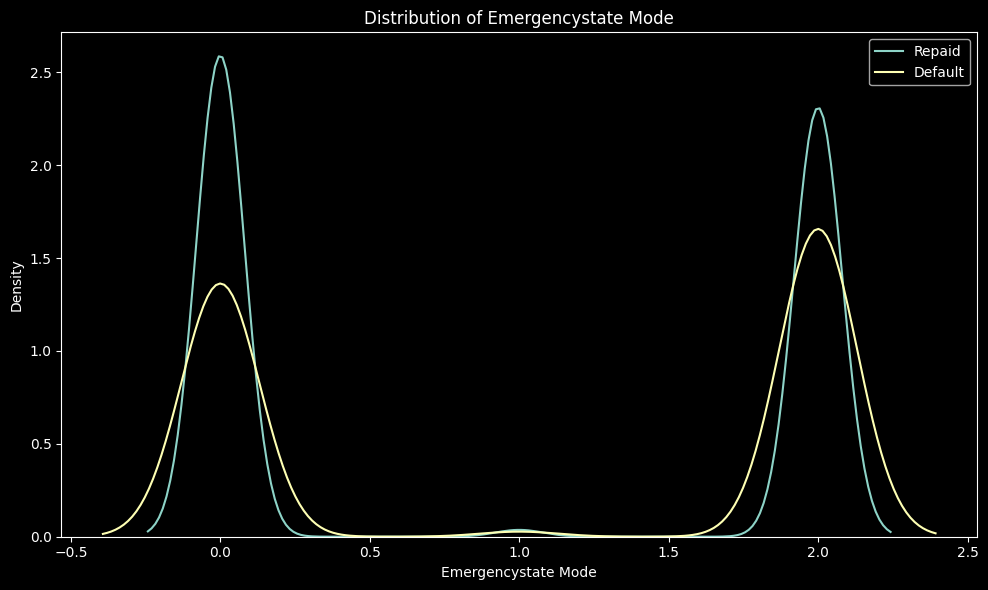

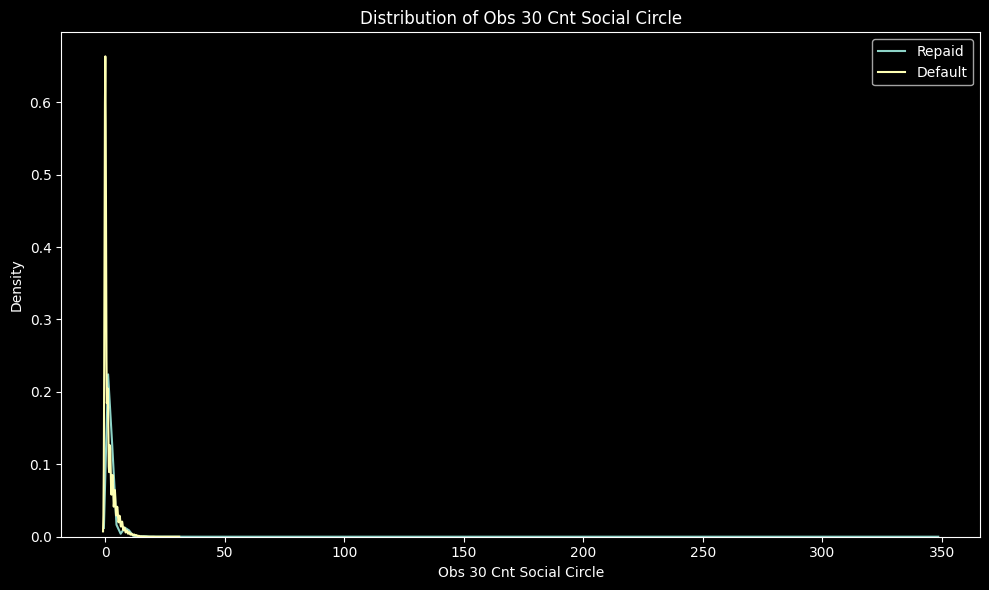

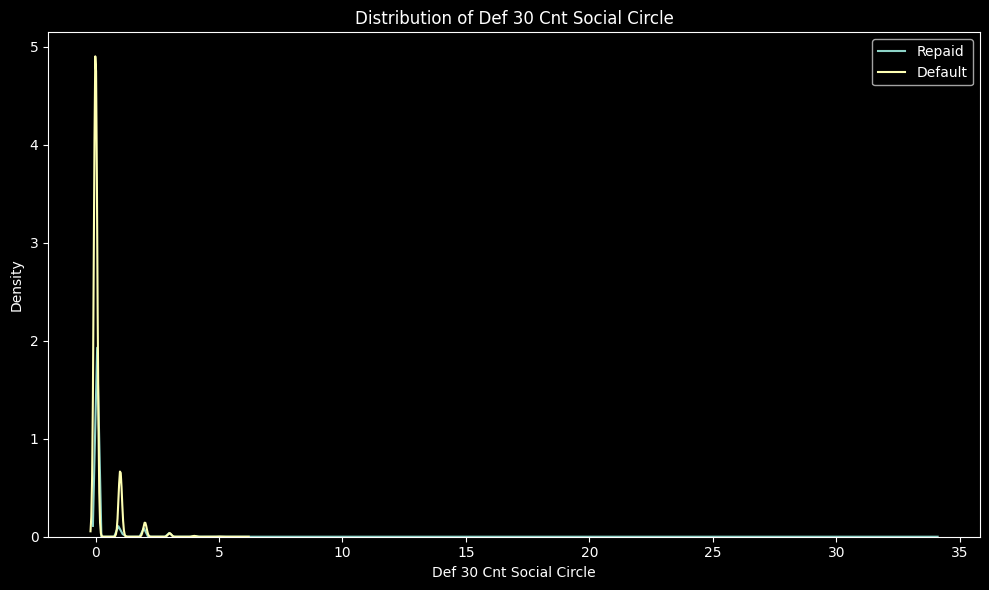

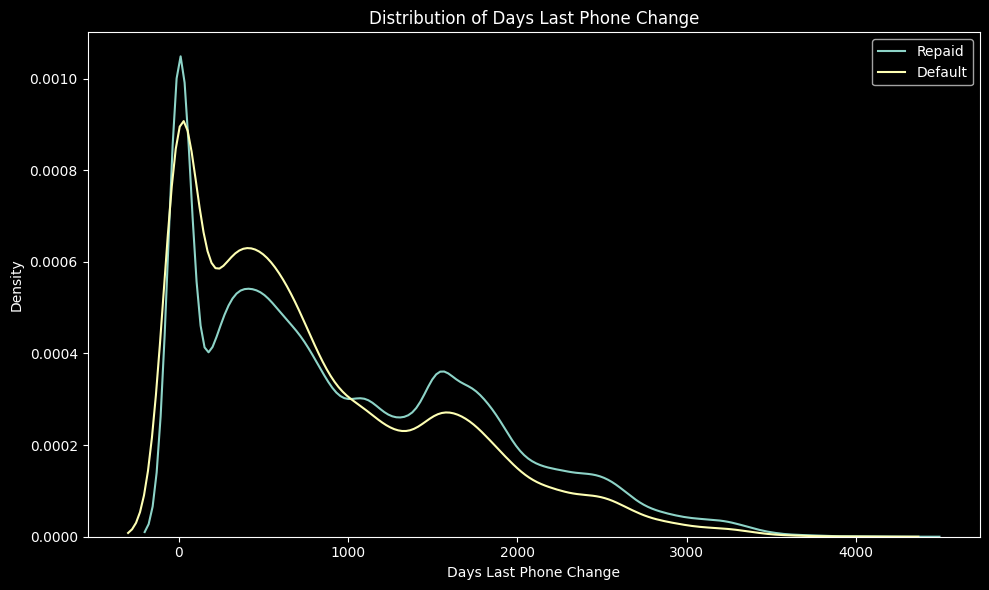

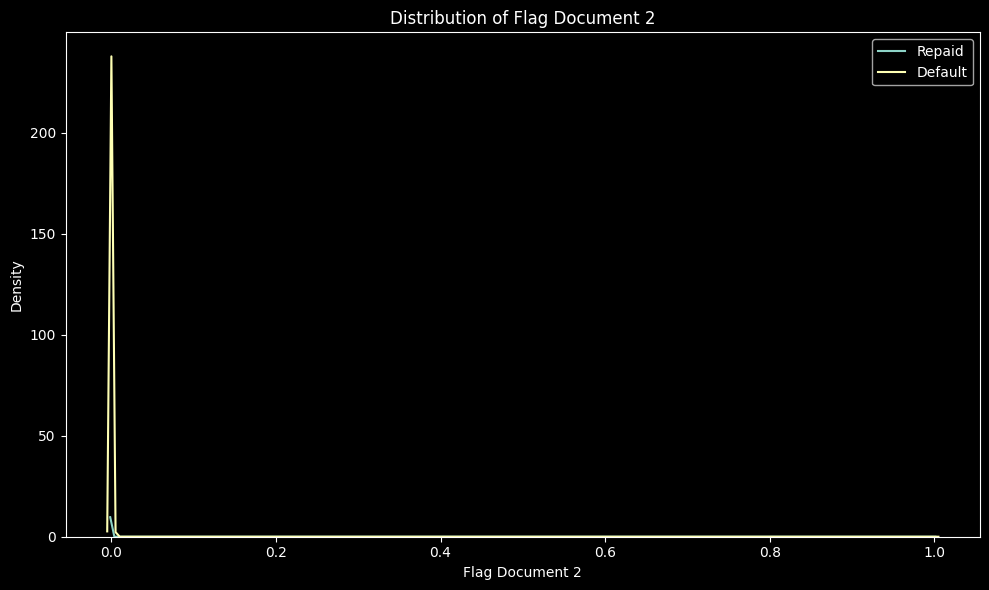

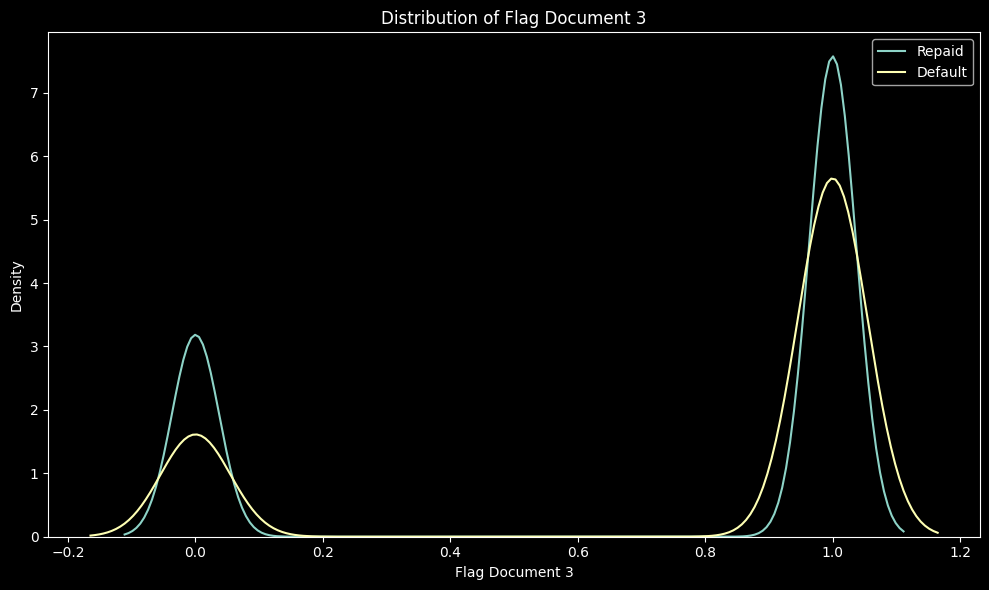

/var/folders/jw/7s6k1pd17nj7rvp321jl59sm0000gn/T/ipykernel_63109/2334096669.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["TARGET"] == 1, column], label="Default")


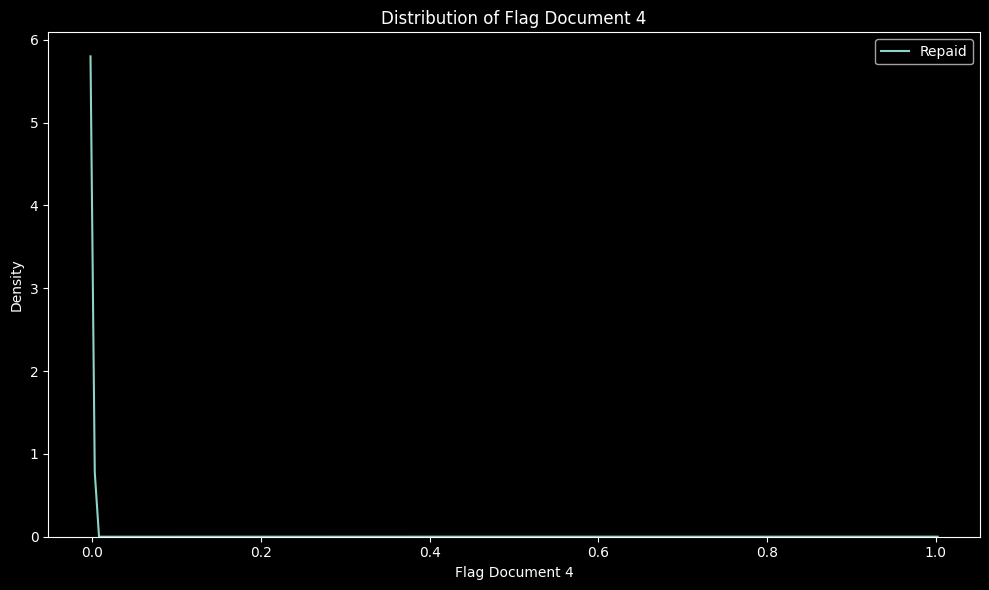

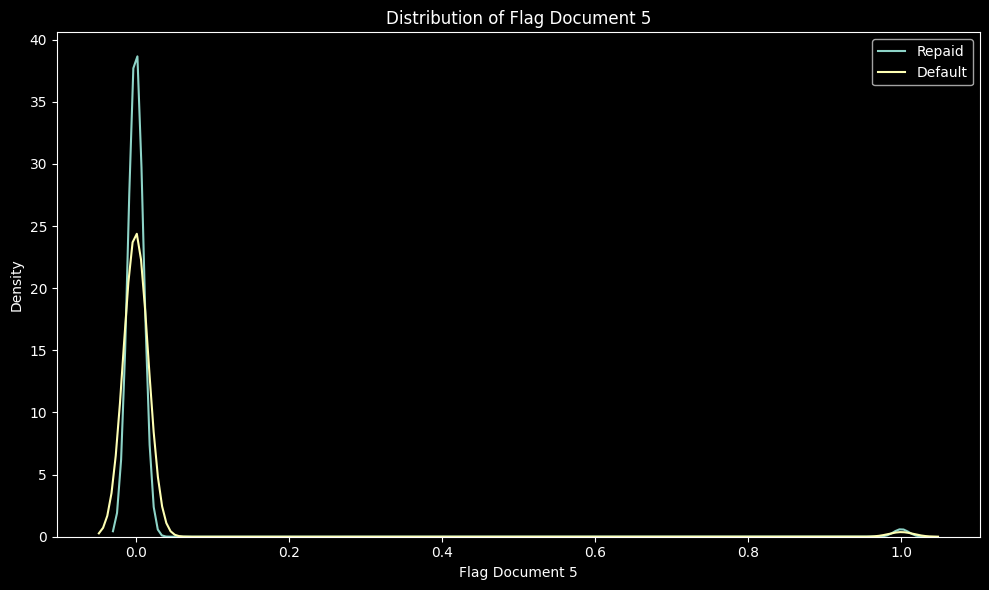

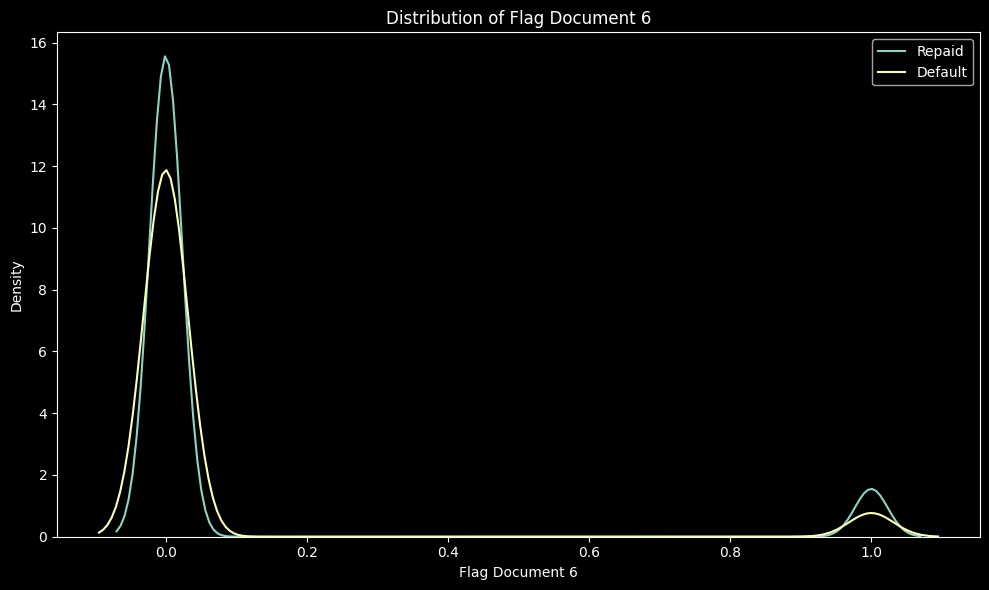

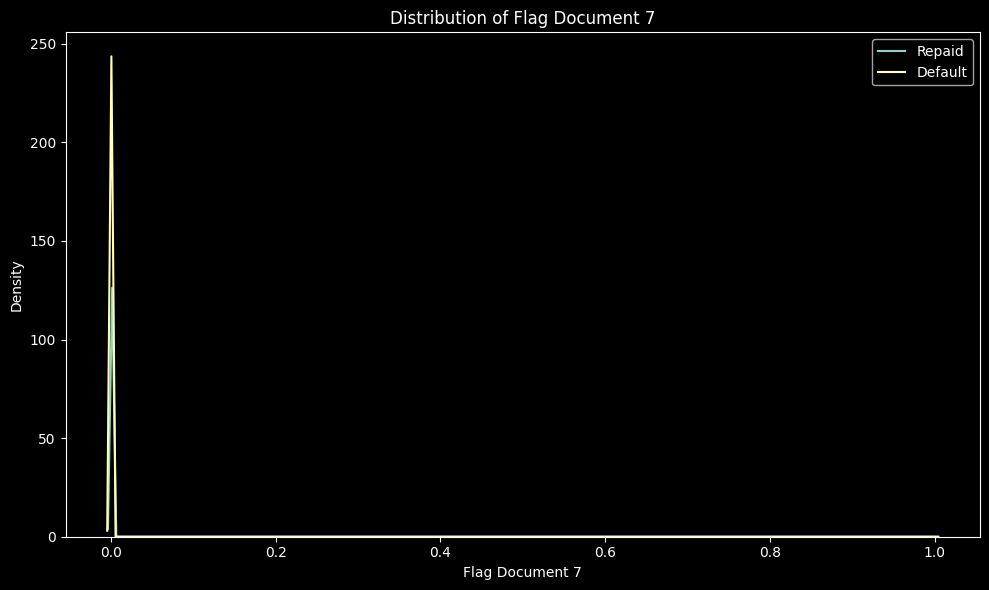

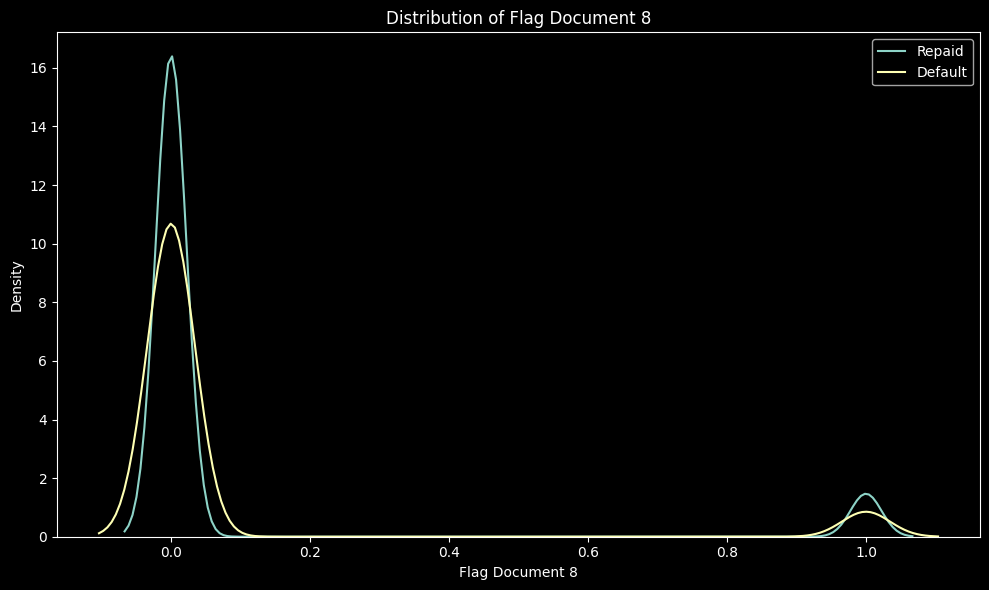

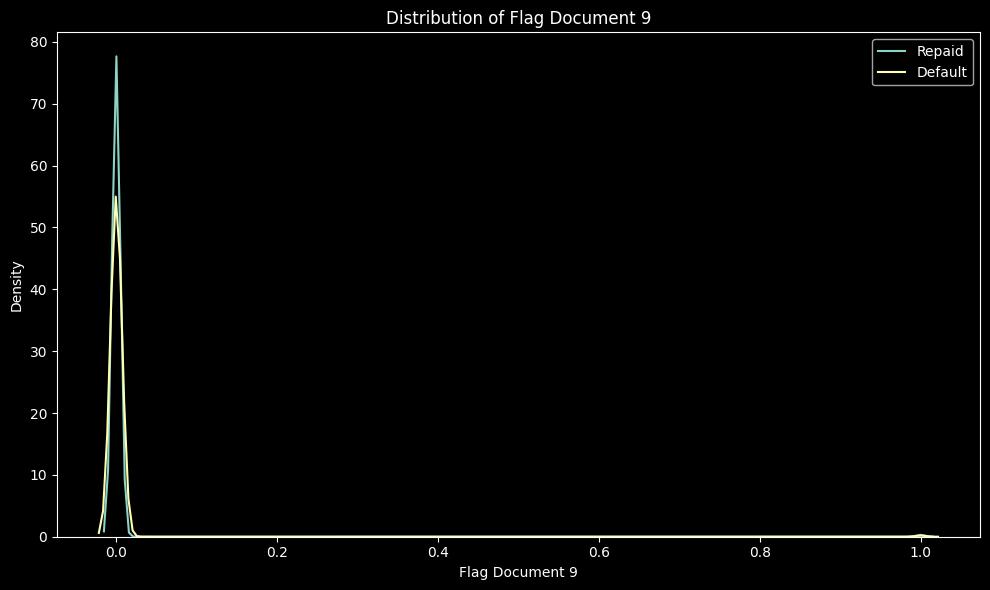

/var/folders/jw/7s6k1pd17nj7rvp321jl59sm0000gn/T/ipykernel_63109/2334096669.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["TARGET"] == 1, column], label="Default")


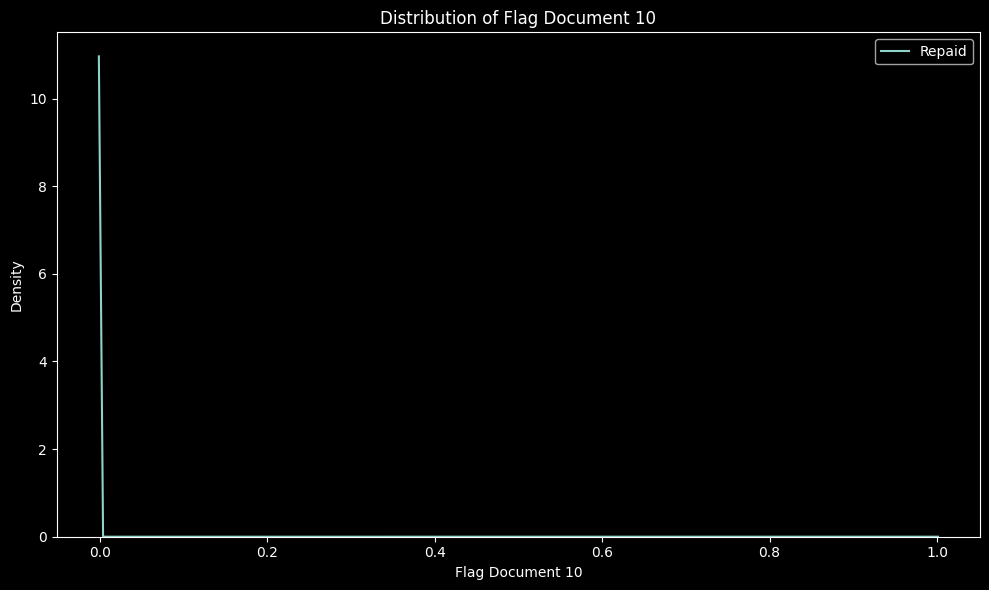

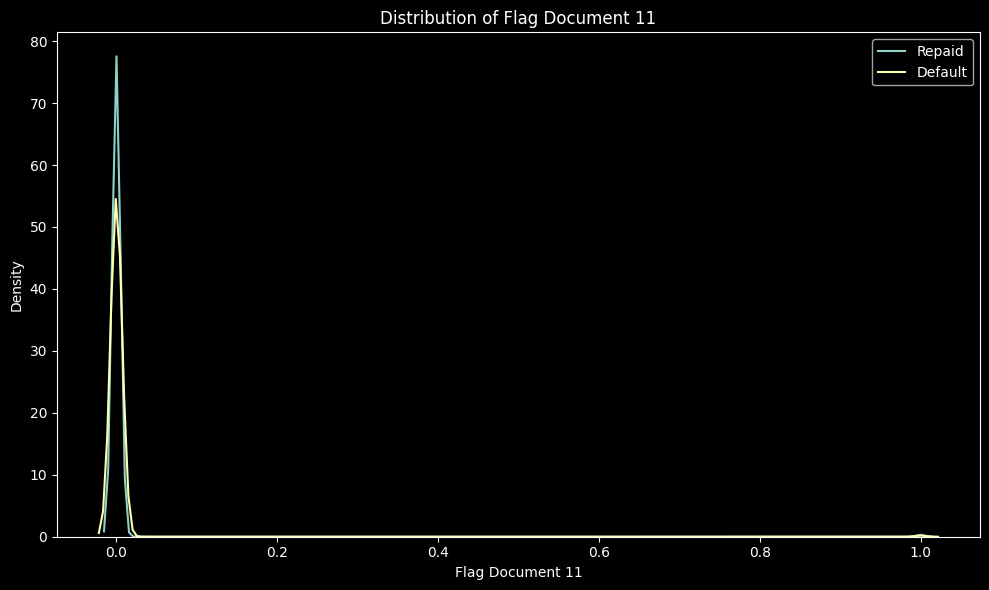

/var/folders/jw/7s6k1pd17nj7rvp321jl59sm0000gn/T/ipykernel_63109/2334096669.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["TARGET"] == 1, column], label="Default")


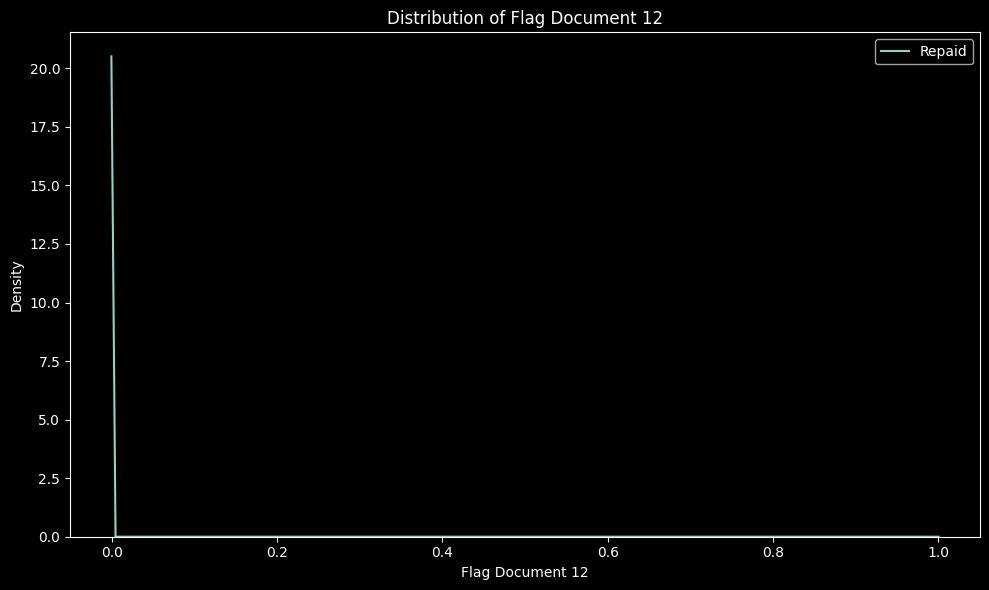

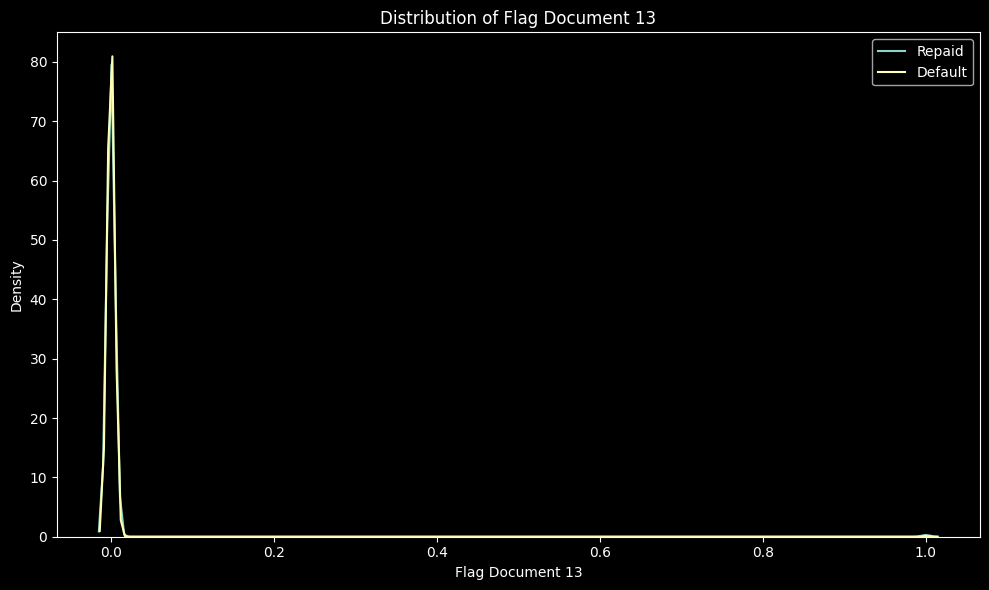

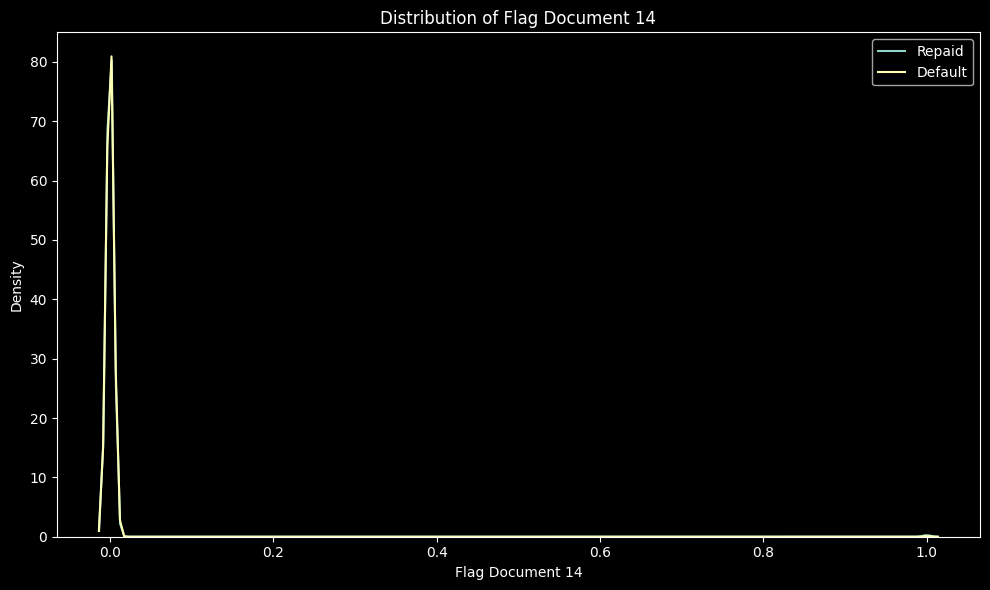

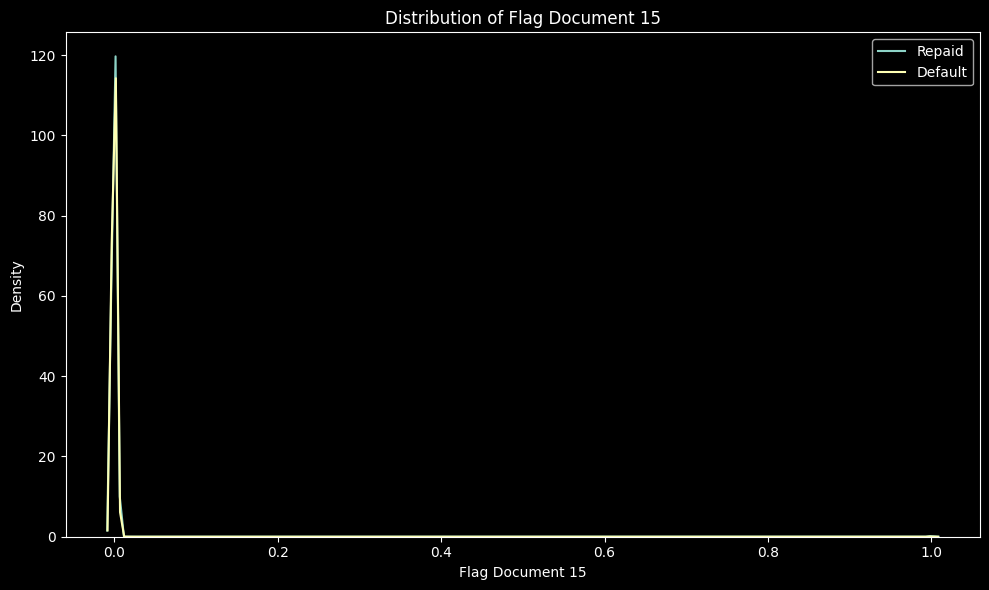

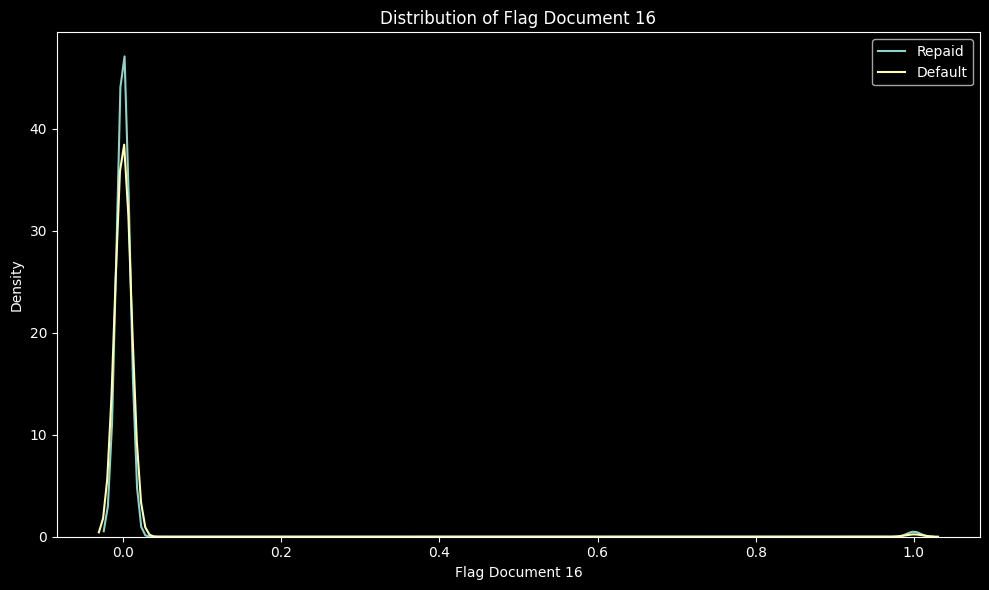

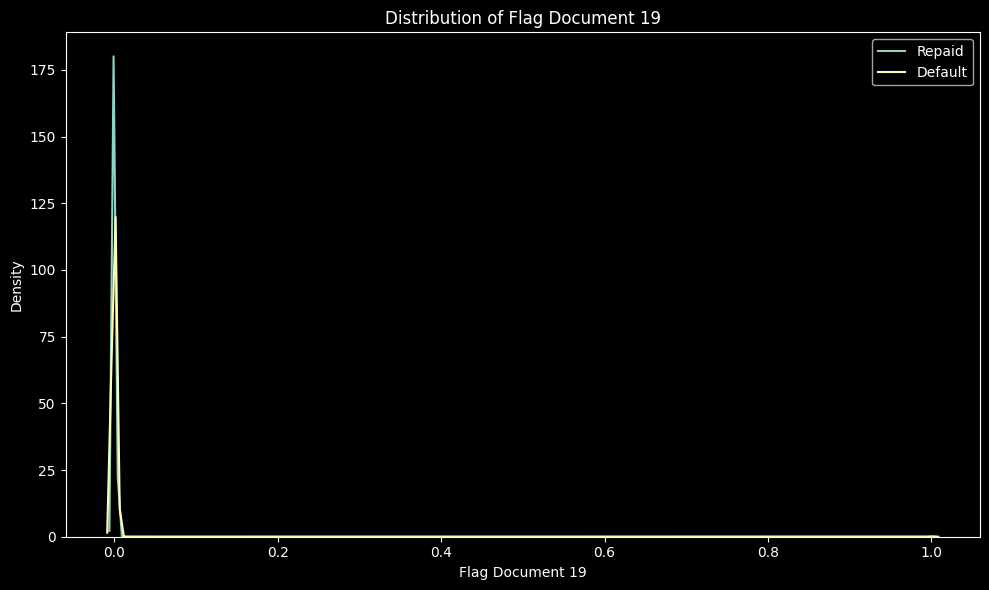

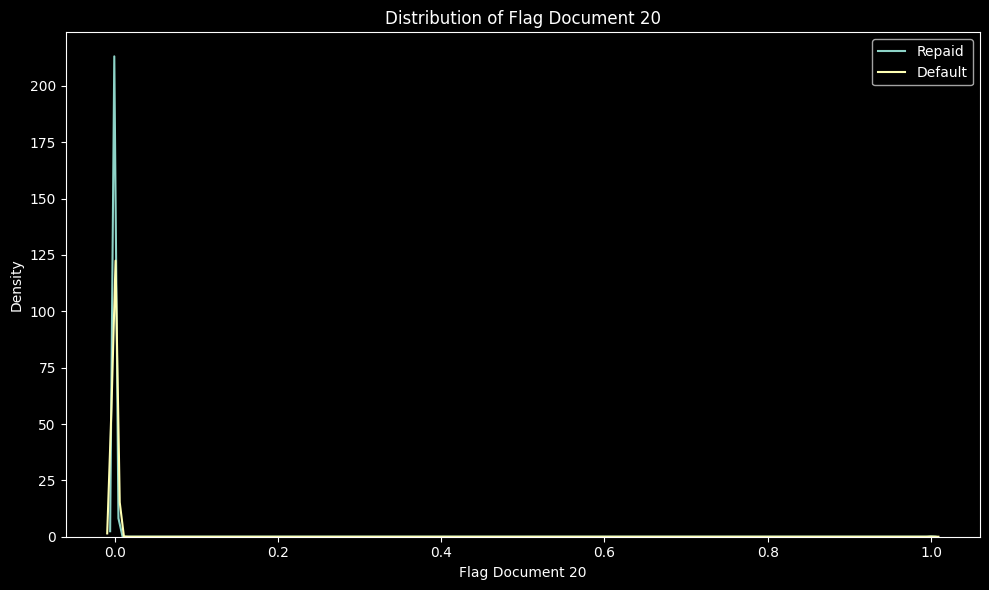

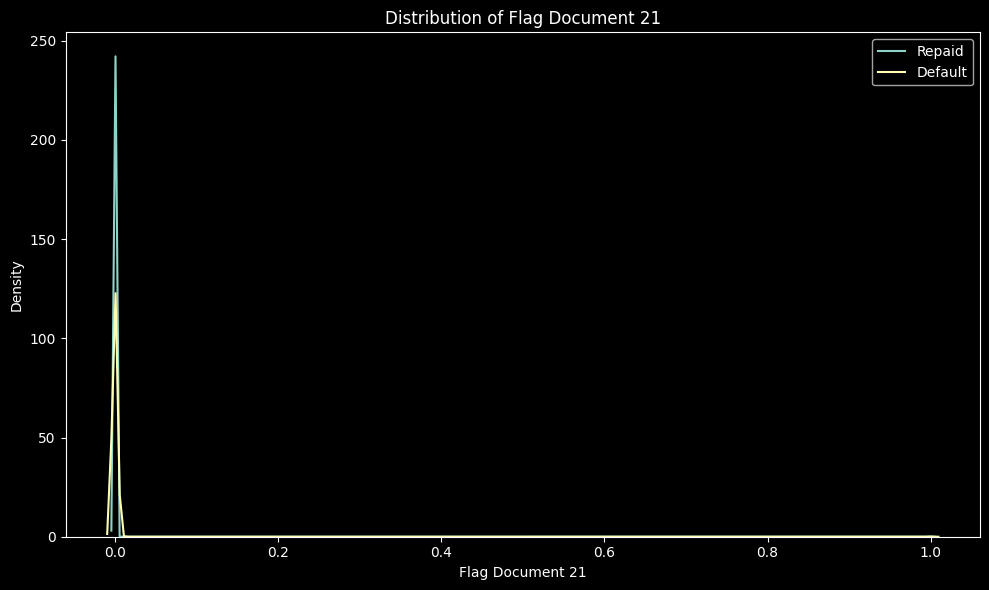

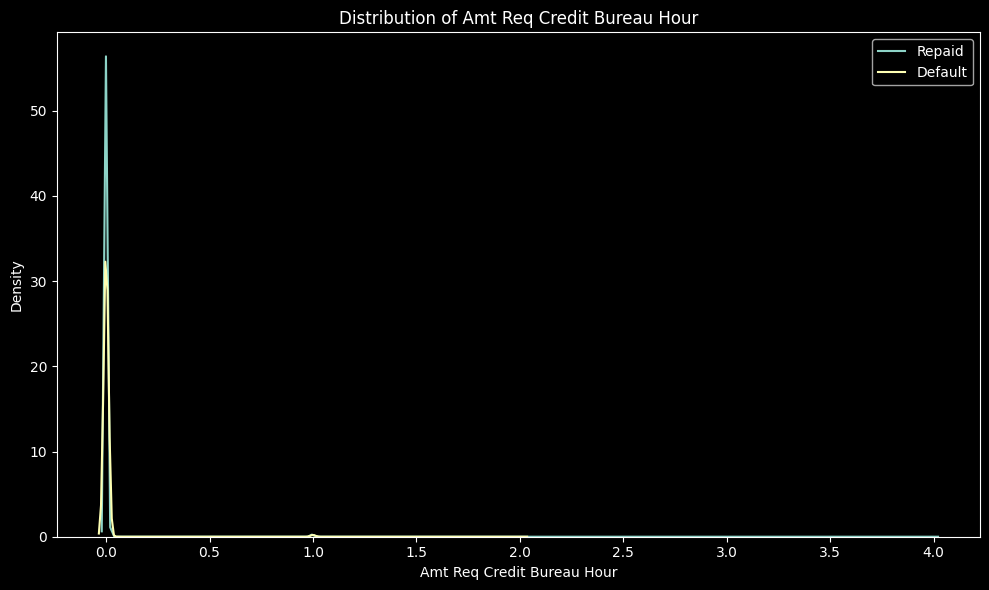

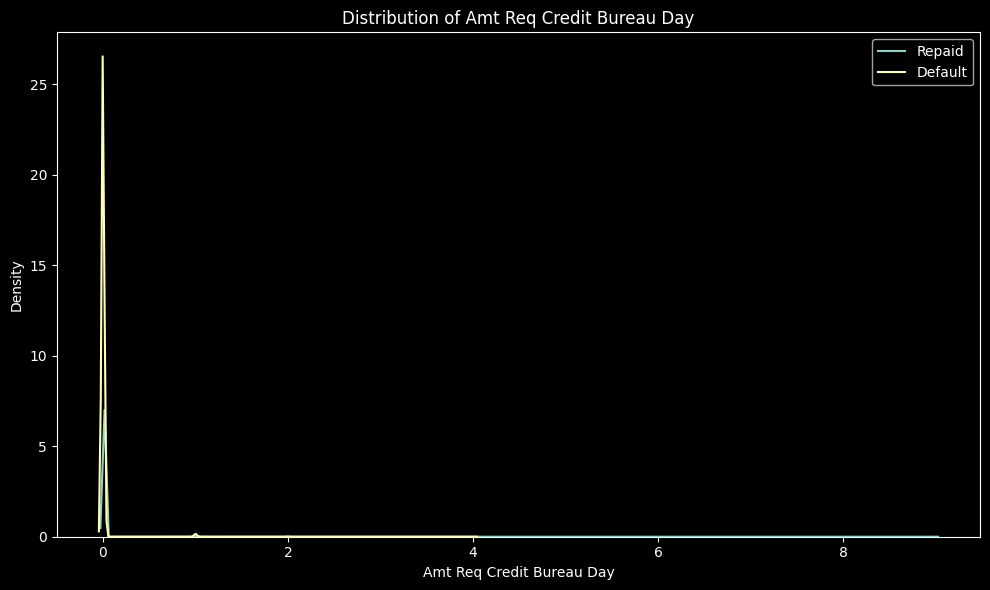

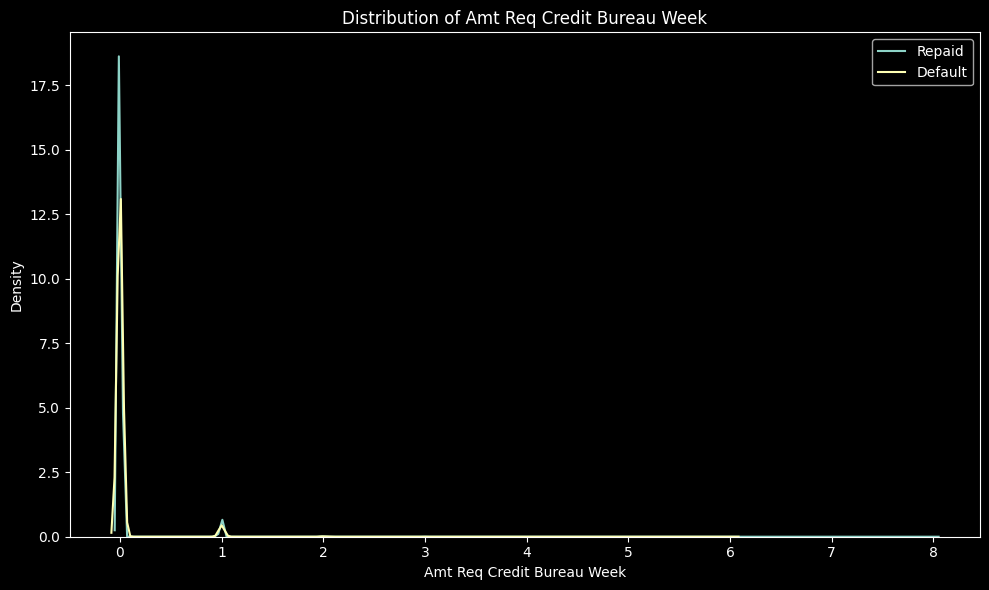

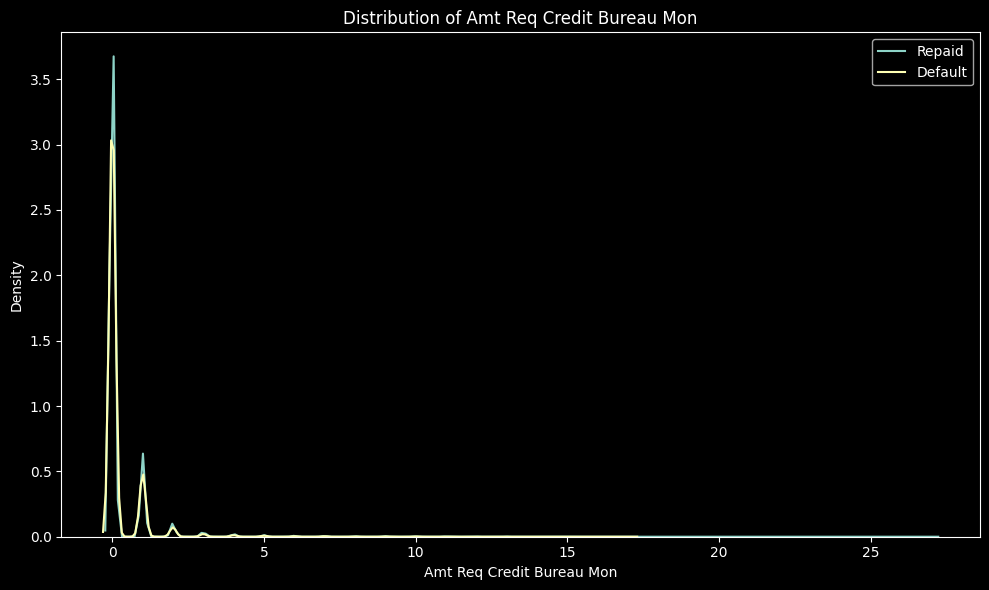

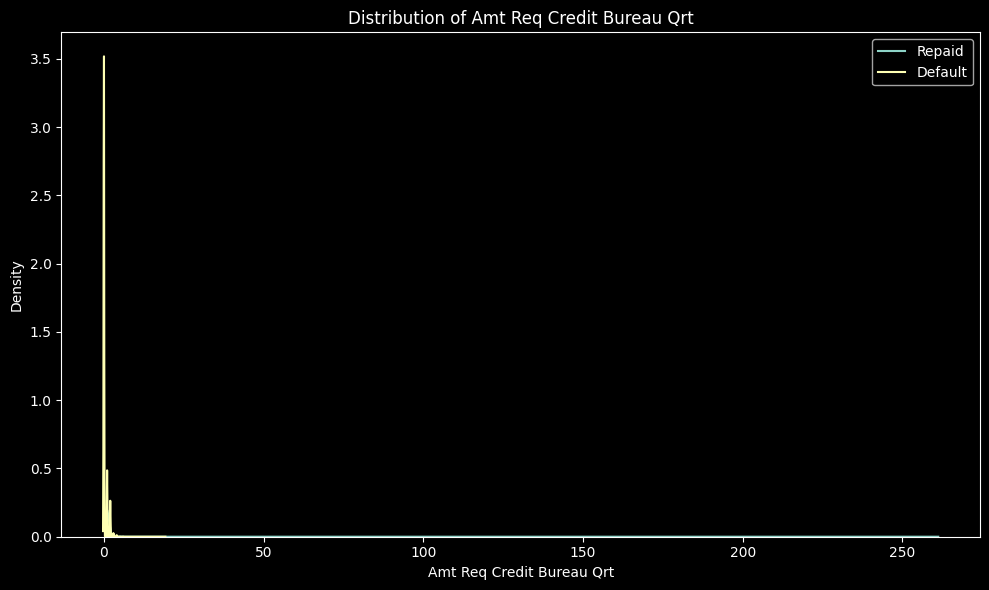

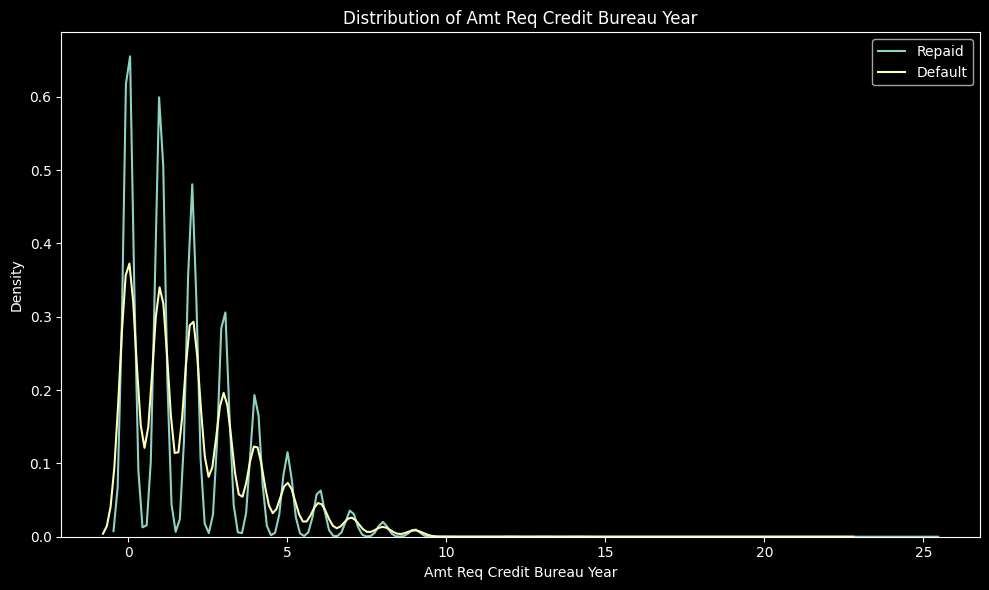

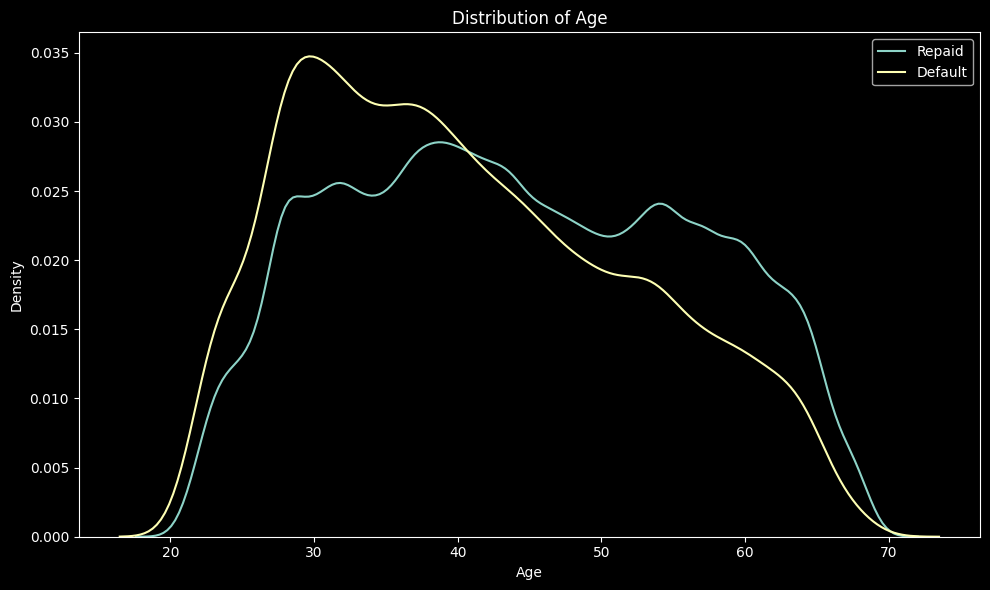

In [ ]:
def plot_kde_by_target(df, column, figsize=(10, 6)):
    """
    Plot KDE distribution of a column split by target variable.

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame containing the data
    column : str
        Name of the column to plot
    figsize : tuple, optional (default=(10, 6))
        Figure size as (width, height)
    """
    plt.figure(figsize=figsize)

    # KDE plot for each target class
    sns.kdeplot(df.loc[df["TARGET"] == 0, column], label="Repaid")
    sns.kdeplot(df.loc[df["TARGET"] == 1, column], label="Default")

    # Customize plot
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Distribution of {column.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()


# Plot KDE for all numeric columns
def plot_all_distributions(df):
    """
    Plot KDE distributions for all numeric columns in the dataframe.
    """
    # Get numeric columns excluding TARGET
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    numeric_cols = [col for col in numeric_cols if col != "TARGET"]

    print(f"Plotting distributions for {len(numeric_cols)} numeric columns...")

    # Plot each column
    for column in numeric_cols:
        try:
            plot_kde_by_target(df, column)
        except Exception as e:
            print(f"Could not plot {column}: {str(e)}")


# Call the function
plot_all_distributions(df_corr)


### Sources externes

Les 3 variables les plus corrélées avec notre cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation ce sont des scores normalizés depuis une source externe.

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_corr[
    ["TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AGE"]
]
ext_data_corrs = ext_data.corr()
ext_data_corrs


TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3       AGE
TARGET        1.000000     -0.155317     -0.160472     -0.178919 -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846  0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167  0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000  0.205478
AGE          -0.078239      0.600610      0.091996      0.205478  1.000000

In [ ]:
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-1, annot=True, vmax=1)
plt.title("Correlation Heatmap");


Les 3 variables issus de source externe sont corrélées negativement avec la cible, ce qui indique que plus la valeur de EXT_SOURCE augmente, plus le client aura tendance à rembourser son prêt.

On peut aussi noter que DAY_BIRTH est corrélé positivement avec EXT_SOURCE_1 ce qui indique que peut être un des facteurs de ce score est lié à l'âge.

In [ ]:
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_corr.loc[df_corr["TARGET"] == 0, source], label="Repaid")
    # plot loans that were not repaid
    sns.kdeplot(df_corr.loc[df_corr["TARGET"] == 1, source], label="Default")

    # Label the plots
    plt.title("Distribution of %s by Target Value" % source)
    plt.xlabel("%s" % source)
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout(h_pad=2.5)


### Pair plot

Les pairplot sont très utiles car ils permettent de voir les relations entre plusieurs variables.

/Users/jeremy/code/ocr/p7_pret_a_depenser/venv/lib/python3.12/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jeremy/code/ocr/p7_pret_a_depenser/venv/lib/python3.12/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jeremy/code/ocr/p7_pret_a_depenser/venv/lib/python3.12/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jeremy/code/ocr/p7_pret_a_depenser/venv/lib/python3.12/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jeremy/code/ocr/p7_pret_a_depenser/venv/lib/python3.12/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarn

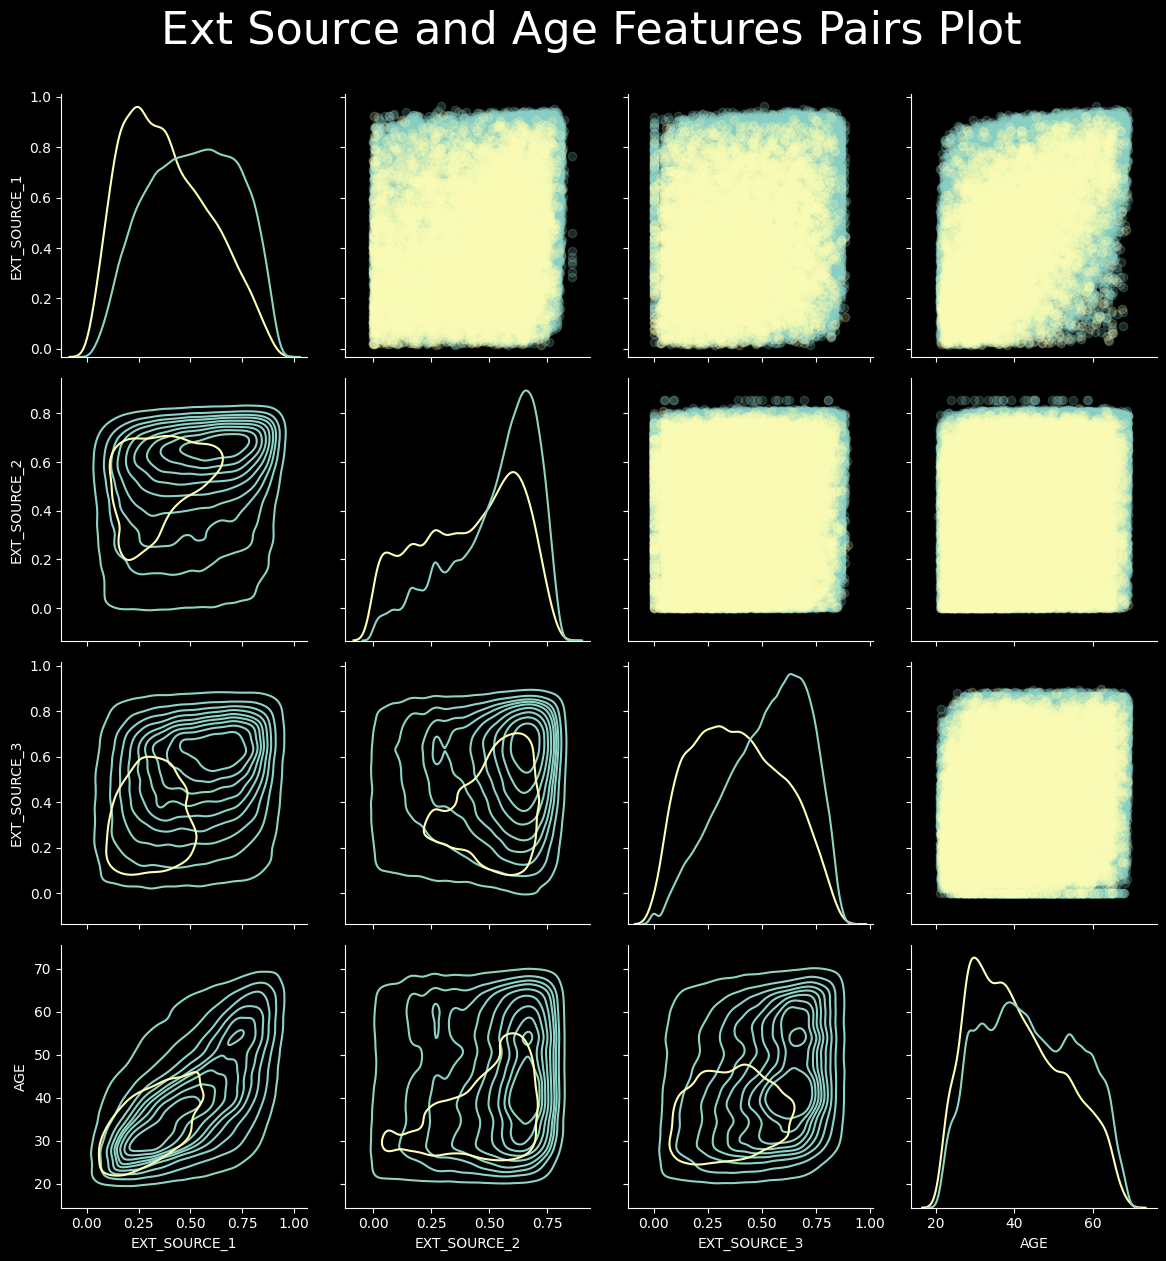

In [ ]:
# Copy the data for plotting
plot_data = ext_data.copy()

# # Add in the age of the client in years
# plot_data["YEARS_BIRTH"] = age_data["YEARS_BIRTH"]

# Drop na values and limit to first 10000 rows
# plot_data = plot_data.dropna().iloc[:10000, :]


# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(
        "r = {:.2f}".format(r), xy=(0.2, 0.8), xycoords=ax.transAxes, size=20
    )


# Create the pairgrid object
grid = sns.PairGrid(
    data=plot_data,
    height=3,
    diag_sharey=False,
    hue="TARGET",
    vars=[x for x in list(plot_data.columns) if x != "TARGET"],
)

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot, common_norm=False)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle("Ext Source and Age Features Pairs Plot", size=32, y=1.05);


Les données en jaune indiquent les prêts qui n'ont pas étés remboursés et en vert ceux qui ne l'ont pas été.

On peux remarquer qu'il y a une légère relation linéaire positive entre EXT_SOURCE_1 et YEARS_BIRTH

# Feature engineering

## Polynomial feature

Les caractéristiques polynomiales sont une transformation des variables existantes qui consiste à créer de nouvelles colonnes à partir de puissance et combinaisons de variables d'origine.

Cela permet de capturer des relations non linéaires tout en utilisant un modèle linéaire.

### Sans split

In [64]:
features = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AGE"]
X = data[features]
y = data["TARGET"]

imputer = SimpleImputer(strategy="median")
poly_transformer = PolynomialFeatures(degree=3)

X_train_imputed = imputer.fit_transform(X)

X_train_poly_after = poly_transformer.fit_transform(X_train_imputed)

poly_features = pd.DataFrame(
    X_train_poly_after,
    columns=poly_transformer.get_feature_names_out(
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AGE"]
    ),
)

poly_features["TARGET"] = y

poly_corrs = poly_features.corr()["TARGET"].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 AGE            -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 AGE                         -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
AGE      -0.078239
AGE^2    -0.076672
AGE^3    -0.074273
TARGET    1.000000
1              NaN
Name: TARGET, dtype: float64


### Avec split

In [65]:
features = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AGE"]
X = data[features]
y = data["TARGET"]

imputer = SimpleImputer(strategy="median")
poly_transformer = PolynomialFeatures(degree=3)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train_imputed = imputer.fit_transform(X_train)

X_train_poly_after = poly_transformer.fit_transform(X_train_imputed)

poly_features = pd.DataFrame(
    X_train_poly_after,
    columns=poly_transformer.get_feature_names_out(
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AGE"]
    ),
)

poly_features["TARGET"] = y

poly_corrs = poly_features.corr()["TARGET"].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))


EXT_SOURCE_2 EXT_SOURCE_3^2              -0.004710
EXT_SOURCE_2 EXT_SOURCE_3                -0.004585
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.004152
EXT_SOURCE_3                             -0.004121
EXT_SOURCE_3^2                           -0.004087
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.004007
EXT_SOURCE_3^3                           -0.003819
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.003534
EXT_SOURCE_1 EXT_SOURCE_3                -0.003164
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.002771
Name: TARGET, dtype: float64
AGE       0.001054
AGE^2     0.001367
AGE^3     0.001579
TARGET    1.000000
1              NaN
Name: TARGET, dtype: float64


On remarque que l'on obtient de meilleur score de corrélation avec les polynomial features qu'avec les features de base.

In [ ]:
# Put validation features into dataframe
poly_features_val = pd.DataFrame(
    poly_features_val,
    columns=poly_transformer.get_feature_names_out(
        ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH"]
    ),
)

# Merge polynomial features into training dataframe
poly_features["SK_ID_CURR"] = data["SK_ID_CURR"]
data_poly = data.merge(poly_features, on="SK_ID_CURR", how="left")

# Merge polynomial features into validation dataframe
poly_features_val["SK_ID_CURR"] = app_val["SK_ID_CURR"]
app_val_poly = app_val.merge(poly_features_val, on="SK_ID_CURR", how="left")

# Align the dataframes
data_poly, app_val_poly = data_poly.align(app_val_poly, join="inner", axis=1)

# Print out the new shapes
print("Training data with polynomial features shape: ", data_poly.shape)
print("Validation data with polynomial features shape:  ", app_val_poly.shape)


ValueError: Shape of passed values is (61503, 4), indices imply (61503, 35)

# Domain knowledge features

Voici les features que je considère ayant un potentiel pour expliquer si une personne pourra ou non son prêt :

CREDIT_INCOME_PERCENT: pourcentage du montant du crédit par rapport aux revenus.

ANNUITY_INCOME_PERCENT: pourcentage des annuités par rapport aux revenus.

CREDIT_TERM: durée de remboursement du crédit (en mois).

DAYS_EMPLOYED_PERCENT: poportion de la vie d'une personne pendant laquelle elle a travaillé dans son emploi actuel.

GOODS_PRICE_INCOME_PERCENT: pourcentage du bien acheté par rapport aux revenus

GOODS_PRICE_CREDIT_PERCENT : pourventage du bien acheté par rapport aux montant du crédit.

In [ ]:
data_domain = data.copy()

data_domain["CREDIT_INCOME_PERCENT"] = (
    data_domain["AMT_CREDIT"] / data_domain["AMT_INCOME_TOTAL"]
)
data_domain["ANNUITY_INCOME_PERCENT"] = (
    data_domain["AMT_ANNUITY"] / data_domain["AMT_INCOME_TOTAL"]
)
data_domain["CREDIT_TERM"] = (
    data_domain["AMT_ANNUITY"] / data_domain["AMT_CREDIT"]
)
data_domain["DAYS_EMPLOYED_PERCENT"] = (
    data_domain["DAYS_EMPLOYED"] / data_domain["AGE"]
)
data_domain["GOODS_PRICE_INCOME_PERCENT"] = (
    data_domain["AMT_GOODS_PRICE"] / data_domain["AMT_INCOME_TOTAL"]
)
data_domain["GOODS_PRICE_CREDIT_PERCENT"] = (
    data_domain["AMT_GOODS_PRICE"] / data_domain["AMT_CREDIT"]
)


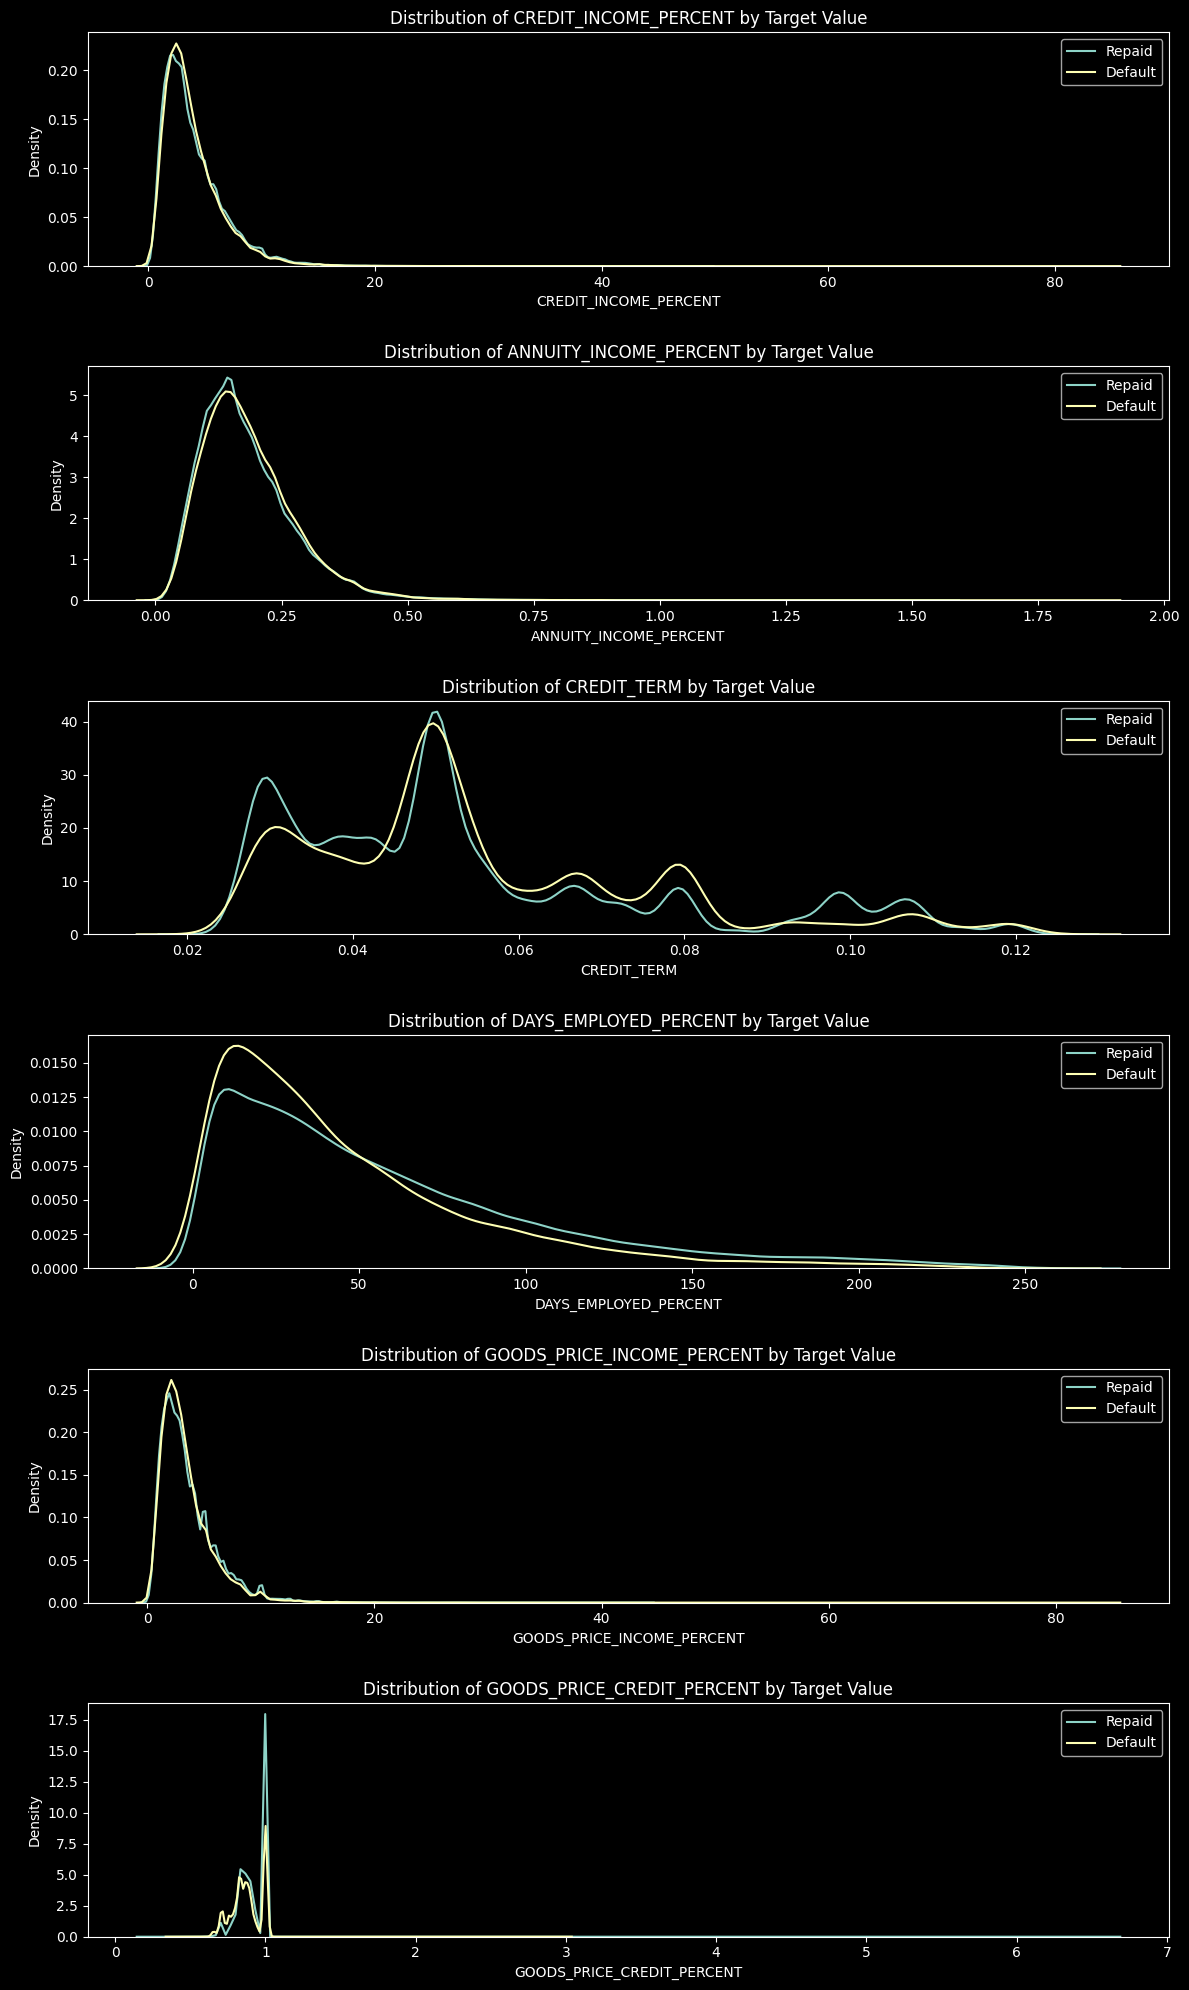

In [120]:
plt.figure(figsize=(12, 20))
# iterate through the new features
for i, feature in enumerate(
    [
        "CREDIT_INCOME_PERCENT",
        "ANNUITY_INCOME_PERCENT",
        "CREDIT_TERM",
        "DAYS_EMPLOYED_PERCENT",
        "GOODS_PRICE_INCOME_PERCENT",
        "GOODS_PRICE_CREDIT_PERCENT",
    ]
):
    # # create a new subplot for each source
    plt.subplot(6, 1, i + 1)
    # # plot repaid loans
    sns.kdeplot(
        data_domain.loc[data_domain["TARGET"] == 0, feature],
        label="Repaid",
    )
    # plot loans that were not repaid
    sns.kdeplot(
        data_domain.loc[data_domain["TARGET"] == 1, feature],
        label="Default",
    )
    # sns.kdeplot(data=data_domain, x=feature, hue="TARGET", common_norm=False)

    # Label the plots
    plt.title("Distribution of %s by Target Value" % feature)
    plt.xlabel("%s" % feature)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout(h_pad=2.5)
